In [1]:
import torch
import torch.nn.functional as F
import numpy as np                 # import numpy
import matplotlib.pyplot as plt    # import matplotlib
from torch.utils.data import Dataset, DataLoader,random_split
import torch.optim as optim
from tqdm import tqdm
import h5py
import scipy
from scipy.signal import find_peaks
from IPython.display import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import optuna

import utils
import Model
import Simulate_Dataset

# Set a random seed for PyTorch
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
# dataset parameters
fs = 1000                     # sampling frequency in Hz
data_dur =  3*63                 # data duration in s
actpot_dur = 5                   # action potential length in ms
window_dur = 3                   # window dutation in s
C = 1                              # number of neurons
s = 80                              # number of appearance of each neuron in each window
x_mean = 2                         # code amplitude mean
x_std = 0.1                         # code amplitude std
noise_std = 0.1
snr = 20

K = int(actpot_dur * fs / 1000) # filter legnth
N = int(window_dur * fs)        # example duration
J = int(data_dur / window_dur)  # number of examples

# data parameters
data_hyp ={"J": J, "N": N, "K": K, "C": C, "s": s, "x_mean": x_mean,
           "x_std": x_std, "SNR": snr, "device": device}

print("filter length:", K)
print("example duration:", N)
print("number of examples:", J)

filter length: 5
example duration: 3000
number of examples: 63


In [3]:
# fill in the gaps
net_hyp = {"T": 200,                 # number of encoder unfolding
           "L": 10,                  # 1/L is the step size in the encoder
           "C": 1,                 # number of filters
           "K": 18,                  # legnth of the filters
           "lam": 0.2,
           "device": device
           }

net = Model.CRsAE1D(net_hyp)

# training parameters
train_hyp = {"batch_size": 8, "num_epochs": 12, "lr": 1e-2, "shuffle": True}
# criterion
criterion = torch.nn.MSELoss()
# optimizer
optimizer = optim.Adam(net.parameters(), lr=train_hyp["lr"], eps=1e-3)

In [4]:
snr_list = np.linspace(-10,50,13)
print(snr_list)

[-10.  -5.   0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.]


In [5]:
def f1_score(label, pred):
  label = np.array(label.cpu())
  true_positives = np.sum((pred == 1) & (label == 1))
  all_positives = np.sum(label == 1)
  predicted_positives = np.sum(pred == 1)

  precision = true_positives / predicted_positives if predicted_positives > 0 else 0.0
  recall = true_positives / all_positives if all_positives > 0 else 0.0

  f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
  return f1_score

def check_naive_classifiers(signal, label, k=10):
    dataset_behave = create_behave_dataset_matrix(signal,label,device = device)
    X = dataset_behave.data.cpu()
    y = dataset_behave.label.cpu()

    kf = KFold(n_splits=k, shuffle=False)
    test_accuracy_list = []
    print("running tuna study on metric")
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

        def objective(trial):
            # Define hyperparameter search space
            model_type = trial.suggest_categorical('model', ['svm_linear', 'logistic'])
            C = trial.suggest_float('C', 0.01, 100, log=True)

            if model_type.startswith('svm'):
                svm_classifier = svm.SVC(C=C, kernel='linear')
                svm_classifier.fit(X_train, y_train)
                y_val_pred = svm_classifier.predict(X_val)
                val_accuracy = f1_score(y_val, y_val_pred)
            else:
                logistic_classifier = LogisticRegression(C=C, max_iter=1000)
                logistic_classifier.fit(X_train, y_train)
                y_val_pred = logistic_classifier.predict(X_val)
                val_accuracy = f1_score(y_val, y_val_pred)

            return val_accuracy

        # Create an Optuna study
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=20)

        # Get the best trial
        best_trial = study.best_trial
        best_params = best_trial.params
        best_score = best_trial.value

        # Train the best model on the entire training set
        if best_params['model'].startswith('svm'):
            best_model = svm.SVC(C=best_params['C'], kernel=best_params['model'][4:])
        else:
            best_model = LogisticRegression(C=best_params['C'], max_iter=1000)
        best_model.fit(X_train, y_train)

        # Evaluate the model on the test set
        y_test_pred = best_model.predict(X_test)
        test_accuracy = f1_score(y_test, y_test_pred)

        print("Best Hyperparameters from Optuna:", best_params)
        print("Best Validation Set Accuracy:", best_score)
        print("Test Set Accuracy:", test_accuracy)
        test_accuracy_list.append(test_accuracy)
    plt.figure()
    # Create subplots
    plt.subplot(3, 1, 1)
    plt.plot(y_test.T, label='ground truth')
    plt.subplot(3, 1, 2)
    plt.plot(y_test_pred.T, label='predicted')
    plt.subplot(3, 1, 3)
    plt.plot(X_test.mT[0], label='signal')
    # Show or save the figure
    plt.tight_layout()  # Adjust subplot spacing for clarity
    plt.show()

    return np.mean(test_accuracy_list)


class create_behave_dataset_matrix(Dataset):
    def __init__(self, x,label,device):
        self.label = label
        chunks = torch.split(x, 1, dim=1)
        # Concatenating the chunks along the first dimension
        self.data = x.T

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return  self.data[idx], self.label[idx]

In [6]:
snr_list = [(10,0.15),(15,0.15),(20,0.1),(25,0.05),(30,0.05),(35,0.1),(40,0),(45,0),(50,0),(-10,0.9),(-5,0.5),(0,0.3),(5,0.25)]
#snr_list = [(5,0.25)]

In [7]:
x_f1_score = []
y_f1_score = []
y_hat_f1_score = []
cur_snr_list = []
x_const = None

%%%%%%%%%%%%%%0%%%%%%%%%%%%%%%%%


C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_14744\266028130.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
[I 2023-09-13 13:19:32,383] A new study created in memory with name: no-name-4e3e7d37-15f6-4c02-a7d3-efc7f0c1a47f
[I 2023-09-13 13:19:32,395] Trial 0 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 4.232949656230698}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,411] Trial 1 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 3.8415558978905366}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,421] Trial 2 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.022837805146673995}. Best is trial 0 with value: 1.0.
[I 2023-09-13 1

For SNR = 10
On x
running tuna study on metric


[I 2023-09-13 13:19:32,555] Trial 11 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 3.5674611952720583}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,577] Trial 12 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 7.495396271630734}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,593] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.7373618901914083}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,614] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.42273599104022674}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,629] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 13.989332013820114}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,644] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 3.708777499298612}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,664] Trial 17 fi

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 4.232949656230698}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:19:32,907] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.5983578792021447}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,922] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.4724881058536265}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,935] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 4.069522656105361}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,949] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 94.95495646137844}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,970] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.3433234194136223}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:32,989] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 6.443391053246923}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,004] Trial 19 fini

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 2.149125923709248}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:19:33,210] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.3801210494634608}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,233] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.010585514420350493}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,257] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.0915773225457294}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,274] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 3.195683702997238}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,285] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.3944409901773934}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,310] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.10362996567432592}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,329] Tria

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 37.63081296982957}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:19:33,543] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.0866127852857572}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:19:33,561] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 4.6355606985342845}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:19:33,579] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.6700008986523326}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:19:33,603] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.07319839730039121}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:19:33,623] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.7748504838695855}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:19:33,638] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 3.953754695266264}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:19:33,656] Trial 18 f

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.7043732261732314}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:19:33,868] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 50.27896124082222}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,880] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 12.467081820545861}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,893] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 3.6720720997954306}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,904] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 75.49807605165599}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,919] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.1798451982087086}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,931] Trial 19 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 26.084505043814715}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:33,939] A new study 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.5586046275400114}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:19:34,131] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 10.15234914100354}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,146] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.07994497095594057}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,161] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.6038073853671853}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,177] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 18.489835732429032}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,196] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 13.835751115481779}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,214] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 3.2376331989912837}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,229] Trial 19 finis

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 51.43505621901344}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:19:34,444] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 25.960484677066123}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,461] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.9450549211505912}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,479] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 11.806042730723465}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,497] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 59.59557607839644}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,515] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 7.973387352708677}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,533] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.4417879575976653}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,547] Trial 19 finished wi

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 7.821016123217646}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:19:34,744] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.4217087362421503}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,757] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.06756874878190226}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,771] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.6700905622343425}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,788] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 5.919702110089476}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,801] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.14671050260713542}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,819] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.0383955785481387}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:34,834] Trial 19 finish

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 1.724536776787506}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:19:35,027] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 86.70901449422257}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,037] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 10.454477125904235}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,055] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 21.320712011432406}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,066] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 4.18111520200456}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,084] Trial 19 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 43.2263424358416}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,092] A new study created in memory with name: no-name-f630fcca-d36e-4bc4-8492-f92619e5ea4f
[I 2023-09-13 13:19:35,105] Trial 0 finished with value: 1.0 and parameters: {'model': 'lo

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 71.35285317348406}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:19:35,287] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.04918509673777079}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,302] Trial 14 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.010567599724580795}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,326] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.06773765067451272}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,344] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.57505355039015}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,367] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.11153340320786437}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,377] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.7822141353572826}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:19:35,391] Trial 1

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 5.135691897773268}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


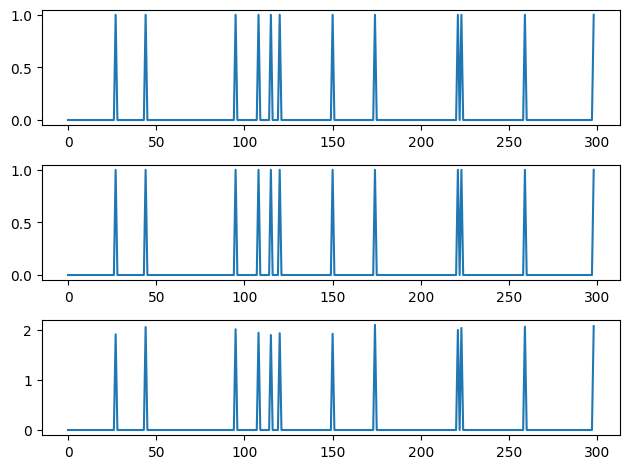

[I 2023-09-13 13:19:35,766] A new study created in memory with name: no-name-42dc9a4e-8404-4de3-94f4-6af2f763cdbf


On y
running tuna study on metric


[I 2023-09-13 13:19:35,946] Trial 0 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 10.372207432597543}. Best is trial 0 with value: 0.7837837837837837.
[I 2023-09-13 13:19:35,959] Trial 1 finished with value: 0.676923076923077 and parameters: {'model': 'logistic', 'C': 0.2748219761201187}. Best is trial 0 with value: 0.7837837837837837.
[I 2023-09-13 13:19:35,974] Trial 2 finished with value: 0.7945205479452054 and parameters: {'model': 'logistic', 'C': 2.8873248520744093}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:19:36,131] Trial 3 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 6.957522036138716}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:19:37,092] Trial 4 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 79.71755615555672}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:19:37,132] Trial 5 finished with value: 

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 2.8873248520744093}
Best Validation Set Accuracy: 0.7945205479452054
Test Set Accuracy: 0.6666666666666666


[I 2023-09-13 13:19:38,311] Trial 0 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 85.86996570971199}. Best is trial 0 with value: 0.7894736842105262.
[I 2023-09-13 13:19:38,531] Trial 1 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 14.214274416566278}. Best is trial 0 with value: 0.7894736842105262.
[I 2023-09-13 13:19:39,642] Trial 2 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 68.52818021071663}. Best is trial 0 with value: 0.7894736842105262.
[I 2023-09-13 13:19:39,687] Trial 3 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.7994752123738474}. Best is trial 0 with value: 0.7894736842105262.
[I 2023-09-13 13:19:39,729] Trial 4 finished with value: 0.6774193548387099 and parameters: {'model': 'svm_linear', 'C': 0.032630249718977565}. Best is trial 0 with value: 0.7894736842105262.
[I 2023-09-13 13:19:39,773] Trial 5 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 85.86996570971199}
Best Validation Set Accuracy: 0.7894736842105262
Test Set Accuracy: 0.7999999999999999


[I 2023-09-13 13:19:44,371] Trial 5 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 10.119082414422632}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:19:44,455] Trial 6 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 3.71036393952918}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:19:44,520] Trial 7 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 1.9490644416534142}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:19:44,596] Trial 8 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 3.013108467850544}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:19:44,638] Trial 9 finished with value: 0.6666666666666667 and parameters: {'model': 'svm_linear', 'C': 0.06016538888085157}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:19:44,660] Trial 10 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 95.42636748678862}
Best Validation Set Accuracy: 0.7945205479452054
Test Set Accuracy: 0.7619047619047619


[I 2023-09-13 13:19:48,955] Trial 4 finished with value: 0.7733333333333333 and parameters: {'model': 'logistic', 'C': 23.73351782661104}. Best is trial 3 with value: 0.7792207792207791.
[I 2023-09-13 13:19:48,970] Trial 5 finished with value: 0.7837837837837837 and parameters: {'model': 'logistic', 'C': 57.969999045268516}. Best is trial 5 with value: 0.7837837837837837.
[I 2023-09-13 13:19:49,084] Trial 6 finished with value: 0.7792207792207791 and parameters: {'model': 'svm_linear', 'C': 7.073514684945803}. Best is trial 5 with value: 0.7837837837837837.
[I 2023-09-13 13:19:49,124] Trial 7 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 0.632651702218958}. Best is trial 5 with value: 0.7837837837837837.
[I 2023-09-13 13:19:49,145] Trial 8 finished with value: 0.7837837837837837 and parameters: {'model': 'logistic', 'C': 52.14840331902936}. Best is trial 5 with value: 0.7837837837837837.
[I 2023-09-13 13:19:49,184] Trial 9 finished with value: 0.7

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.3320878338959528}
Best Validation Set Accuracy: 0.7894736842105262
Test Set Accuracy: 0.64


[I 2023-09-13 13:19:51,948] Trial 8 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 50.22335677636183}. Best is trial 5 with value: 0.7777777777777777.
[I 2023-09-13 13:19:51,987] Trial 9 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 0.34519115769446673}. Best is trial 5 with value: 0.7777777777777777.
[I 2023-09-13 13:19:52,004] Trial 10 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 24.34330559788354}. Best is trial 5 with value: 0.7777777777777777.
[I 2023-09-13 13:19:52,152] Trial 11 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 7.622604764209755}. Best is trial 5 with value: 0.7777777777777777.
[I 2023-09-13 13:19:52,167] Trial 12 finished with value: 0.7605633802816901 and parameters: {'model': 'logistic', 'C': 3.7088583550661833}. Best is trial 5 with value: 0.7777777777777777.
[I 2023-09-13 13:19:52,222] Trial 13 finished with value: 0.7777777

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 9.591092578580454}
Best Validation Set Accuracy: 0.7777777777777777
Test Set Accuracy: 0.7435897435897436


[I 2023-09-13 13:19:54,887] Trial 1 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 88.52954554672}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:19:55,012] Trial 2 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 5.338719622452974}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:19:55,028] Trial 3 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 16.756520296199366}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:19:55,038] Trial 4 finished with value: 0.6101694915254237 and parameters: {'model': 'logistic', 'C': 0.08477710706026798}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:19:55,053] Trial 5 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 4.168559780321116}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:19:55,061] Trial 6 finished with value: 0.09

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 5.338719622452974}
Best Validation Set Accuracy: 0.7945205479452054
Test Set Accuracy: 0.8


[I 2023-09-13 13:19:56,667] Trial 2 finished with value: 0.8055555555555555 and parameters: {'model': 'svm_linear', 'C': 17.069062760850173}. Best is trial 2 with value: 0.8055555555555555.
[I 2023-09-13 13:19:56,975] Trial 3 finished with value: 0.8055555555555555 and parameters: {'model': 'svm_linear', 'C': 19.687455505911863}. Best is trial 2 with value: 0.8055555555555555.
[I 2023-09-13 13:19:57,260] Trial 4 finished with value: 0.8055555555555555 and parameters: {'model': 'svm_linear', 'C': 18.66514467245048}. Best is trial 2 with value: 0.8055555555555555.
[I 2023-09-13 13:19:57,300] Trial 5 finished with value: 0.7323943661971831 and parameters: {'model': 'svm_linear', 'C': 0.15204546977554315}. Best is trial 2 with value: 0.8055555555555555.
[I 2023-09-13 13:19:57,317] Trial 6 finished with value: 0.7714285714285714 and parameters: {'model': 'logistic', 'C': 3.789761905752851}. Best is trial 2 with value: 0.8055555555555555.
[I 2023-09-13 13:19:57,356] Trial 7 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 17.069062760850173}
Best Validation Set Accuracy: 0.8055555555555555
Test Set Accuracy: 0.7848101265822786


[I 2023-09-13 13:20:01,536] Trial 6 finished with value: 0.7246376811594203 and parameters: {'model': 'svm_linear', 'C': 51.31736030906504}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:20:01,579] Trial 7 finished with value: 0.4 and parameters: {'model': 'svm_linear', 'C': 0.012041806179703875}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:20:01,592] Trial 8 finished with value: 0.7714285714285714 and parameters: {'model': 'logistic', 'C': 1.5084569846529166}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:20:01,604] Trial 9 finished with value: 0.7714285714285714 and parameters: {'model': 'logistic', 'C': 2.8274353805965506}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:20:01,621] Trial 10 finished with value: 0.7945205479452054 and parameters: {'model': 'logistic', 'C': 94.84512303023155}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:20:01,639] Trial 11 finished with value: 0.7945205479

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 21.887772852453697}
Best Validation Set Accuracy: 0.8055555555555555
Test Set Accuracy: 0.7419354838709676


[I 2023-09-13 13:20:02,185] Trial 6 finished with value: 0.821917808219178 and parameters: {'model': 'svm_linear', 'C': 16.80037457120326}. Best is trial 6 with value: 0.821917808219178.
[I 2023-09-13 13:20:02,311] Trial 7 finished with value: 0.821917808219178 and parameters: {'model': 'svm_linear', 'C': 7.1991572884489345}. Best is trial 6 with value: 0.821917808219178.
[I 2023-09-13 13:20:02,349] Trial 8 finished with value: 0.7714285714285714 and parameters: {'model': 'svm_linear', 'C': 0.3687865586670527}. Best is trial 6 with value: 0.821917808219178.
[I 2023-09-13 13:20:02,364] Trial 9 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 3.809078694752426}. Best is trial 6 with value: 0.821917808219178.
[I 2023-09-13 13:20:03,185] Trial 10 finished with value: 0.821917808219178 and parameters: {'model': 'svm_linear', 'C': 58.07812116111749}. Best is trial 6 with value: 0.821917808219178.
[I 2023-09-13 13:20:03,446] Trial 11 finished with value: 0.82

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 16.80037457120326}
Best Validation Set Accuracy: 0.821917808219178
Test Set Accuracy: 0.8571428571428572


[I 2023-09-13 13:20:06,400] Trial 2 finished with value: 0.8108108108108109 and parameters: {'model': 'svm_linear', 'C': 25.545299437947342}. Best is trial 2 with value: 0.8108108108108109.
[I 2023-09-13 13:20:06,409] Trial 3 finished with value: 0.4 and parameters: {'model': 'logistic', 'C': 0.05619483895278928}. Best is trial 2 with value: 0.8108108108108109.
[I 2023-09-13 13:20:06,450] Trial 4 finished with value: 0.5454545454545454 and parameters: {'model': 'svm_linear', 'C': 0.02719880530418151}. Best is trial 2 with value: 0.8108108108108109.
[I 2023-09-13 13:20:06,466] Trial 5 finished with value: 0.7857142857142857 and parameters: {'model': 'logistic', 'C': 0.46798378716091016}. Best is trial 2 with value: 0.8108108108108109.
[I 2023-09-13 13:20:06,511] Trial 6 finished with value: 0.7777777777777777 and parameters: {'model': 'svm_linear', 'C': 1.1268721072095467}. Best is trial 2 with value: 0.8108108108108109.
[I 2023-09-13 13:20:06,521] Trial 7 finished with value: 0.64 and 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.9145520278206747}
Best Validation Set Accuracy: 0.8571428571428572
Test Set Accuracy: 0.7857142857142858


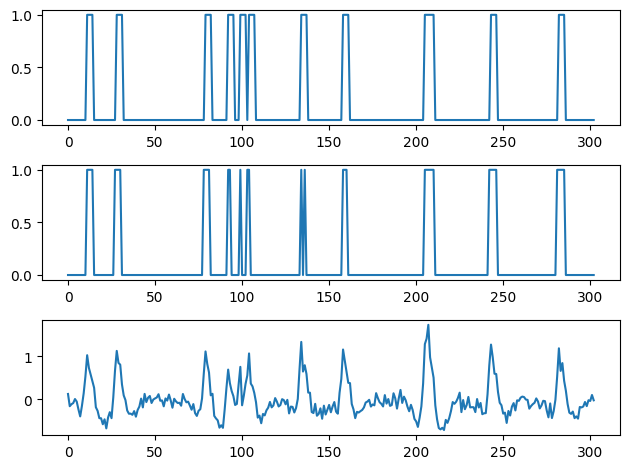

[I 2023-09-13 13:20:09,936] A new study created in memory with name: no-name-2f06fa30-eb78-4ebd-ac35-47979dfc8051
[I 2023-09-13 13:20:09,950] Trial 0 finished with value: 0.5185185185185185 and parameters: {'model': 'logistic', 'C': 0.09512433739514883}. Best is trial 0 with value: 0.5185185185185185.
[I 2023-09-13 13:20:09,963] Trial 1 finished with value: 0.4905660377358491 and parameters: {'model': 'logistic', 'C': 0.08699267374282682}. Best is trial 0 with value: 0.5185185185185185.
[I 2023-09-13 13:20:09,976] Trial 2 finished with value: 0.6440677966101694 and parameters: {'model': 'logistic', 'C': 0.21921088446770487}. Best is trial 2 with value: 0.6440677966101694.
[I 2023-09-13 13:20:09,993] Trial 3 finished with value: 0.7536231884057972 and parameters: {'model': 'logistic', 'C': 4.521670049063527}. Best is trial 3 with value: 0.7536231884057972.
[I 2023-09-13 13:20:10,031] Trial 4 finished with value: 0.7058823529411764 and parameters: {'model': 'svm_linear', 'C': 0.288849735

On y_hat
running tuna study on metric


[I 2023-09-13 13:20:10,138] Trial 8 finished with value: 0.7462686567164178 and parameters: {'model': 'logistic', 'C': 3.0921690357400036}. Best is trial 3 with value: 0.7536231884057972.
[I 2023-09-13 13:20:10,151] Trial 9 finished with value: 0.7096774193548387 and parameters: {'model': 'logistic', 'C': 0.3775962962132727}. Best is trial 3 with value: 0.7536231884057972.
[I 2023-09-13 13:20:10,199] Trial 10 finished with value: 0.09523809523809523 and parameters: {'model': 'svm_linear', 'C': 0.0108106447920698}. Best is trial 3 with value: 0.7536231884057972.
[I 2023-09-13 13:20:10,223] Trial 11 finished with value: 0.7536231884057972 and parameters: {'model': 'logistic', 'C': 67.23600995470471}. Best is trial 3 with value: 0.7536231884057972.
[I 2023-09-13 13:20:10,242] Trial 12 finished with value: 0.7536231884057972 and parameters: {'model': 'logistic', 'C': 82.66052212137856}. Best is trial 3 with value: 0.7536231884057972.
[I 2023-09-13 13:20:10,262] Trial 13 finished with value

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 4.521670049063527}
Best Validation Set Accuracy: 0.7536231884057972
Test Set Accuracy: 0.6530612244897959


[I 2023-09-13 13:20:10,664] Trial 6 finished with value: 0.7027027027027027 and parameters: {'model': 'svm_linear', 'C': 0.5388246428715732}. Best is trial 3 with value: 0.7567567567567567.
[I 2023-09-13 13:20:11,376] Trial 7 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 88.2402792214572}. Best is trial 3 with value: 0.7567567567567567.
[I 2023-09-13 13:20:11,390] Trial 8 finished with value: 0.2978723404255319 and parameters: {'model': 'logistic', 'C': 0.046157447198216926}. Best is trial 3 with value: 0.7567567567567567.
[I 2023-09-13 13:20:11,402] Trial 9 finished with value: 0.18181818181818182 and parameters: {'model': 'logistic', 'C': 0.03853646153872956}. Best is trial 3 with value: 0.7567567567567567.
[I 2023-09-13 13:20:11,511] Trial 10 finished with value: 0.7466666666666666 and parameters: {'model': 'svm_linear', 'C': 9.853019963308038}. Best is trial 3 with value: 0.7567567567567567.
[I 2023-09-13 13:20:12,217] Trial 11 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 13.291232625552535}
Best Validation Set Accuracy: 0.7567567567567567
Test Set Accuracy: 0.7567567567567567


[I 2023-09-13 13:20:14,472] Trial 1 finished with value: 0.717948717948718 and parameters: {'model': 'svm_linear', 'C': 28.39767227533198}. Best is trial 1 with value: 0.717948717948718.
[I 2023-09-13 13:20:14,489] Trial 2 finished with value: 0.7397260273972603 and parameters: {'model': 'logistic', 'C': 18.889849422306018}. Best is trial 2 with value: 0.7397260273972603.
[I 2023-09-13 13:20:14,501] Trial 3 finished with value: 0.4615384615384615 and parameters: {'model': 'logistic', 'C': 0.07519826234858025}. Best is trial 2 with value: 0.7397260273972603.
[I 2023-09-13 13:20:14,513] Trial 4 finished with value: 0.7076923076923077 and parameters: {'model': 'logistic', 'C': 0.9226502394113545}. Best is trial 2 with value: 0.7397260273972603.
[I 2023-09-13 13:20:14,554] Trial 5 finished with value: 0.5185185185185185 and parameters: {'model': 'svm_linear', 'C': 0.023753594799151817}. Best is trial 2 with value: 0.7397260273972603.
[I 2023-09-13 13:20:14,564] Trial 6 finished with value:

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 4.6245033373727775}
Best Validation Set Accuracy: 0.7714285714285714
Test Set Accuracy: 0.7812500000000001


[I 2023-09-13 13:20:15,161] Trial 3 finished with value: 0.6849315068493151 and parameters: {'model': 'svm_linear', 'C': 2.8209101879705}. Best is trial 0 with value: 0.7222222222222223.
[I 2023-09-13 13:20:15,204] Trial 4 finished with value: 0.09523809523809523 and parameters: {'model': 'svm_linear', 'C': 0.011274054612252461}. Best is trial 0 with value: 0.7222222222222223.
[I 2023-09-13 13:20:15,246] Trial 5 finished with value: 0.2222222222222222 and parameters: {'model': 'svm_linear', 'C': 0.015387499662267873}. Best is trial 0 with value: 0.7222222222222223.
[I 2023-09-13 13:20:15,265] Trial 6 finished with value: 0.7142857142857143 and parameters: {'model': 'logistic', 'C': 13.51174518836227}. Best is trial 0 with value: 0.7222222222222223.
[I 2023-09-13 13:20:15,301] Trial 7 finished with value: 0.6944444444444444 and parameters: {'model': 'svm_linear', 'C': 0.42492217800435833}. Best is trial 0 with value: 0.7222222222222223.
[I 2023-09-13 13:20:15,319] Trial 8 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 36.30515039446751}
Best Validation Set Accuracy: 0.7323943661971831
Test Set Accuracy: 0.6122448979591837


[I 2023-09-13 13:20:18,050] Trial 2 finished with value: 0.7323943661971831 and parameters: {'model': 'svm_linear', 'C': 22.485042151821443}. Best is trial 0 with value: 0.7605633802816901.
[I 2023-09-13 13:20:18,067] Trial 3 finished with value: 0.71875 and parameters: {'model': 'logistic', 'C': 0.570055862524807}. Best is trial 0 with value: 0.7605633802816901.
[I 2023-09-13 13:20:18,081] Trial 4 finished with value: 0.71875 and parameters: {'model': 'logistic', 'C': 1.4361929394704134}. Best is trial 0 with value: 0.7605633802816901.
[I 2023-09-13 13:20:18,099] Trial 5 finished with value: 0.7605633802816901 and parameters: {'model': 'logistic', 'C': 26.771577900728197}. Best is trial 0 with value: 0.7605633802816901.
[I 2023-09-13 13:20:18,136] Trial 6 finished with value: 0.6984126984126985 and parameters: {'model': 'svm_linear', 'C': 0.08691914035392437}. Best is trial 0 with value: 0.7605633802816901.
[I 2023-09-13 13:20:18,165] Trial 7 finished with value: 0.7323943661971831 an

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 6.990003857796277}
Best Validation Set Accuracy: 0.7826086956521738
Test Set Accuracy: 0.6575342465753425


[I 2023-09-13 13:20:19,061] Trial 9 finished with value: 0.5714285714285715 and parameters: {'model': 'svm_linear', 'C': 0.02906555007323469}. Best is trial 0 with value: 0.7567567567567567.
[I 2023-09-13 13:20:19,103] Trial 10 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.403752385360255}. Best is trial 0 with value: 0.7567567567567567.
[I 2023-09-13 13:20:19,145] Trial 11 finished with value: 0.7368421052631577 and parameters: {'model': 'svm_linear', 'C': 0.7104158659694375}. Best is trial 0 with value: 0.7567567567567567.
[I 2023-09-13 13:20:19,188] Trial 12 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.42417604331761655}. Best is trial 0 with value: 0.7567567567567567.
[I 2023-09-13 13:20:19,262] Trial 13 finished with value: 0.7466666666666666 and parameters: {'model': 'svm_linear', 'C': 5.013697357700486}. Best is trial 0 with value: 0.7567567567567567.
[I 2023-09-13 13:20:19,312] Trial 14 finished 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.182473204586423}
Best Validation Set Accuracy: 0.7567567567567567
Test Set Accuracy: 0.8372093023255814


[I 2023-09-13 13:20:19,944] Trial 7 finished with value: 0.7222222222222223 and parameters: {'model': 'svm_linear', 'C': 0.36588194292349546}. Best is trial 1 with value: 0.7368421052631577.
[I 2023-09-13 13:20:19,986] Trial 8 finished with value: 0.36734693877551017 and parameters: {'model': 'svm_linear', 'C': 0.019594929815221682}. Best is trial 1 with value: 0.7368421052631577.
[I 2023-09-13 13:20:20,004] Trial 9 finished with value: 0.7397260273972603 and parameters: {'model': 'logistic', 'C': 45.4642458199116}. Best is trial 9 with value: 0.7397260273972603.
[I 2023-09-13 13:20:20,026] Trial 10 finished with value: 0.7397260273972603 and parameters: {'model': 'logistic', 'C': 80.00910401424255}. Best is trial 9 with value: 0.7397260273972603.
[I 2023-09-13 13:20:20,046] Trial 11 finished with value: 0.7397260273972603 and parameters: {'model': 'logistic', 'C': 90.79730190236843}. Best is trial 9 with value: 0.7397260273972603.
[I 2023-09-13 13:20:20,068] Trial 12 finished with val

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 19.891182066227287}
Best Validation Set Accuracy: 0.75
Test Set Accuracy: 0.7948717948717949


[I 2023-09-13 13:20:20,524] Trial 4 finished with value: 0.7323943661971831 and parameters: {'model': 'svm_linear', 'C': 24.46156172951307}. Best is trial 4 with value: 0.7323943661971831.
[I 2023-09-13 13:20:20,533] Trial 5 finished with value: 0.13953488372093023 and parameters: {'model': 'logistic', 'C': 0.030678079428513475}. Best is trial 4 with value: 0.7323943661971831.
[I 2023-09-13 13:20:20,585] Trial 6 finished with value: 0.72 and parameters: {'model': 'svm_linear', 'C': 3.0683435739087943}. Best is trial 4 with value: 0.7323943661971831.
[I 2023-09-13 13:20:20,637] Trial 7 finished with value: 0.7105263157894738 and parameters: {'model': 'svm_linear', 'C': 2.9523363442736574}. Best is trial 4 with value: 0.7323943661971831.
[I 2023-09-13 13:20:21,161] Trial 8 finished with value: 0.7222222222222223 and parameters: {'model': 'svm_linear', 'C': 96.51979912595783}. Best is trial 4 with value: 0.7323943661971831.
[I 2023-09-13 13:20:21,198] Trial 9 finished with value: 0.707692

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 21.64327306195887}
Best Validation Set Accuracy: 0.7647058823529412
Test Set Accuracy: 0.761904761904762


[I 2023-09-13 13:20:21,596] Trial 6 finished with value: 0.7368421052631577 and parameters: {'model': 'svm_linear', 'C': 3.3053928051468997}. Best is trial 0 with value: 0.7397260273972603.
[I 2023-09-13 13:20:21,655] Trial 7 finished with value: 0.72 and parameters: {'model': 'svm_linear', 'C': 5.142284578463177}. Best is trial 0 with value: 0.7397260273972603.
[I 2023-09-13 13:20:21,674] Trial 8 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 24.086152433288124}. Best is trial 0 with value: 0.7397260273972603.
[I 2023-09-13 13:20:21,691] Trial 9 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 27.857610787097034}. Best is trial 0 with value: 0.7397260273972603.
[I 2023-09-13 13:20:21,733] Trial 10 finished with value: 0.7142857142857143 and parameters: {'model': 'svm_linear', 'C': 0.3054324718493958}. Best is trial 0 with value: 0.7397260273972603.
[I 2023-09-13 13:20:21,775] Trial 11 finished with value: 0.73972602

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.7977153266828781}
Best Validation Set Accuracy: 0.7397260273972603
Test Set Accuracy: 0.8275862068965517


[I 2023-09-13 13:20:23,237] Trial 3 finished with value: 0.7096774193548386 and parameters: {'model': 'svm_linear', 'C': 42.67309680939301}. Best is trial 0 with value: 0.7999999999999999.
[I 2023-09-13 13:20:23,280] Trial 4 finished with value: 0.8275862068965517 and parameters: {'model': 'svm_linear', 'C': 1.7423122275450629}. Best is trial 4 with value: 0.8275862068965517.
[I 2023-09-13 13:20:23,293] Trial 5 finished with value: 0.47619047619047616 and parameters: {'model': 'logistic', 'C': 0.09903133307539896}. Best is trial 4 with value: 0.8275862068965517.
[I 2023-09-13 13:20:23,334] Trial 6 finished with value: 0.0 and parameters: {'model': 'svm_linear', 'C': 0.011146772145750676}. Best is trial 4 with value: 0.8275862068965517.
[I 2023-09-13 13:20:23,348] Trial 7 finished with value: 0.4 and parameters: {'model': 'logistic', 'C': 0.09501521352298478}. Best is trial 4 with value: 0.8275862068965517.
[I 2023-09-13 13:20:23,359] Trial 8 finished with value: 0.4 and parameters: {'m

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.42972699148656884}
Best Validation Set Accuracy: 0.8571428571428571
Test Set Accuracy: 0.7142857142857143


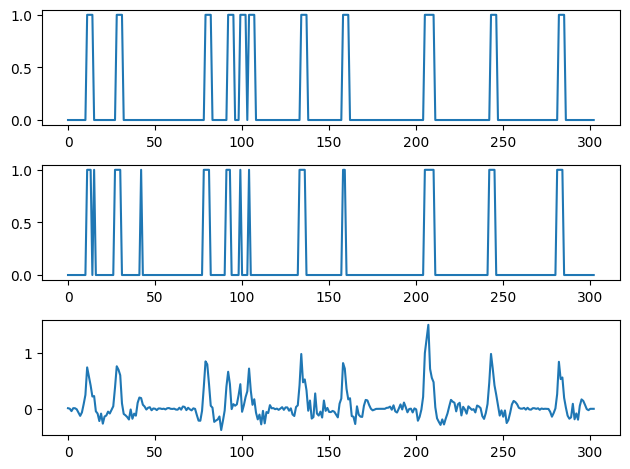

C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_14744\266028130.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
[I 2023-09-13 13:20:24,499] A new study created in memory with name: no-name-80baa9cc-0969-4b3d-9ddb-fb4031fd156a
[I 2023-09-13 13:20:24,521] Trial 0 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.016513695695893178}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:24,532] Trial 1 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.011648619872867973}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:24,543] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.17938938976247762}. Best is trial 0 with value: 1.0.
[I 2023-09-

For SNR = 15
On x
running tuna study on metric


[I 2023-09-13 13:20:24,688] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.13884813570486906}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:24,703] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.7554771395258204}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:24,718] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.08882548304170859}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:24,733] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 62.4384659377907}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:24,750] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.4421378476265727}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:24,766] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.027178181549271384}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:24,780] Trial 19 f

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.016513695695893178}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:20:25,017] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 90.92662399572025}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,032] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 26.584612236991006}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,049] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 3.754054881969551}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,066] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 19.784941018267826}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,081] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 12.024179432559206}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,098] Trial 19 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 33.72682246738441}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,115] A new study created

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 30.920185760294576}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:20:25,302] Trial 12 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 2.280578427716771}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,315] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.27351632784190993}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,337] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 92.98611519573032}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,355] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.3726937653369142}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,369] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.08497430304964192}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,381] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.34379746597745364}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,400] Trial 18 fi

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.06304633011567501}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:20:25,627] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.07304597931302965}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,644] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.4580218155896801}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,658] Trial 16 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.011541505396769363}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,671] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.06455448065515716}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,683] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.3188755920932677}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,700] Trial 19 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.6622347507906425}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,712] A new stud

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.19313713136904678}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:20:25,910] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.9616009138836109}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,924] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 81.44548773093967}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,937] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 6.811379298459039}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,960] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.0827042789411701}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:25,988] Trial 19 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.04170518207323317}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,005] A new study created in memory with name: no-name-4593a9de-f799-40d5-89fb-7cf7946d6380
[I 2023-09-13 13:20:26,027] Trial 0 finished with value: 1.0 and parameters: {'mod

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 28.857747239469766}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:20:26,188] Trial 11 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.010540782482380353}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,208] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.05084693869594832}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,229] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.041394532924886415}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,257] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.10755630845552179}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,277] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.029641086863757153}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,299] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.01039246051082864}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,31

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.031675826155707895}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:20:26,577] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.5371448308763082}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,597] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.09503918308064373}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,614] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.5700170971335368}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,627] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 3.5967264424221015}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,638] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 51.51181405099185}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,656] Trial 19 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.5358935259424454}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,670] A new study 

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.9790927892157408}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:20:26,853] Trial 12 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 12.682890134918875}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,871] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 40.667020039091064}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,888] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 6.115603764973753}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,907] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 22.85301447618422}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,925] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 76.16588687909147}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,943] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 2.115774054606543}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:26,960] Trial 18 finished with

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 5.636971756005184}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:20:27,193] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.12365788578463309}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:27,210] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.0957129767713871}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:27,223] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.36363535023038174}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:27,234] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 9.417773523542234}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:27,251] Trial 19 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 2.2724886823465247}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:27,260] A new study created in memory with name: no-name-846aefd0-0f64-42d3-bb0b-1f7d82ccb749
[I 2023-09-13 13:20:27,270] Trial 0 finished with value: 1.0 and parameters: {'model':

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.9929431663710684}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:20:27,449] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.06009694827599238}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:27,459] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.0209405200597828}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:27,470] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 6.967713631707621}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:27,484] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.27373449421969603}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:27,502] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.8066500322822631}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:20:27,534] Trial 19 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.09425278000226378}. Best is trial 0 with value: 1.0.


Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.251921865455566}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


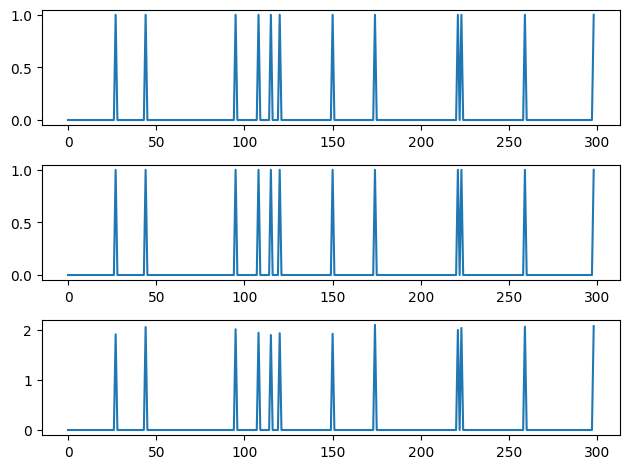

[I 2023-09-13 13:20:27,805] A new study created in memory with name: no-name-1f08e7b1-4dba-4504-b522-3485a8bcbccf
[I 2023-09-13 13:20:27,852] Trial 0 finished with value: 0.6557377049180327 and parameters: {'model': 'svm_linear', 'C': 0.022846414566177912}. Best is trial 0 with value: 0.6557377049180327.
[I 2023-09-13 13:20:27,865] Trial 1 finished with value: 0.6774193548387099 and parameters: {'model': 'logistic', 'C': 0.2026742500875787}. Best is trial 1 with value: 0.6774193548387099.
[I 2023-09-13 13:20:27,874] Trial 2 finished with value: 0.5964912280701754 and parameters: {'model': 'logistic', 'C': 0.08390671828365688}. Best is trial 1 with value: 0.6774193548387099.
[I 2023-09-13 13:20:27,908] Trial 3 finished with value: 0.7887323943661972 and parameters: {'model': 'svm_linear', 'C': 0.5636725876603262}. Best is trial 3 with value: 0.7887323943661972.
[I 2023-09-13 13:20:27,924] Trial 4 finished with value: 0.7714285714285714 and parameters: {'model': 'logistic', 'C': 1.740513

On y
running tuna study on metric


[I 2023-09-13 13:20:27,981] Trial 6 finished with value: 0.7536231884057972 and parameters: {'model': 'logistic', 'C': 1.1691944936442786}. Best is trial 3 with value: 0.7887323943661972.
[I 2023-09-13 13:20:27,990] Trial 7 finished with value: 0.36734693877551017 and parameters: {'model': 'logistic', 'C': 0.0342846644179944}. Best is trial 3 with value: 0.7887323943661972.
[I 2023-09-13 13:20:28,030] Trial 8 finished with value: 0.8378378378378379 and parameters: {'model': 'svm_linear', 'C': 1.211979880962917}. Best is trial 8 with value: 0.8378378378378379.
[I 2023-09-13 13:20:28,046] Trial 9 finished with value: 0.8 and parameters: {'model': 'logistic', 'C': 9.770968693519663}. Best is trial 8 with value: 0.8378378378378379.
[I 2023-09-13 13:20:28,716] Trial 10 finished with value: 0.8378378378378379 and parameters: {'model': 'svm_linear', 'C': 74.24856615533902}. Best is trial 8 with value: 0.8378378378378379.
[I 2023-09-13 13:20:29,351] Trial 11 finished with value: 0.853333333333

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 86.86783733747954}
Best Validation Set Accuracy: 0.8533333333333333
Test Set Accuracy: 0.7142857142857143


[I 2023-09-13 13:20:34,012] Trial 1 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 38.71346023368205}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:20:34,027] Trial 2 finished with value: 0.7777777777777777 and parameters: {'model': 'logistic', 'C': 23.17160375440931}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:20:34,072] Trial 3 finished with value: 0.6440677966101694 and parameters: {'model': 'svm_linear', 'C': 0.017968177044204333}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:20:34,109] Trial 4 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 0.7422272206431545}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:20:34,121] Trial 5 finished with value: 0.6557377049180327 and parameters: {'model': 'logistic', 'C': 0.20459686522330991}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:20:34,167] Trial 6 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 38.71346023368205}
Best Validation Set Accuracy: 0.8108108108108107
Test Set Accuracy: 0.6842105263157895


[I 2023-09-13 13:20:36,067] Trial 1 finished with value: 0.7848101265822786 and parameters: {'model': 'svm_linear', 'C': 22.88724769390397}. Best is trial 1 with value: 0.7848101265822786.
[I 2023-09-13 13:20:36,111] Trial 2 finished with value: 0.6440677966101694 and parameters: {'model': 'svm_linear', 'C': 0.016881201237325408}. Best is trial 1 with value: 0.7848101265822786.
[I 2023-09-13 13:20:36,123] Trial 3 finished with value: 0.6774193548387099 and parameters: {'model': 'logistic', 'C': 0.19731429787725405}. Best is trial 1 with value: 0.7848101265822786.
[I 2023-09-13 13:20:36,135] Trial 4 finished with value: 0.71875 and parameters: {'model': 'logistic', 'C': 0.33755003668530326}. Best is trial 1 with value: 0.7848101265822786.
[I 2023-09-13 13:20:36,148] Trial 5 finished with value: 0.8108108108108107 and parameters: {'model': 'logistic', 'C': 19.192673327441177}. Best is trial 5 with value: 0.8108108108108107.
[I 2023-09-13 13:20:36,190] Trial 6 finished with value: 0.79999

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 19.192673327441177}
Best Validation Set Accuracy: 0.8108108108108107
Test Set Accuracy: 0.8115942028985507


[I 2023-09-13 13:20:37,482] Trial 1 finished with value: 0.8 and parameters: {'model': 'svm_linear', 'C': 86.87671745393783}. Best is trial 1 with value: 0.8.
[I 2023-09-13 13:20:37,522] Trial 2 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.6899198509430237}. Best is trial 1 with value: 0.8.
[I 2023-09-13 13:20:37,595] Trial 3 finished with value: 0.7714285714285714 and parameters: {'model': 'svm_linear', 'C': 4.362774489484322}. Best is trial 1 with value: 0.8.
[I 2023-09-13 13:20:38,094] Trial 4 finished with value: 0.8 and parameters: {'model': 'svm_linear', 'C': 62.596818266584556}. Best is trial 1 with value: 0.8.
[I 2023-09-13 13:20:38,111] Trial 5 finished with value: 0.7826086956521738 and parameters: {'model': 'logistic', 'C': 20.11624478272246}. Best is trial 1 with value: 0.8.
[I 2023-09-13 13:20:38,222] Trial 6 finished with value: 0.8 and parameters: {'model': 'svm_linear', 'C': 10.424493640800268}. Best is trial 1 with value: 0.8.


Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 86.87671745393783}
Best Validation Set Accuracy: 0.8
Test Set Accuracy: 0.7547169811320756


[I 2023-09-13 13:20:44,448] Trial 3 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 96.75435732178822}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:20:44,483] Trial 4 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.673556183030864}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:20:44,500] Trial 5 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 62.205037618516364}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:20:44,540] Trial 6 finished with value: 0.6333333333333334 and parameters: {'model': 'svm_linear', 'C': 0.020545405900611744}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:20:44,578] Trial 7 finished with value: 0.7246376811594203 and parameters: {'model': 'svm_linear', 'C': 0.15536329650739916}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:20:44,621] Trial 8 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 3.696172559077209}
Best Validation Set Accuracy: 0.7777777777777777
Test Set Accuracy: 0.7272727272727273


[I 2023-09-13 13:20:47,251] Trial 7 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 29.868579740535196}. Best is trial 6 with value: 0.8108108108108107.
[I 2023-09-13 13:20:47,268] Trial 8 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 2.0888697338495494}. Best is trial 6 with value: 0.8108108108108107.
[I 2023-09-13 13:20:47,311] Trial 9 finished with value: 0.696969696969697 and parameters: {'model': 'svm_linear', 'C': 0.04495462978826533}. Best is trial 6 with value: 0.8108108108108107.
[I 2023-09-13 13:20:48,598] Trial 10 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 79.23436773846453}. Best is trial 6 with value: 0.8108108108108107.
[I 2023-09-13 13:20:48,926] Trial 11 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 15.02922913139862}. Best is trial 6 with value: 0.8108108108108107.
[I 2023-09-13 13:20:49,125] Trial 12 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 9.277599489261418}
Best Validation Set Accuracy: 0.8108108108108107
Test Set Accuracy: 0.8181818181818182


[I 2023-09-13 13:20:51,806] Trial 0 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 25.36265160797802}. Best is trial 0 with value: 0.8266666666666667.
[I 2023-09-13 13:20:51,949] Trial 1 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 11.425002271887134}. Best is trial 0 with value: 0.8266666666666667.
[I 2023-09-13 13:20:51,964] Trial 2 finished with value: 0.6557377049180327 and parameters: {'model': 'logistic', 'C': 0.21518245456921353}. Best is trial 0 with value: 0.8266666666666667.
[I 2023-09-13 13:20:51,971] Trial 3 finished with value: 0.2608695652173913 and parameters: {'model': 'logistic', 'C': 0.019988166223631358}. Best is trial 0 with value: 0.8266666666666667.
[I 2023-09-13 13:20:52,010] Trial 4 finished with value: 0.7164179104477612 and parameters: {'model': 'svm_linear', 'C': 0.05329832976243594}. Best is trial 0 with value: 0.8266666666666667.
[I 2023-09-13 13:20:52,024] Trial 5 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 25.36265160797802}
Best Validation Set Accuracy: 0.8266666666666667
Test Set Accuracy: 0.8000000000000002


[I 2023-09-13 13:20:55,941] Trial 8 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 15.321846571201766}. Best is trial 7 with value: 0.7945205479452054.
[I 2023-09-13 13:20:55,951] Trial 9 finished with value: 0.2978723404255319 and parameters: {'model': 'logistic', 'C': 0.020401011260570246}. Best is trial 7 with value: 0.7945205479452054.
[I 2023-09-13 13:20:55,990] Trial 10 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.61118019581867}. Best is trial 7 with value: 0.7945205479452054.
[I 2023-09-13 13:20:56,085] Trial 11 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 7.243258551353341}. Best is trial 7 with value: 0.7945205479452054.
[I 2023-09-13 13:20:56,217] Trial 12 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 14.597279497394165}. Best is trial 7 with value: 0.7945205479452054.
[I 2023-09-13 13:20:56,264] Trial 13 finished with

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 96.43924987565144}
Best Validation Set Accuracy: 0.8266666666666667
Test Set Accuracy: 0.75


[I 2023-09-13 13:21:00,960] Trial 0 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 97.58326058100921}. Best is trial 0 with value: 0.7837837837837837.
[I 2023-09-13 13:21:00,998] Trial 1 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 2.0167828914206143}. Best is trial 1 with value: 0.7945205479452054.
[I 2023-09-13 13:21:01,014] Trial 2 finished with value: 0.6984126984126985 and parameters: {'model': 'logistic', 'C': 0.22456097141265927}. Best is trial 1 with value: 0.7945205479452054.
[I 2023-09-13 13:21:01,058] Trial 3 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 0.9532760678096952}. Best is trial 1 with value: 0.7945205479452054.
[I 2023-09-13 13:21:01,105] Trial 4 finished with value: 0.6557377049180327 and parameters: {'model': 'svm_linear', 'C': 0.023958689919568017}. Best is trial 1 with value: 0.7945205479452054.
[I 2023-09-13 13:21:01,172] Trial 5 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 3.923753834259526}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.823529411764706


[I 2023-09-13 13:21:04,011] Trial 3 finished with value: 0.823529411764706 and parameters: {'model': 'svm_linear', 'C': 85.52981879837525}. Best is trial 2 with value: 0.8571428571428572.
[I 2023-09-13 13:21:04,121] Trial 4 finished with value: 0.8571428571428572 and parameters: {'model': 'svm_linear', 'C': 7.4971159750393594}. Best is trial 2 with value: 0.8571428571428572.
[I 2023-09-13 13:21:04,143] Trial 5 finished with value: 0.72 and parameters: {'model': 'logistic', 'C': 0.10710146743919716}. Best is trial 2 with value: 0.8571428571428572.
[I 2023-09-13 13:21:04,186] Trial 6 finished with value: 0.6086956521739131 and parameters: {'model': 'svm_linear', 'C': 0.01623195766408114}. Best is trial 2 with value: 0.8571428571428572.
[I 2023-09-13 13:21:04,195] Trial 7 finished with value: 0.11764705882352941 and parameters: {'model': 'logistic', 'C': 0.02056495381981292}. Best is trial 2 with value: 0.8571428571428572.
[I 2023-09-13 13:21:04,234] Trial 8 finished with value: 0.8571428

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.2022715826883033}
Best Validation Set Accuracy: 0.8571428571428572
Test Set Accuracy: 0.7906976744186046


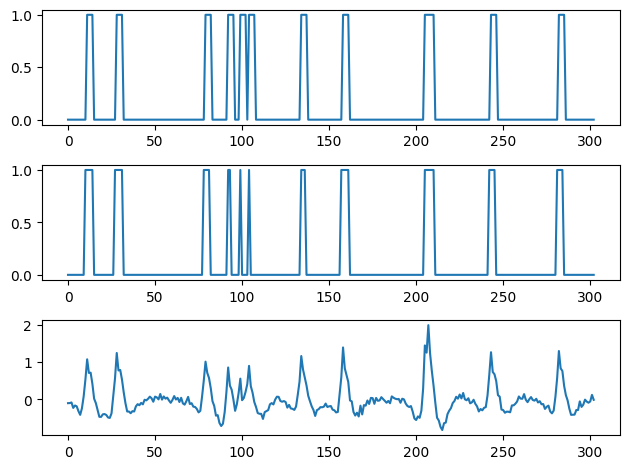

[I 2023-09-13 13:21:06,419] A new study created in memory with name: no-name-3558ff3a-2691-4f24-b410-3fdc8acaddb8
[I 2023-09-13 13:21:06,456] Trial 0 finished with value: 0.7164179104477612 and parameters: {'model': 'svm_linear', 'C': 0.9764100019240096}. Best is trial 0 with value: 0.7164179104477612.
[I 2023-09-13 13:21:06,472] Trial 1 finished with value: 0.7164179104477612 and parameters: {'model': 'logistic', 'C': 5.337755336709809}. Best is trial 0 with value: 0.7164179104477612.


On y_hat
running tuna study on metric


[I 2023-09-13 13:21:06,596] Trial 2 finished with value: 0.6956521739130435 and parameters: {'model': 'svm_linear', 'C': 25.570746780495032}. Best is trial 0 with value: 0.7164179104477612.
[I 2023-09-13 13:21:06,697] Trial 3 finished with value: 0.6956521739130435 and parameters: {'model': 'svm_linear', 'C': 21.455404037789883}. Best is trial 0 with value: 0.7164179104477612.
[I 2023-09-13 13:21:06,740] Trial 4 finished with value: 0.7058823529411764 and parameters: {'model': 'svm_linear', 'C': 1.9650335923751603}. Best is trial 0 with value: 0.7164179104477612.
[I 2023-09-13 13:21:06,758] Trial 5 finished with value: 0.696969696969697 and parameters: {'model': 'logistic', 'C': 2.3421910973107893}. Best is trial 0 with value: 0.7164179104477612.
[I 2023-09-13 13:21:06,772] Trial 6 finished with value: 0.696969696969697 and parameters: {'model': 'logistic', 'C': 2.2142671963129246}. Best is trial 0 with value: 0.7164179104477612.
[I 2023-09-13 13:21:06,786] Trial 7 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.9764100019240096}
Best Validation Set Accuracy: 0.7164179104477612
Test Set Accuracy: 0.7777777777777779


[I 2023-09-13 13:21:07,571] Trial 0 finished with value: 0.6956521739130435 and parameters: {'model': 'svm_linear', 'C': 93.8150375657306}. Best is trial 0 with value: 0.6956521739130435.
[I 2023-09-13 13:21:07,588] Trial 1 finished with value: 0.6774193548387099 and parameters: {'model': 'logistic', 'C': 0.39194005284378713}. Best is trial 0 with value: 0.6956521739130435.
[I 2023-09-13 13:21:07,624] Trial 2 finished with value: 0.6865671641791045 and parameters: {'model': 'svm_linear', 'C': 0.44305996933980096}. Best is trial 0 with value: 0.6956521739130435.
[I 2023-09-13 13:21:07,638] Trial 3 finished with value: 0.6885245901639345 and parameters: {'model': 'logistic', 'C': 0.3135495266654575}. Best is trial 0 with value: 0.6956521739130435.
[I 2023-09-13 13:21:07,655] Trial 4 finished with value: 0.676470588235294 and parameters: {'model': 'logistic', 'C': 51.96261862974092}. Best is trial 0 with value: 0.6956521739130435.
[I 2023-09-13 13:21:07,694] Trial 5 finished with value: 0

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.4773325692134705}
Best Validation Set Accuracy: 0.6984126984126985
Test Set Accuracy: 0.7741935483870968


[I 2023-09-13 13:21:08,783] Trial 3 finished with value: 0.6571428571428571 and parameters: {'model': 'svm_linear', 'C': 85.56646100727899}. Best is trial 3 with value: 0.6571428571428571.
[I 2023-09-13 13:21:08,824] Trial 4 finished with value: 0.6874999999999999 and parameters: {'model': 'svm_linear', 'C': 0.14586794575351772}. Best is trial 4 with value: 0.6874999999999999.
[I 2023-09-13 13:21:08,874] Trial 5 finished with value: 0.2608695652173913 and parameters: {'model': 'svm_linear', 'C': 0.015942418290352495}. Best is trial 4 with value: 0.6874999999999999.
[I 2023-09-13 13:21:08,890] Trial 6 finished with value: 0.6666666666666666 and parameters: {'model': 'logistic', 'C': 46.28639074728281}. Best is trial 4 with value: 0.6874999999999999.
[I 2023-09-13 13:21:08,906] Trial 7 finished with value: 0.6666666666666666 and parameters: {'model': 'logistic', 'C': 27.129558988736292}. Best is trial 4 with value: 0.6874999999999999.
[I 2023-09-13 13:21:08,945] Trial 8 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.09851317447729757}
Best Validation Set Accuracy: 0.6984126984126985
Test Set Accuracy: 0.7368421052631579


[I 2023-09-13 13:21:09,614] Trial 7 finished with value: 0.5714285714285715 and parameters: {'model': 'svm_linear', 'C': 0.03063035288678899}. Best is trial 1 with value: 0.676923076923077.
[I 2023-09-13 13:21:09,634] Trial 8 finished with value: 0.676923076923077 and parameters: {'model': 'logistic', 'C': 5.235467504984009}. Best is trial 1 with value: 0.676923076923077.
[I 2023-09-13 13:21:09,645] Trial 9 finished with value: 0.33333333333333337 and parameters: {'model': 'logistic', 'C': 0.055042495366888086}. Best is trial 1 with value: 0.676923076923077.
[I 2023-09-13 13:21:09,685] Trial 10 finished with value: 0.676923076923077 and parameters: {'model': 'svm_linear', 'C': 0.23836195629815218}. Best is trial 1 with value: 0.676923076923077.
[I 2023-09-13 13:21:09,724] Trial 11 finished with value: 0.6562500000000001 and parameters: {'model': 'svm_linear', 'C': 0.6282851113475133}. Best is trial 1 with value: 0.676923076923077.
[I 2023-09-13 13:21:09,767] Trial 12 finished with valu

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.5822527932946713}
Best Validation Set Accuracy: 0.676923076923077
Test Set Accuracy: 0.5957446808510638


[I 2023-09-13 13:21:10,435] Trial 0 finished with value: 0.7246376811594203 and parameters: {'model': 'svm_linear', 'C': 49.93142975952745}. Best is trial 0 with value: 0.7246376811594203.
[I 2023-09-13 13:21:10,469] Trial 1 finished with value: 0.7164179104477612 and parameters: {'model': 'svm_linear', 'C': 1.1462831928553483}. Best is trial 0 with value: 0.7246376811594203.
[I 2023-09-13 13:21:10,481] Trial 2 finished with value: 0.04878048780487806 and parameters: {'model': 'logistic', 'C': 0.015881750244256306}. Best is trial 0 with value: 0.7246376811594203.
[I 2023-09-13 13:21:10,522] Trial 3 finished with value: 0.71875 and parameters: {'model': 'svm_linear', 'C': 0.1347811280453259}. Best is trial 0 with value: 0.7246376811594203.
[I 2023-09-13 13:21:10,538] Trial 4 finished with value: 0.6440677966101694 and parameters: {'model': 'logistic', 'C': 0.3340855782719194}. Best is trial 0 with value: 0.7246376811594203.
[I 2023-09-13 13:21:10,555] Trial 5 finished with value: 0.7058

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 49.93142975952745}
Best Validation Set Accuracy: 0.7246376811594203
Test Set Accuracy: 0.6216216216216216


[I 2023-09-13 13:21:13,398] Trial 4 finished with value: 0.6557377049180327 and parameters: {'model': 'svm_linear', 'C': 0.07598608551044746}. Best is trial 2 with value: 0.6956521739130435.
[I 2023-09-13 13:21:13,411] Trial 5 finished with value: 0.4615384615384615 and parameters: {'model': 'logistic', 'C': 0.09790074674915013}. Best is trial 2 with value: 0.6956521739130435.
[I 2023-09-13 13:21:13,421] Trial 6 finished with value: 0.18181818181818182 and parameters: {'model': 'logistic', 'C': 0.033481949224128095}. Best is trial 2 with value: 0.6956521739130435.
[I 2023-09-13 13:21:13,434] Trial 7 finished with value: 0.6885245901639345 and parameters: {'model': 'logistic', 'C': 0.2694225802653258}. Best is trial 2 with value: 0.6956521739130435.
[I 2023-09-13 13:21:13,471] Trial 8 finished with value: 0.6567164179104479 and parameters: {'model': 'svm_linear', 'C': 1.196669545438093}. Best is trial 2 with value: 0.6956521739130435.
[I 2023-09-13 13:21:13,508] Trial 9 finished with va

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 16.962613438328205}
Best Validation Set Accuracy: 0.6956521739130435
Test Set Accuracy: 0.8695652173913043


[I 2023-09-13 13:21:15,212] Trial 5 finished with value: 0.6874999999999999 and parameters: {'model': 'svm_linear', 'C': 0.10706145156221815}. Best is trial 0 with value: 0.6874999999999999.
[I 2023-09-13 13:21:15,223] Trial 6 finished with value: 0.04878048780487806 and parameters: {'model': 'logistic', 'C': 0.017305450085050068}. Best is trial 0 with value: 0.6874999999999999.
[I 2023-09-13 13:21:15,240] Trial 7 finished with value: 0.6956521739130435 and parameters: {'model': 'logistic', 'C': 6.324131955761622}. Best is trial 7 with value: 0.6956521739130435.
[I 2023-09-13 13:21:15,381] Trial 8 finished with value: 0.6857142857142857 and parameters: {'model': 'svm_linear', 'C': 38.45810869215813}. Best is trial 7 with value: 0.6956521739130435.
[I 2023-09-13 13:21:15,396] Trial 9 finished with value: 0.6874999999999999 and parameters: {'model': 'logistic', 'C': 0.539367490800696}. Best is trial 7 with value: 0.6956521739130435.
[I 2023-09-13 13:21:15,418] Trial 10 finished with valu

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 5.890362717398231}
Best Validation Set Accuracy: 0.7042253521126761
Test Set Accuracy: 0.810126582278481


[I 2023-09-13 13:21:16,211] Trial 4 finished with value: 0.6857142857142857 and parameters: {'model': 'svm_linear', 'C': 61.83302907956747}. Best is trial 4 with value: 0.6857142857142857.
[I 2023-09-13 13:21:16,233] Trial 5 finished with value: 0.6567164179104479 and parameters: {'model': 'logistic', 'C': 85.45185559431688}. Best is trial 4 with value: 0.6857142857142857.
[I 2023-09-13 13:21:16,358] Trial 6 finished with value: 0.6956521739130435 and parameters: {'model': 'svm_linear', 'C': 34.57758802556501}. Best is trial 6 with value: 0.6956521739130435.
[I 2023-09-13 13:21:16,373] Trial 7 finished with value: 0.4615384615384615 and parameters: {'model': 'logistic', 'C': 0.11277654069141092}. Best is trial 6 with value: 0.6956521739130435.
[I 2023-09-13 13:21:16,411] Trial 8 finished with value: 0.6666666666666667 and parameters: {'model': 'svm_linear', 'C': 0.1564624734392255}. Best is trial 6 with value: 0.6956521739130435.
[I 2023-09-13 13:21:16,427] Trial 9 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 13.76310046866694}
Best Validation Set Accuracy: 0.7058823529411764
Test Set Accuracy: 0.7076923076923076


[I 2023-09-13 13:21:17,895] Trial 10 finished with value: 0.676470588235294 and parameters: {'model': 'svm_linear', 'C': 57.1301056561232}. Best is trial 1 with value: 0.6984126984126985.
[I 2023-09-13 13:21:17,948] Trial 11 finished with value: 0.6984126984126985 and parameters: {'model': 'svm_linear', 'C': 0.09071577693070383}. Best is trial 1 with value: 0.6984126984126985.
[I 2023-09-13 13:21:17,999] Trial 12 finished with value: 0.6874999999999999 and parameters: {'model': 'svm_linear', 'C': 0.16245421204040245}. Best is trial 1 with value: 0.6984126984126985.
[I 2023-09-13 13:21:18,044] Trial 13 finished with value: 0.676923076923077 and parameters: {'model': 'svm_linear', 'C': 0.1886346783338685}. Best is trial 1 with value: 0.6984126984126985.
[I 2023-09-13 13:21:18,092] Trial 14 finished with value: 0.18181818181818182 and parameters: {'model': 'svm_linear', 'C': 0.011911704061976816}. Best is trial 1 with value: 0.6984126984126985.
[I 2023-09-13 13:21:18,133] Trial 15 finishe

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.4122007284686065}
Best Validation Set Accuracy: 0.6984126984126985
Test Set Accuracy: 0.72


[I 2023-09-13 13:21:18,945] Trial 5 finished with value: 0.823529411764706 and parameters: {'model': 'svm_linear', 'C': 87.19426983343224}. Best is trial 2 with value: 0.875.
[I 2023-09-13 13:21:18,990] Trial 6 finished with value: 0.47619047619047616 and parameters: {'model': 'svm_linear', 'C': 0.02317043530520155}. Best is trial 2 with value: 0.875.
[I 2023-09-13 13:21:19,112] Trial 7 finished with value: 0.823529411764706 and parameters: {'model': 'svm_linear', 'C': 13.72505156101967}. Best is trial 2 with value: 0.875.
[I 2023-09-13 13:21:19,157] Trial 8 finished with value: 0.72 and parameters: {'model': 'svm_linear', 'C': 0.07049223579599245}. Best is trial 2 with value: 0.875.
[I 2023-09-13 13:21:19,176] Trial 9 finished with value: 0.8666666666666666 and parameters: {'model': 'logistic', 'C': 7.3300714055566445}. Best is trial 2 with value: 0.875.
[I 2023-09-13 13:21:19,196] Trial 10 finished with value: 0.8275862068965517 and parameters: {'model': 'logistic', 'C': 4.0871392945

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 15.935681742462906}
Best Validation Set Accuracy: 0.875
Test Set Accuracy: 0.7160493827160495


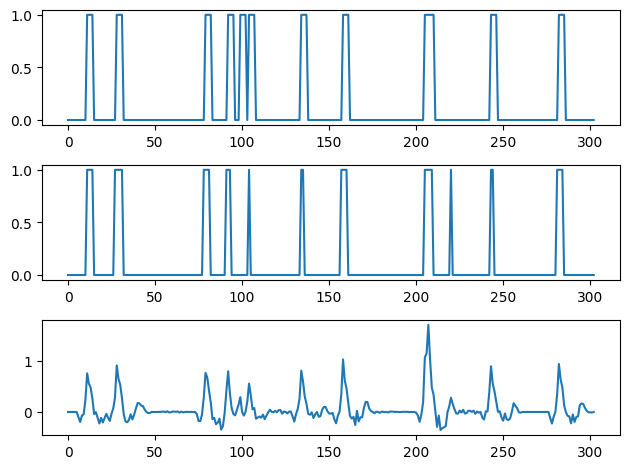

C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_14744\266028130.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
[I 2023-09-13 13:21:19,902] A new study created in memory with name: no-name-1c39a279-aefb-4553-a616-fad825e6e7e6
[I 2023-09-13 13:21:19,920] Trial 0 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.5262533519081339}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:19,933] Trial 1 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 7.327754538843392}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:19,946] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 37.290016944576095}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21

For SNR = 20
On x
running tuna study on metric


[I 2023-09-13 13:21:20,089] Trial 12 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 9.426975244750276}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,105] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 95.40995469738819}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,122] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 5.805787587215017}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,138] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.45763319410149245}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,155] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 3.5170070164332516}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,173] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 17.5073188566682}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,188] Trial 18 finished with

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.5262533519081339}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:21:20,412] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 68.46092435010287}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,424] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.42452887291067043}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,440] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 4.258082813594216}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,456] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 99.70079231633584}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,471] Trial 19 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.7031714707348312}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:20,482] A new study created in memory with name: no-name-40d3188a-78a0-451c-bb92-f8ed1c3e9c4b
[I 2023-09-13 13:21:20,492] Trial 0 finished with value: 0.0 and parameters: {'mode

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.20774622076794053}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:21:20,675] Trial 12 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.430393037294165}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:21:20,693] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 4.128880038236101}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:21:20,709] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.1272044546263298}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:21:20,728] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.6833788185045323}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:21:20,742] Trial 16 finished with value: 0.16666666666666669 and parameters: {'model': 'logistic', 'C': 0.033875329166555945}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:21:20,756] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.24021075329538233}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:21:20,

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.15370680294316255}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:21:20,997] Trial 11 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.570047279298618}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,016] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.0804992523385424}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,037] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 11.090317724781473}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,056] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.7514010222888827}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,076] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 6.841861108605352}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,095] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.9705290296895671}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,105] Trial 17

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 6.844280999224999}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:21:21,374] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.07253507261454088}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,390] Trial 14 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.010236087957089197}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,414] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.08692499227860753}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,426] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 4.5774360115706125}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,450] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.05640049997907005}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,470] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 79.27541340345404}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,486] Trial 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.06708898938469832}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:21:21,694] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.2529419446646431}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,710] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.05724874454439799}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,727] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.5529530584349012}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,741] Trial 17 finished with value: 0.7777777777777778 and parameters: {'model': 'logistic', 'C': 0.039532755324183176}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,756] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.3585967715967134}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,774] Trial 19 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 10.878684299898966}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:21,788] 

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 1.269874977349273}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:21:21,997] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.3040871007933093}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,010] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 26.4055512355029}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,021] Trial 19 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.6243289062766286}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,030] A new study created in memory with name: no-name-2b6d5983-6ac8-4206-ad3a-509095453f88
[I 2023-09-13 13:21:22,049] Trial 0 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.06768807088239777}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,064] Trial 1 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 2.0678015865420196}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,078] Trial 2 finished with value: 1.0 and parameters: {'model':

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 10.01773351442472}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:21:22,228] Trial 12 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.9743228340849136}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,244] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.0323376076634987}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,267] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.07308226315945131}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,286] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 4.311960252412408}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,300] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.24401624620974696}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,319] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.05381562277776051}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,337] Trial 18 fin

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.06768807088239777}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:21:22,556] Trial 12 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.7108493487353647}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,574] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 4.810186335871068}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,592] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 54.557126722274745}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,609] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 15.687561506542485}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,626] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.8783271546869366}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,644] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 6.770381346577221}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,655] Trial 18 finished wi

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.11444897236075444}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:21:22,875] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 6.731129113761851}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,889] Trial 17 finished with value: 0.4 and parameters: {'model': 'logistic', 'C': 0.03809984557254421}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,906] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 2.4443443675681684}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:21:22,920] Trial 19 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.38930533985884286}. Best is trial 0 with value: 1.0.


Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 7.778935103704961}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


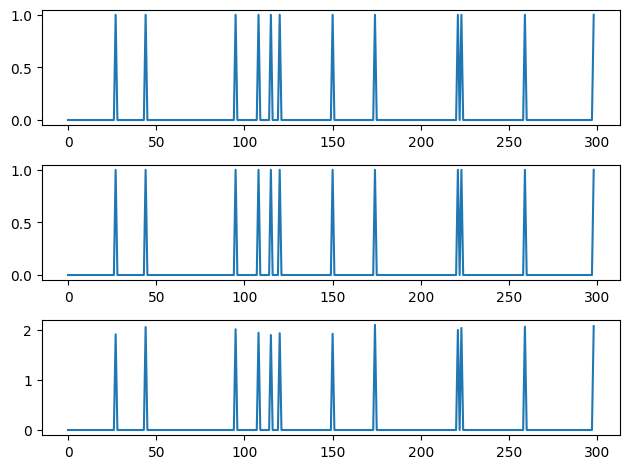

[I 2023-09-13 13:21:23,197] A new study created in memory with name: no-name-00a83257-aab1-47e1-a2d4-eb76dca949b3
[I 2023-09-13 13:21:23,214] Trial 0 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 3.702473081103654}. Best is trial 0 with value: 0.7887323943661972.
[I 2023-09-13 13:21:23,280] Trial 1 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 6.204616371700275}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:21:23,320] Trial 2 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 0.11606538336997381}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:21:23,336] Trial 3 finished with value: 0.7076923076923077 and parameters: {'model': 'logistic', 'C': 0.49092205189488325}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:21:23,351] Trial 4 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 5.851111181

On y
running tuna study on metric


[I 2023-09-13 13:21:23,385] Trial 5 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 0.32910986590198776}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:21:23,430] Trial 6 finished with value: 0.6557377049180327 and parameters: {'model': 'svm_linear', 'C': 0.019858094683854983}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:21:23,443] Trial 7 finished with value: 0.7076923076923077 and parameters: {'model': 'logistic', 'C': 0.478551685500939}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:21:23,715] Trial 8 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 18.218184779205508}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:21:23,750] Trial 9 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 0.28591764372647144}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:21:25,012] Trial 10 finished wit

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.1695032908572283}
Best Validation Set Accuracy: 0.8266666666666667
Test Set Accuracy: 0.7796610169491526


[I 2023-09-13 13:21:27,717] Trial 7 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 9.613057110266952}. Best is trial 0 with value: 0.7894736842105262.
[I 2023-09-13 13:21:27,762] Trial 8 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 2.395601593660947}. Best is trial 8 with value: 0.7999999999999999.
[I 2023-09-13 13:21:27,861] Trial 9 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 4.864621425090976}. Best is trial 8 with value: 0.7999999999999999.
[I 2023-09-13 13:21:28,816] Trial 10 finished with value: 0.8051948051948051 and parameters: {'model': 'svm_linear', 'C': 72.23566124198878}. Best is trial 10 with value: 0.8051948051948051.
[I 2023-09-13 13:21:29,462] Trial 11 finished with value: 0.8051948051948051 and parameters: {'model': 'svm_linear', 'C': 79.82313216240873}. Best is trial 10 with value: 0.8051948051948051.
[I 2023-09-13 13:21:31,080] Trial 12 finished with value: 0.8051948

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 72.23566124198878}
Best Validation Set Accuracy: 0.8051948051948051
Test Set Accuracy: 0.7499999999999999


[I 2023-09-13 13:21:35,065] Trial 1 finished with value: 0.7631578947368423 and parameters: {'model': 'svm_linear', 'C': 22.454582523605936}. Best is trial 1 with value: 0.7631578947368423.
[I 2023-09-13 13:21:35,073] Trial 2 finished with value: 0.6206896551724138 and parameters: {'model': 'logistic', 'C': 0.1052712656593801}. Best is trial 1 with value: 0.7631578947368423.
[I 2023-09-13 13:21:35,084] Trial 3 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 3.0602793529751304}. Best is trial 1 with value: 0.7631578947368423.
[I 2023-09-13 13:21:35,095] Trial 4 finished with value: 0.7999999999999999 and parameters: {'model': 'logistic', 'C': 85.8493114304115}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:21:35,164] Trial 5 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 5.035879350848017}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:21:35,176] Trial 6 finished with value: 0.67692307692307

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 85.8493114304115}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8115942028985507


[I 2023-09-13 13:21:36,056] Trial 2 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 12.115954369525825}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:21:36,102] Trial 3 finished with value: 0.6562500000000001 and parameters: {'model': 'svm_linear', 'C': 0.029151635336184232}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:21:36,675] Trial 4 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 44.77599332827661}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:21:36,695] Trial 5 finished with value: 0.7777777777777777 and parameters: {'model': 'logistic', 'C': 11.950814822766887}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:21:36,709] Trial 6 finished with value: 0.7777777777777777 and parameters: {'model': 'logistic', 'C': 5.103770334087438}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:21:36,751] Trial 7 finished with valu

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.5971601713216512}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.68


[I 2023-09-13 13:21:38,312] Trial 4 finished with value: 0.7466666666666666 and parameters: {'model': 'svm_linear', 'C': 18.494640211346002}. Best is trial 3 with value: 0.7567567567567567.
[I 2023-09-13 13:21:38,334] Trial 5 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 25.249399346695206}. Best is trial 3 with value: 0.7567567567567567.
[I 2023-09-13 13:21:38,367] Trial 6 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.5079434209194458}. Best is trial 3 with value: 0.7567567567567567.
[I 2023-09-13 13:21:38,408] Trial 7 finished with value: 0.6865671641791045 and parameters: {'model': 'svm_linear', 'C': 0.03376544520587928}. Best is trial 3 with value: 0.7567567567567567.
[I 2023-09-13 13:21:38,451] Trial 8 finished with value: 0.4 and parameters: {'model': 'svm_linear', 'C': 0.01005265230455339}. Best is trial 3 with value: 0.7567567567567567.
[I 2023-09-13 13:21:38,537] Trial 9 finished with value: 0.746666

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 80.86037240732404}
Best Validation Set Accuracy: 0.7894736842105262
Test Set Accuracy: 0.7105263157894737


[I 2023-09-13 13:21:40,650] Trial 2 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 12.92384068664596}. Best is trial 2 with value: 0.7567567567567567.
[I 2023-09-13 13:21:40,663] Trial 3 finished with value: 0.18181818181818182 and parameters: {'model': 'logistic', 'C': 0.017076233309331838}. Best is trial 2 with value: 0.7567567567567567.
[I 2023-09-13 13:21:40,673] Trial 4 finished with value: 0.13953488372093023 and parameters: {'model': 'logistic', 'C': 0.01423319947174498}. Best is trial 2 with value: 0.7567567567567567.
[I 2023-09-13 13:21:40,682] Trial 5 finished with value: 0.4615384615384615 and parameters: {'model': 'logistic', 'C': 0.03827223067992518}. Best is trial 2 with value: 0.7567567567567567.
[I 2023-09-13 13:21:41,532] Trial 6 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 79.65736294960891}. Best is trial 2 with value: 0.7567567567567567.
[I 2023-09-13 13:21:41,660] Trial 7 finished with value: 0.7567567

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.5085204478469553}
Best Validation Set Accuracy: 0.7631578947368423
Test Set Accuracy: 0.8636363636363636


[I 2023-09-13 13:21:44,355] Trial 3 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 28.843866072023943}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:21:44,366] Trial 4 finished with value: 0.4905660377358491 and parameters: {'model': 'logistic', 'C': 0.050832843172329556}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:21:44,375] Trial 5 finished with value: 0.2978723404255319 and parameters: {'model': 'logistic', 'C': 0.02300365556968481}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:21:44,383] Trial 6 finished with value: 0.5185185185185185 and parameters: {'model': 'logistic', 'C': 0.07013536290943012}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:21:44,490] Trial 7 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 7.608698302050152}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:21:44,525] Trial 8 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.8486001895300487}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.8205128205128205


[I 2023-09-13 13:21:45,280] Trial 3 finished with value: 0.676470588235294 and parameters: {'model': 'logistic', 'C': 0.6809771968793458}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:21:45,291] Trial 4 finished with value: 0.6562500000000001 and parameters: {'model': 'logistic', 'C': 0.38241175273014905}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:21:45,510] Trial 5 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 25.61540186474502}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:21:45,556] Trial 6 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 2.4601366699209564}. Best is trial 6 with value: 0.7733333333333333.
[I 2023-09-13 13:21:45,571] Trial 7 finished with value: 0.676470588235294 and parameters: {'model': 'logistic', 'C': 0.9414077343668227}. Best is trial 6 with value: 0.7733333333333333.
[I 2023-09-13 13:21:45,679] Trial 8 finished with value: 0

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 4.396285038813993}
Best Validation Set Accuracy: 0.7837837837837837
Test Set Accuracy: 0.7384615384615385


[I 2023-09-13 13:21:47,304] Trial 7 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 23.538071421839057}. Best is trial 7 with value: 0.8157894736842106.
[I 2023-09-13 13:21:47,314] Trial 8 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 1.0664766446272962}. Best is trial 7 with value: 0.8157894736842106.
[I 2023-09-13 13:21:47,326] Trial 9 finished with value: 0.7567567567567567 and parameters: {'model': 'logistic', 'C': 14.795896420349411}. Best is trial 7 with value: 0.8157894736842106.
[I 2023-09-13 13:21:48,046] Trial 10 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 96.12583973522717}. Best is trial 7 with value: 0.8157894736842106.
[I 2023-09-13 13:21:48,887] Trial 11 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 67.07219839876679}. Best is trial 7 with value: 0.8157894736842106.
[I 2023-09-13 13:21:50,351] Trial 12 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 23.538071421839057}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.9142857142857143


[I 2023-09-13 13:21:54,056] Trial 8 finished with value: 0.8823529411764706 and parameters: {'model': 'svm_linear', 'C': 11.897741897525089}. Best is trial 3 with value: 0.9411764705882353.
[I 2023-09-13 13:21:54,075] Trial 9 finished with value: 0.8387096774193549 and parameters: {'model': 'logistic', 'C': 0.9062627735301215}. Best is trial 3 with value: 0.9411764705882353.
[I 2023-09-13 13:21:54,912] Trial 10 finished with value: 0.8823529411764706 and parameters: {'model': 'svm_linear', 'C': 93.6094915639745}. Best is trial 3 with value: 0.9411764705882353.
[I 2023-09-13 13:21:54,933] Trial 11 finished with value: 0.9411764705882353 and parameters: {'model': 'logistic', 'C': 12.413251385874458}. Best is trial 3 with value: 0.9411764705882353.
[I 2023-09-13 13:21:54,951] Trial 12 finished with value: 0.9411764705882353 and parameters: {'model': 'logistic', 'C': 14.916160686857607}. Best is trial 3 with value: 0.9411764705882353.
[I 2023-09-13 13:21:54,971] Trial 13 finished with valu

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 7.592342066492697}
Best Validation Set Accuracy: 0.9411764705882353
Test Set Accuracy: 0.761904761904762


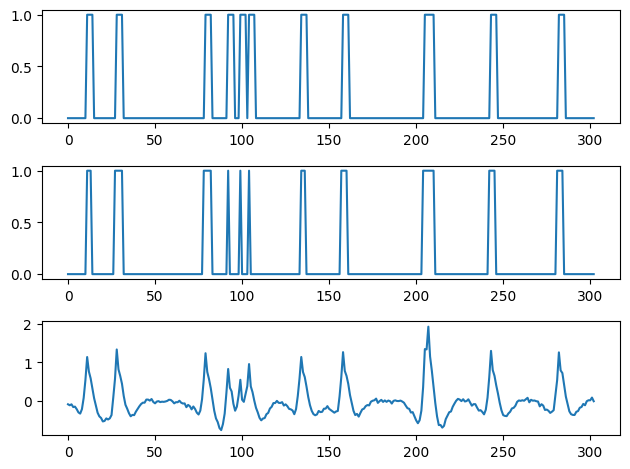

[I 2023-09-13 13:21:56,557] A new study created in memory with name: no-name-35ed9e21-e64a-4a02-b5ac-a82a678e27f8
[I 2023-09-13 13:21:56,596] Trial 0 finished with value: 0.6562500000000001 and parameters: {'model': 'svm_linear', 'C': 0.08129240250076858}. Best is trial 0 with value: 0.6562500000000001.
[I 2023-09-13 13:21:56,655] Trial 1 finished with value: 0.7323943661971831 and parameters: {'model': 'svm_linear', 'C': 8.503480542112982}. Best is trial 1 with value: 0.7323943661971831.
[I 2023-09-13 13:21:56,673] Trial 2 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 74.34439546873745}. Best is trial 2 with value: 0.75.


On y_hat
running tuna study on metric


[I 2023-09-13 13:21:56,869] Trial 3 finished with value: 0.7428571428571429 and parameters: {'model': 'svm_linear', 'C': 45.62478297736715}. Best is trial 2 with value: 0.75.
[I 2023-09-13 13:21:56,910] Trial 4 finished with value: 0.6666666666666667 and parameters: {'model': 'svm_linear', 'C': 0.06756701649823631}. Best is trial 2 with value: 0.75.
[I 2023-09-13 13:21:56,953] Trial 5 finished with value: 0.4905660377358491 and parameters: {'model': 'svm_linear', 'C': 0.019182667952895475}. Best is trial 2 with value: 0.75.
[I 2023-09-13 13:21:57,022] Trial 6 finished with value: 0.7323943661971831 and parameters: {'model': 'svm_linear', 'C': 10.572080033113538}. Best is trial 2 with value: 0.75.
[I 2023-09-13 13:21:57,057] Trial 7 finished with value: 0.7428571428571429 and parameters: {'model': 'svm_linear', 'C': 0.8729244970218453}. Best is trial 2 with value: 0.75.
[I 2023-09-13 13:21:57,075] Trial 8 finished with value: 0.7246376811594203 and parameters: {'model': 'logistic', 'C':

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 74.34439546873745}
Best Validation Set Accuracy: 0.75
Test Set Accuracy: 0.7457627118644068


[I 2023-09-13 13:21:57,821] Trial 5 finished with value: 0.2978723404255319 and parameters: {'model': 'logistic', 'C': 0.03131344923686843}. Best is trial 2 with value: 0.7297297297297296.
[I 2023-09-13 13:21:57,863] Trial 6 finished with value: 0.6206896551724138 and parameters: {'model': 'svm_linear', 'C': 0.030282664798817225}. Best is trial 2 with value: 0.7297297297297296.
[I 2023-09-13 13:21:57,900] Trial 7 finished with value: 0.6666666666666666 and parameters: {'model': 'svm_linear', 'C': 0.0401912476560332}. Best is trial 2 with value: 0.7297297297297296.
[I 2023-09-13 13:21:57,914] Trial 8 finished with value: 0.6666666666666667 and parameters: {'model': 'logistic', 'C': 0.862073097789815}. Best is trial 2 with value: 0.7297297297297296.
[I 2023-09-13 13:21:57,925] Trial 9 finished with value: 0.4615384615384615 and parameters: {'model': 'logistic', 'C': 0.06152379511021011}. Best is trial 2 with value: 0.7297297297297296.
[I 2023-09-13 13:21:58,522] Trial 10 finished with va

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.46670854986255256}
Best Validation Set Accuracy: 0.75
Test Set Accuracy: 0.8333333333333334


[I 2023-09-13 13:21:59,082] Trial 5 finished with value: 0.7123287671232875 and parameters: {'model': 'svm_linear', 'C': 8.25770911847732}. Best is trial 3 with value: 0.7397260273972603.
[I 2023-09-13 13:21:59,123] Trial 6 finished with value: 0.5964912280701754 and parameters: {'model': 'svm_linear', 'C': 0.026454775431206844}. Best is trial 3 with value: 0.7397260273972603.
[I 2023-09-13 13:21:59,136] Trial 7 finished with value: 0.13953488372093023 and parameters: {'model': 'logistic', 'C': 0.02308825406670781}. Best is trial 3 with value: 0.7397260273972603.
[I 2023-09-13 13:21:59,149] Trial 8 finished with value: 0.696969696969697 and parameters: {'model': 'logistic', 'C': 0.6311824418290185}. Best is trial 3 with value: 0.7397260273972603.
[I 2023-09-13 13:21:59,187] Trial 9 finished with value: 0.7042253521126761 and parameters: {'model': 'svm_linear', 'C': 3.756088076989531}. Best is trial 3 with value: 0.7397260273972603.
[I 2023-09-13 13:21:59,368] Trial 10 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 92.57695502879672}
Best Validation Set Accuracy: 0.7631578947368423
Test Set Accuracy: 0.7647058823529412


[I 2023-09-13 13:22:03,012] Trial 0 finished with value: 0.6666666666666667 and parameters: {'model': 'svm_linear', 'C': 87.31787504762346}. Best is trial 0 with value: 0.6666666666666667.
[I 2023-09-13 13:22:03,023] Trial 1 finished with value: 0.13953488372093023 and parameters: {'model': 'logistic', 'C': 0.025645842031421905}. Best is trial 0 with value: 0.6666666666666667.
[I 2023-09-13 13:22:03,038] Trial 2 finished with value: 0.6461538461538462 and parameters: {'model': 'logistic', 'C': 1.584970439458708}. Best is trial 0 with value: 0.6666666666666667.
[I 2023-09-13 13:22:03,072] Trial 3 finished with value: 0.676923076923077 and parameters: {'model': 'svm_linear', 'C': 0.3171422117635237}. Best is trial 3 with value: 0.676923076923077.
[I 2023-09-13 13:22:03,088] Trial 4 finished with value: 0.6666666666666667 and parameters: {'model': 'logistic', 'C': 2.503059103475432}. Best is trial 3 with value: 0.676923076923077.
[I 2023-09-13 13:22:03,098] Trial 5 finished with value: 0.

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 4.678059723552017}
Best Validation Set Accuracy: 0.6865671641791045
Test Set Accuracy: 0.68


[I 2023-09-13 13:22:04,109] Trial 0 finished with value: 0.72 and parameters: {'model': 'svm_linear', 'C': 74.38349488484492}. Best is trial 0 with value: 0.72.
[I 2023-09-13 13:22:04,126] Trial 1 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 81.48233477917142}. Best is trial 1 with value: 0.7428571428571429.
[I 2023-09-13 13:22:04,143] Trial 2 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 15.943251621958085}. Best is trial 1 with value: 0.7428571428571429.
[I 2023-09-13 13:22:04,177] Trial 3 finished with value: 0.7323943661971831 and parameters: {'model': 'svm_linear', 'C': 0.2072214646560548}. Best is trial 1 with value: 0.7428571428571429.
[I 2023-09-13 13:22:04,210] Trial 4 finished with value: 0.7222222222222223 and parameters: {'model': 'svm_linear', 'C': 0.6212527154930984}. Best is trial 1 with value: 0.7428571428571429.
[I 2023-09-13 13:22:04,224] Trial 5 finished with value: 0.7058823529411764 and para

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 81.48233477917142}
Best Validation Set Accuracy: 0.7428571428571429
Test Set Accuracy: 0.7368421052631579


[I 2023-09-13 13:22:05,398] Trial 0 finished with value: 0.7142857142857143 and parameters: {'model': 'svm_linear', 'C': 79.3221231834778}. Best is trial 0 with value: 0.7142857142857143.
[I 2023-09-13 13:22:05,419] Trial 1 finished with value: 0.7142857142857143 and parameters: {'model': 'logistic', 'C': 6.315384672175913}. Best is trial 0 with value: 0.7142857142857143.
[I 2023-09-13 13:22:05,433] Trial 2 finished with value: 0.7058823529411764 and parameters: {'model': 'logistic', 'C': 1.7216106394112387}. Best is trial 0 with value: 0.7142857142857143.
[I 2023-09-13 13:22:05,449] Trial 3 finished with value: 0.7142857142857143 and parameters: {'model': 'logistic', 'C': 30.2058561746116}. Best is trial 0 with value: 0.7142857142857143.
[I 2023-09-13 13:22:05,460] Trial 4 finished with value: 0.33333333333333337 and parameters: {'model': 'logistic', 'C': 0.03860114952378313}. Best is trial 0 with value: 0.7142857142857143.
[I 2023-09-13 13:22:05,476] Trial 5 finished with value: 0.71

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 18.932775088308762}
Best Validation Set Accuracy: 0.7323943661971831
Test Set Accuracy: 0.8444444444444444


[I 2023-09-13 13:22:07,785] Trial 4 finished with value: 0.6956521739130435 and parameters: {'model': 'svm_linear', 'C': 8.474181977513892}. Best is trial 2 with value: 0.7323943661971831.
[I 2023-09-13 13:22:07,804] Trial 5 finished with value: 0.6956521739130435 and parameters: {'model': 'logistic', 'C': 9.943616859122523}. Best is trial 2 with value: 0.7323943661971831.
[I 2023-09-13 13:22:07,839] Trial 6 finished with value: 0.676056338028169 and parameters: {'model': 'svm_linear', 'C': 0.34621688934835504}. Best is trial 2 with value: 0.7323943661971831.
[I 2023-09-13 13:22:07,919] Trial 7 finished with value: 0.6857142857142857 and parameters: {'model': 'svm_linear', 'C': 11.005052405105534}. Best is trial 2 with value: 0.7323943661971831.
[I 2023-09-13 13:22:07,943] Trial 8 finished with value: 0.6865671641791045 and parameters: {'model': 'logistic', 'C': 3.068885855618846}. Best is trial 2 with value: 0.7323943661971831.
[I 2023-09-13 13:22:07,956] Trial 9 finished with value: 

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 52.56159489458651}
Best Validation Set Accuracy: 0.7323943661971831
Test Set Accuracy: 0.8433734939759036


[I 2023-09-13 13:22:08,384] Trial 7 finished with value: 0.676923076923077 and parameters: {'model': 'logistic', 'C': 1.4749000176096605}. Best is trial 0 with value: 0.7222222222222223.
[I 2023-09-13 13:22:08,395] Trial 8 finished with value: 0.4313725490196079 and parameters: {'model': 'logistic', 'C': 0.056208283945525656}. Best is trial 0 with value: 0.7222222222222223.
[I 2023-09-13 13:22:08,405] Trial 9 finished with value: 0.4905660377358491 and parameters: {'model': 'logistic', 'C': 0.0851726643278039}. Best is trial 0 with value: 0.7222222222222223.
[I 2023-09-13 13:22:08,607] Trial 10 finished with value: 0.7222222222222223 and parameters: {'model': 'svm_linear', 'C': 48.08976865582556}. Best is trial 0 with value: 0.7222222222222223.
[I 2023-09-13 13:22:08,648] Trial 11 finished with value: 0.7246376811594203 and parameters: {'model': 'svm_linear', 'C': 7.424834379808883}. Best is trial 11 with value: 0.7246376811594203.
[I 2023-09-13 13:22:08,704] Trial 12 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 12.215070454102609}
Best Validation Set Accuracy: 0.7297297297297296
Test Set Accuracy: 0.7384615384615385


[I 2023-09-13 13:22:09,804] Trial 8 finished with value: 0.6885245901639345 and parameters: {'model': 'logistic', 'C': 0.2519515087283652}. Best is trial 7 with value: 0.7323943661971831.
[I 2023-09-13 13:22:09,822] Trial 9 finished with value: 0.7042253521126761 and parameters: {'model': 'logistic', 'C': 47.73387423147552}. Best is trial 7 with value: 0.7323943661971831.
[I 2023-09-13 13:22:09,900] Trial 10 finished with value: 0.7605633802816901 and parameters: {'model': 'svm_linear', 'C': 8.482159101884983}. Best is trial 10 with value: 0.7605633802816901.
[I 2023-09-13 13:22:09,977] Trial 11 finished with value: 0.7605633802816901 and parameters: {'model': 'svm_linear', 'C': 8.386869102358805}. Best is trial 10 with value: 0.7605633802816901.
[I 2023-09-13 13:22:10,063] Trial 12 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 10.521588150828036}. Best is trial 10 with value: 0.7605633802816901.
[I 2023-09-13 13:22:10,174] Trial 13 finished with value: 0.75 an

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 8.482159101884983}
Best Validation Set Accuracy: 0.7605633802816901
Test Set Accuracy: 0.8484848484848485


[I 2023-09-13 13:22:11,747] Trial 4 finished with value: 0.8484848484848485 and parameters: {'model': 'svm_linear', 'C': 14.600142858614507}. Best is trial 1 with value: 0.8484848484848485.
[I 2023-09-13 13:22:11,763] Trial 5 finished with value: 0.8387096774193549 and parameters: {'model': 'logistic', 'C': 6.033036803457449}. Best is trial 1 with value: 0.8484848484848485.
[I 2023-09-13 13:22:11,776] Trial 6 finished with value: 0.8387096774193549 and parameters: {'model': 'logistic', 'C': 3.46432458110298}. Best is trial 1 with value: 0.8484848484848485.
[I 2023-09-13 13:22:11,819] Trial 7 finished with value: 0.6666666666666666 and parameters: {'model': 'svm_linear', 'C': 0.03556372599514042}. Best is trial 1 with value: 0.8484848484848485.
[I 2023-09-13 13:22:11,833] Trial 8 finished with value: 0.8387096774193549 and parameters: {'model': 'logistic', 'C': 8.671283250048589}. Best is trial 1 with value: 0.8484848484848485.
[I 2023-09-13 13:22:11,872] Trial 9 finished with value: 0.

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 4.585472439024018}
Best Validation Set Accuracy: 0.8484848484848485
Test Set Accuracy: 0.7294117647058824


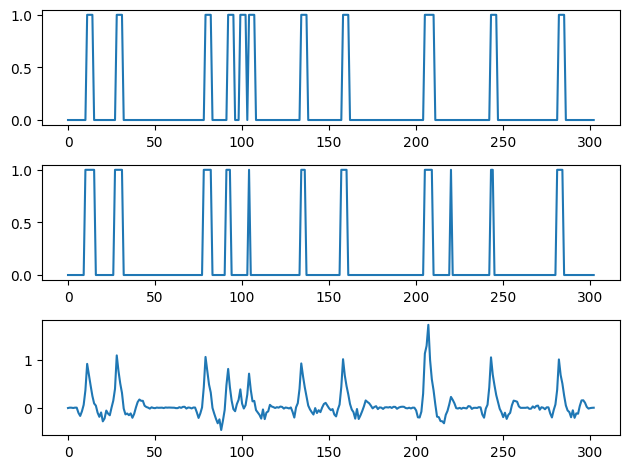

C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_14744\266028130.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
[I 2023-09-13 13:22:13,665] A new study created in memory with name: no-name-aecc5063-4476-4bf6-bcc0-8c3b90345061
[I 2023-09-13 13:22:13,675] Trial 0 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 6.070769141905689}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:13,680] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 18.55045367082569}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:13,687] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.06384573085632844}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:

For SNR = 25
On x
running tuna study on metric
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 6.070769141905689}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:22:13,864] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.9169841051689175}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:13,868] Trial 3 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 48.12647796342417}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:13,876] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.301743725163352}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:13,884] Trial 5 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 4.036584781005202}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:13,889] Trial 6 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 5.647589201718731}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:13,895] Trial 7 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.20284926617953733}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:13,900] Trial 8 finished with

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.307201816204229}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.0456748299410275}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:22:14,201] Trial 0 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.016048294407833754}. Best is trial 0 with value: 0.0.
[I 2023-09-13 13:22:14,208] Trial 1 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 10.589005353995116}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:22:14,216] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.024462662663730657}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:22:14,224] Trial 3 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 7.256546804671471}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:22:14,231] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 6.268298268386187}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:22:14,238] Trial 5 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.21776859578047297}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:22:14,246] Trial 6 finished wi

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 10.589005353995116}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.3285321195609494}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:22:14,561] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.08950368214996535}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,573] Trial 3 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.1051081733408632}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,584] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.38357550459081474}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,593] Trial 5 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.14148005834365546}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,605] Trial 6 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 3.0819693593639466}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,616] Trial 7 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.2042052275820883}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,628] Trial 8 finishe

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.10030752076365072}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 20.594631583552566}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:22:14,918] Trial 3 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 82.16101127777918}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,926] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 77.38331686442037}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,934] Trial 5 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 19.21058169797214}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,942] Trial 6 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 49.491960104592685}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,949] Trial 7 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.177627259754394}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,956] Trial 8 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 3.6528923749751567}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:14,967] Trial 9 finished with va

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.7819377847636625}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.2509052308891239}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:22:15,241] Trial 8 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 22.46706775429209}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:15,250] Trial 9 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.046723717839695166}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:15,256] Trial 10 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 75.62849063462043}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:15,262] Trial 11 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.6131284330836294}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:15,267] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 14.484486195890588}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:15,283] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.011102135344338293}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:15,288] Trial 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.742372309148461}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


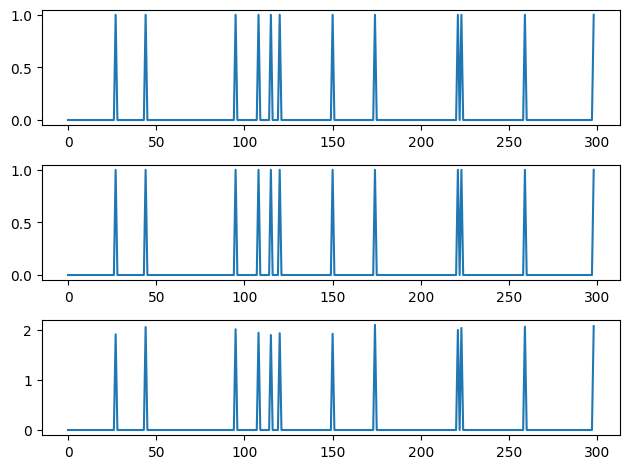

[I 2023-09-13 13:22:15,512] A new study created in memory with name: no-name-a6ec1538-810d-4447-96f6-417ac5a90db2
[I 2023-09-13 13:22:15,521] Trial 0 finished with value: 0.6984126984126985 and parameters: {'model': 'logistic', 'C': 0.2870962724068051}. Best is trial 0 with value: 0.6984126984126985.
[I 2023-09-13 13:22:15,530] Trial 1 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 10.294536698070937}. Best is trial 1 with value: 0.7887323943661972.
[I 2023-09-13 13:22:15,551] Trial 2 finished with value: 0.821917808219178 and parameters: {'model': 'svm_linear', 'C': 0.8019178722385064}. Best is trial 2 with value: 0.821917808219178.
[I 2023-09-13 13:22:15,558] Trial 3 finished with value: 0.7076923076923077 and parameters: {'model': 'logistic', 'C': 0.4831529233509349}. Best is trial 2 with value: 0.821917808219178.
[I 2023-09-13 13:22:15,562] Trial 4 finished with value: 0.36734693877551017 and parameters: {'model': 'logistic', 'C': 0.0259500331412

On y
running tuna study on metric


[I 2023-09-13 13:22:15,734] Trial 5 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 15.643655327732125}. Best is trial 2 with value: 0.821917808219178.
[I 2023-09-13 13:22:15,754] Trial 6 finished with value: 0.8378378378378379 and parameters: {'model': 'svm_linear', 'C': 1.0599388558708875}. Best is trial 6 with value: 0.8378378378378379.
[I 2023-09-13 13:22:15,760] Trial 7 finished with value: 0.5185185185185185 and parameters: {'model': 'logistic', 'C': 0.05683720728271289}. Best is trial 6 with value: 0.8378378378378379.
[I 2023-09-13 13:22:15,778] Trial 8 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 0.1340511921041267}. Best is trial 6 with value: 0.8378378378378379.
[I 2023-09-13 13:22:15,881] Trial 9 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 17.23200006941593}. Best is trial 6 with value: 0.8378378378378379.
[I 2023-09-13 13:22:15,907] Trial 10 finished with va

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.0599388558708875}
Best Validation Set Accuracy: 0.8378378378378379
Test Set Accuracy: 0.8070175438596492


[I 2023-09-13 13:22:16,626] Trial 1 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 34.12847254154357}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:22:16,637] Trial 2 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 1.5492664441096562}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:22:17,180] Trial 3 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 66.70213264813273}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:22:17,186] Trial 4 finished with value: 0.2222222222222222 and parameters: {'model': 'logistic', 'C': 0.018168597350191534}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:22:17,191] Trial 5 finished with value: 0.36734693877551017 and parameters: {'model': 'logistic', 'C': 0.025739152125100088}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:22:17,532] Trial 6 finished with value: 0.75675675

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.5680959803698044}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8648648648648649


[I 2023-09-13 13:22:18,084] Trial 3 finished with value: 0.7297297297297296 and parameters: {'model': 'svm_linear', 'C': 27.737327688417817}. Best is trial 1 with value: 0.7948717948717949.
[I 2023-09-13 13:22:18,106] Trial 4 finished with value: 0.7058823529411764 and parameters: {'model': 'svm_linear', 'C': 0.037844632676149376}. Best is trial 1 with value: 0.7948717948717949.
[I 2023-09-13 13:22:18,118] Trial 5 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 54.608289145353524}. Best is trial 1 with value: 0.7948717948717949.
[I 2023-09-13 13:22:18,308] Trial 6 finished with value: 0.7297297297297296 and parameters: {'model': 'svm_linear', 'C': 32.08563061537599}. Best is trial 1 with value: 0.7948717948717949.
[I 2023-09-13 13:22:18,460] Trial 7 finished with value: 0.7297297297297296 and parameters: {'model': 'svm_linear', 'C': 18.123979497319468}. Best is trial 1 with value: 0.7948717948717949.
[I 2023-09-13 13:22:18,469] Trial 8 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.2920619805477219}
Best Validation Set Accuracy: 0.8051948051948051
Test Set Accuracy: 0.8115942028985507


[I 2023-09-13 13:22:18,910] Trial 4 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 30.39679394697125}. Best is trial 0 with value: 0.8108108108108107.
[I 2023-09-13 13:22:18,935] Trial 5 finished with value: 0.6666666666666666 and parameters: {'model': 'svm_linear', 'C': 0.014184865145707975}. Best is trial 0 with value: 0.8108108108108107.
[I 2023-09-13 13:22:18,957] Trial 6 finished with value: 0.7397260273972603 and parameters: {'model': 'svm_linear', 'C': 0.22758874294901044}. Best is trial 0 with value: 0.8108108108108107.
[I 2023-09-13 13:22:18,980] Trial 7 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 1.2500238628079112}. Best is trial 0 with value: 0.8108108108108107.
[I 2023-09-13 13:22:18,991] Trial 8 finished with value: 0.5185185185185185 and parameters: {'model': 'logistic', 'C': 0.05822101657941638}. Best is trial 0 with value: 0.8108108108108107.
[I 2023-09-13 13:22:19,013] Trial 9 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 21.323425426075634}
Best Validation Set Accuracy: 0.8108108108108107
Test Set Accuracy: 0.6923076923076924


[I 2023-09-13 13:22:20,024] Trial 2 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 66.68348667635429}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:22:20,034] Trial 3 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 18.78751619402808}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:22:20,068] Trial 4 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 4.477247375343939}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:22:20,271] Trial 5 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 30.7344282257785}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:22:20,282] Trial 6 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 41.37081042032383}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:22:20,293] Trial 7 finished with value: 0.7

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 66.68348667635429}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.7499999999999999


[I 2023-09-13 13:22:23,707] Trial 11 finished with value: 0.7466666666666666 and parameters: {'model': 'svm_linear', 'C': 2.729807252425344}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:22:23,728] Trial 12 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.21572315604807518}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:22:23,749] Trial 13 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.2651252808075528}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:22:23,770] Trial 14 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.28686861623407156}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:22:23,793] Trial 15 finished with value: 0.7222222222222223 and parameters: {'model': 'svm_linear', 'C': 0.07688142180737033}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:22:23,815] Trial 16 finish

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.0418367168871812}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.888888888888889


[I 2023-09-13 13:22:24,157] Trial 3 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 21.829806936635503}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:22:24,174] Trial 4 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 0.3730646171705748}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:22:24,181] Trial 5 finished with value: 0.6206896551724138 and parameters: {'model': 'logistic', 'C': 0.10044058166462949}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:22:24,189] Trial 6 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 3.689040509085329}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:22:24,197] Trial 7 finished with value: 0.6865671641791045 and parameters: {'model': 'logistic', 'C': 0.707751883652598}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:22:24,206] Trial 8 finished with value: 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.5074230593390423}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.8292682926829269


[I 2023-09-13 13:22:25,902] Trial 10 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 84.90944597703152}. Best is trial 9 with value: 0.8157894736842106.
[I 2023-09-13 13:22:26,257] Trial 11 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 79.36359452579238}. Best is trial 9 with value: 0.8157894736842106.
[I 2023-09-13 13:22:26,321] Trial 12 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 6.316775948062222}. Best is trial 12 with value: 0.8266666666666667.
[I 2023-09-13 13:22:26,370] Trial 13 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 6.332604858506769}. Best is trial 12 with value: 0.8266666666666667.
[I 2023-09-13 13:22:26,436] Trial 14 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 9.303204338934957}. Best is trial 12 with value: 0.8266666666666667.
[I 2023-09-13 13:22:26,523] Trial 15 finished w

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.5972965271745974}
Best Validation Set Accuracy: 0.8311688311688312
Test Set Accuracy: 0.7575757575757577


[I 2023-09-13 13:22:26,930] Trial 9 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 0.19490292268600926}. Best is trial 1 with value: 0.8157894736842106.
[I 2023-09-13 13:22:26,940] Trial 10 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 27.56658524008956}. Best is trial 1 with value: 0.8157894736842106.
[I 2023-09-13 13:22:27,008] Trial 11 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 8.657208978824007}. Best is trial 1 with value: 0.8157894736842106.
[I 2023-09-13 13:22:27,065] Trial 12 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 7.251870340026533}. Best is trial 1 with value: 0.8157894736842106.
[I 2023-09-13 13:22:27,629] Trial 13 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 97.73369909960806}. Best is trial 1 with value: 0.8157894736842106.
[I 2023-09-13 13:22:27,677] Trial 14 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.519009441643648}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.9142857142857143


[I 2023-09-13 13:22:28,082] Trial 2 finished with value: 0.8571428571428572 and parameters: {'model': 'svm_linear', 'C': 0.2439315693786448}. Best is trial 0 with value: 0.9090909090909091.
[I 2023-09-13 13:22:28,103] Trial 3 finished with value: 0.8571428571428572 and parameters: {'model': 'svm_linear', 'C': 0.13929610962596467}. Best is trial 0 with value: 0.9090909090909091.
[I 2023-09-13 13:22:28,122] Trial 4 finished with value: 0.8571428571428572 and parameters: {'model': 'svm_linear', 'C': 0.17259102420949066}. Best is trial 0 with value: 0.9090909090909091.
[I 2023-09-13 13:22:28,176] Trial 5 finished with value: 0.888888888888889 and parameters: {'model': 'svm_linear', 'C': 6.575496381300719}. Best is trial 0 with value: 0.9090909090909091.
[I 2023-09-13 13:22:28,182] Trial 6 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.01795229641518529}. Best is trial 0 with value: 0.9090909090909091.
[I 2023-09-13 13:22:28,202] Trial 7 finished with value: 0.8888888

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 14.29317901735061}
Best Validation Set Accuracy: 0.9090909090909091
Test Set Accuracy: 0.7906976744186046


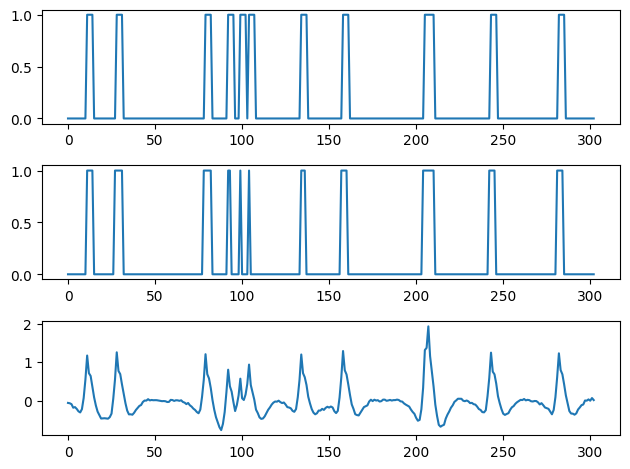

[I 2023-09-13 13:22:28,529] A new study created in memory with name: no-name-de4b5a2b-2e89-4136-b638-ce7c8ce51005
[I 2023-09-13 13:22:28,540] Trial 0 finished with value: 0.7076923076923077 and parameters: {'model': 'logistic', 'C': 0.6503683069862298}. Best is trial 0 with value: 0.7076923076923077.
[I 2023-09-13 13:22:28,559] Trial 1 finished with value: 0.7605633802816901 and parameters: {'model': 'svm_linear', 'C': 0.13168698385730007}. Best is trial 1 with value: 0.7605633802816901.
[I 2023-09-13 13:22:28,578] Trial 2 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 1.5819001794884453}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:28,585] Trial 3 finished with value: 0.7826086956521738 and parameters: {'model': 'logistic', 'C': 2.5903602150572054}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:28,590] Trial 4 finished with value: 0.04878048780487806 and parameters: {'model': 'logistic', 'C': 0.0126190

On y_hat
running tuna study on metric


[I 2023-09-13 13:22:28,598] Trial 5 finished with value: 0.7826086956521738 and parameters: {'model': 'logistic', 'C': 2.6013854305113853}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:28,605] Trial 6 finished with value: 0.4 and parameters: {'model': 'logistic', 'C': 0.04491149704507937}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:28,622] Trial 7 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 0.4639876495089185}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:28,639] Trial 8 finished with value: 0.7777777777777777 and parameters: {'model': 'svm_linear', 'C': 0.5083684107472747}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:28,899] Trial 9 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 86.5051620543226}. Best is trial 9 with value: 0.8108108108108107.
[I 2023-09-13 13:22:29,175] Trial 10 finished with value: 0.8108108108

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 86.5051620543226}
Best Validation Set Accuracy: 0.8108108108108107
Test Set Accuracy: 0.7457627118644068


[I 2023-09-13 13:22:30,763] Trial 9 finished with value: 0.7397260273972603 and parameters: {'model': 'svm_linear', 'C': 33.776883063462314}. Best is trial 2 with value: 0.7733333333333333.
[I 2023-09-13 13:22:30,789] Trial 10 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 2.281699925831472}. Best is trial 2 with value: 0.7733333333333333.
[I 2023-09-13 13:22:30,798] Trial 11 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 5.57769424552574}. Best is trial 2 with value: 0.7733333333333333.
[I 2023-09-13 13:22:30,808] Trial 12 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 4.401539716122056}. Best is trial 2 with value: 0.7733333333333333.
[I 2023-09-13 13:22:30,946] Trial 13 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 20.503705690368744}. Best is trial 2 with value: 0.7733333333333333.
[I 2023-09-13 13:22:30,969] Trial 14 finished with value: 0.7837837837837837 and parameters: {'m

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.076461616594034}
Best Validation Set Accuracy: 0.7837837837837837
Test Set Accuracy: 0.8108108108108109


[I 2023-09-13 13:22:31,308] Trial 9 finished with value: 0.6440677966101694 and parameters: {'model': 'logistic', 'C': 0.12021197352508108}. Best is trial 7 with value: 0.7837837837837837.
[I 2023-09-13 13:22:31,438] Trial 10 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 27.64555791801898}. Best is trial 7 with value: 0.7837837837837837.
[I 2023-09-13 13:22:31,557] Trial 11 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 33.57187655772451}. Best is trial 7 with value: 0.7837837837837837.
[I 2023-09-13 13:22:31,602] Trial 12 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 13.606235719035443}. Best is trial 12 with value: 0.7999999999999999.
[I 2023-09-13 13:22:31,633] Trial 13 finished with value: 0.8051948051948051 and parameters: {'model': 'svm_linear', 'C': 7.247228325963744}. Best is trial 13 with value: 0.8051948051948051.
[I 2023-09-13 13:22:31,669] Trial 14 finished wi

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 10.252839851735011}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.7941176470588236


[I 2023-09-13 13:22:32,242] Trial 1 finished with value: 0.8055555555555555 and parameters: {'model': 'svm_linear', 'C': 96.56898256786442}. Best is trial 1 with value: 0.8055555555555555.
[I 2023-09-13 13:22:32,261] Trial 2 finished with value: 0.696969696969697 and parameters: {'model': 'svm_linear', 'C': 0.10396050525391066}. Best is trial 1 with value: 0.8055555555555555.
[I 2023-09-13 13:22:32,286] Trial 3 finished with value: 0.8055555555555555 and parameters: {'model': 'svm_linear', 'C': 3.818115779218028}. Best is trial 1 with value: 0.8055555555555555.
[I 2023-09-13 13:22:32,302] Trial 4 finished with value: 0.7536231884057972 and parameters: {'model': 'svm_linear', 'C': 0.6323410134526694}. Best is trial 1 with value: 0.8055555555555555.
[I 2023-09-13 13:22:32,317] Trial 5 finished with value: 0.7536231884057972 and parameters: {'model': 'logistic', 'C': 57.03134033041405}. Best is trial 1 with value: 0.8055555555555555.
[I 2023-09-13 13:22:32,337] Trial 6 finished with value

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 96.56898256786442}
Best Validation Set Accuracy: 0.8055555555555555
Test Set Accuracy: 0.6666666666666666


[I 2023-09-13 13:22:33,463] Trial 9 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 3.210104967994697}. Best is trial 4 with value: 0.7792207792207791.
[I 2023-09-13 13:22:33,475] Trial 10 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 41.007695206835635}. Best is trial 4 with value: 0.7792207792207791.
[I 2023-09-13 13:22:33,524] Trial 11 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 9.883140971755674}. Best is trial 4 with value: 0.7792207792207791.
[I 2023-09-13 13:22:33,586] Trial 12 finished with value: 0.7792207792207791 and parameters: {'model': 'svm_linear', 'C': 20.88719283658246}. Best is trial 4 with value: 0.7792207792207791.
[I 2023-09-13 13:22:33,829] Trial 13 finished with value: 0.7692307692307692 and parameters: {'model': 'svm_linear', 'C': 94.05857033528049}. Best is trial 4 with value: 0.7792207792207791.
[I 2023-09-13 13:22:33,894] Trial 14 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 20.11926824844606}
Best Validation Set Accuracy: 0.7792207792207791
Test Set Accuracy: 0.7088607594936709


[I 2023-09-13 13:22:34,735] Trial 8 finished with value: 0.7222222222222223 and parameters: {'model': 'svm_linear', 'C': 68.3188642857155}. Best is trial 2 with value: 0.7605633802816901.
[I 2023-09-13 13:22:34,805] Trial 9 finished with value: 0.7323943661971831 and parameters: {'model': 'svm_linear', 'C': 21.44575000794877}. Best is trial 2 with value: 0.7605633802816901.
[I 2023-09-13 13:22:34,815] Trial 10 finished with value: 0.4905660377358491 and parameters: {'model': 'logistic', 'C': 0.05328495400110342}. Best is trial 2 with value: 0.7605633802816901.
[I 2023-09-13 13:22:34,836] Trial 11 finished with value: 0.7605633802816901 and parameters: {'model': 'svm_linear', 'C': 0.14520493239114662}. Best is trial 2 with value: 0.7605633802816901.
[I 2023-09-13 13:22:34,858] Trial 12 finished with value: 0.7605633802816901 and parameters: {'model': 'svm_linear', 'C': 0.10674974445023384}. Best is trial 2 with value: 0.7605633802816901.
[I 2023-09-13 13:22:34,879] Trial 13 finished wit

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.17846543434838483}
Best Validation Set Accuracy: 0.7671232876712328
Test Set Accuracy: 0.7906976744186046


[I 2023-09-13 13:22:35,220] Trial 13 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 2.653746217802937}. Best is trial 8 with value: 0.7837837837837837.
[I 2023-09-13 13:22:35,240] Trial 14 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.4175298203700667}. Best is trial 8 with value: 0.7837837837837837.
[I 2023-09-13 13:22:35,276] Trial 15 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 8.152816184350216}. Best is trial 8 with value: 0.7837837837837837.
[I 2023-09-13 13:22:35,449] Trial 16 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 74.8336984235541}. Best is trial 16 with value: 0.7894736842105262.
[I 2023-09-13 13:22:35,670] Trial 17 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 84.994192430333}. Best is trial 16 with value: 0.7894736842105262.
[I 2023-09-13 13:22:35,893] Trial 18 finished with

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 74.8336984235541}
Best Validation Set Accuracy: 0.7894736842105262
Test Set Accuracy: 0.8470588235294118


[I 2023-09-13 13:22:36,724] Trial 11 finished with value: 0.7368421052631577 and parameters: {'model': 'svm_linear', 'C': 87.42344609821707}. Best is trial 2 with value: 0.7671232876712328.
[I 2023-09-13 13:22:36,736] Trial 12 finished with value: 0.7246376811594203 and parameters: {'model': 'logistic', 'C': 1.7838038769843798}. Best is trial 2 with value: 0.7671232876712328.
[I 2023-09-13 13:22:36,784] Trial 13 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 10.99493082661312}. Best is trial 2 with value: 0.7671232876712328.
[I 2023-09-13 13:22:36,797] Trial 14 finished with value: 0.7164179104477612 and parameters: {'model': 'logistic', 'C': 0.9475081318025993}. Best is trial 2 with value: 0.7671232876712328.
[I 2023-09-13 13:22:36,919] Trial 15 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 21.422357112230973}. Best is trial 2 with value: 0.7671232876712328.
[I 2023-09-13 13:22:36,939] Trial 16 finished with value: 0.77922

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.100248755715847}
Best Validation Set Accuracy: 0.7792207792207791
Test Set Accuracy: 0.7941176470588235


[I 2023-09-13 13:22:37,193] Trial 9 finished with value: 0.7605633802816901 and parameters: {'model': 'logistic', 'C': 7.197493387079104}. Best is trial 8 with value: 0.7777777777777777.
[I 2023-09-13 13:22:37,212] Trial 10 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.5494779150331457}. Best is trial 8 with value: 0.7777777777777777.
[I 2023-09-13 13:22:37,382] Trial 11 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 49.61829299984098}. Best is trial 11 with value: 0.7837837837837837.
[I 2023-09-13 13:22:37,651] Trial 12 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 65.23259249890071}. Best is trial 11 with value: 0.7837837837837837.
[I 2023-09-13 13:22:38,051] Trial 13 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 96.09473611248332}. Best is trial 11 with value: 0.7837837837837837.
[I 2023-09-13 13:22:38,320] Trial 14 finished wit

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 49.61829299984098}
Best Validation Set Accuracy: 0.7837837837837837
Test Set Accuracy: 0.8484848484848485


[I 2023-09-13 13:22:39,074] Trial 4 finished with value: 0.8823529411764706 and parameters: {'model': 'svm_linear', 'C': 32.45679901859496}. Best is trial 0 with value: 0.9142857142857143.
[I 2023-09-13 13:22:39,081] Trial 5 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.014323178718768344}. Best is trial 0 with value: 0.9142857142857143.
[I 2023-09-13 13:22:39,088] Trial 6 finished with value: 0.4 and parameters: {'model': 'logistic', 'C': 0.03385798122802583}. Best is trial 0 with value: 0.9142857142857143.
[I 2023-09-13 13:22:39,097] Trial 7 finished with value: 0.7999999999999999 and parameters: {'model': 'logistic', 'C': 0.6808874008295352}. Best is trial 0 with value: 0.9142857142857143.
[I 2023-09-13 13:22:39,117] Trial 8 finished with value: 0.6666666666666666 and parameters: {'model': 'svm_linear', 'C': 0.018813048478365065}. Best is trial 0 with value: 0.9142857142857143.
[I 2023-09-13 13:22:39,214] Trial 9 finished with value: 0.8823529411764706 and pa

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.5005345044903033}
Best Validation Set Accuracy: 0.9142857142857143
Test Set Accuracy: 0.7865168539325844


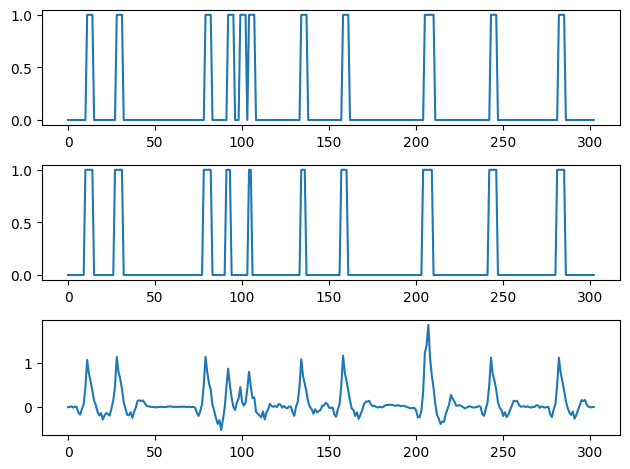

C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_14744\266028130.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
[I 2023-09-13 13:22:40,251] A new study created in memory with name: no-name-e4315269-b8f2-4718-95f1-d94fd1389939
[I 2023-09-13 13:22:40,258] Trial 0 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.6023582531334172}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,262] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.4398395456185962}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,268] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.2264450315810593}. Best is trial 0 with value: 1.0.
[I 2023-09-1

For SNR = 30
On x
running tuna study on metric
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.6023582531334172}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:22:40,433] Trial 3 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.2937548271662873}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,439] Trial 4 finished with value: 0.7777777777777778 and parameters: {'model': 'logistic', 'C': 0.03831626306224711}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,444] Trial 5 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.015446599584140908}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,450] Trial 6 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 19.133235778329883}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,455] Trial 7 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.0537228853000413}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,461] Trial 8 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.2959747836514258}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,468] Tr

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.63452125294863}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.1676013346785163}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:22:40,745] Trial 0 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.15544523934906496}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,755] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.09819972927554699}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,764] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 56.79513825892214}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,773] Trial 3 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.012075963939037131}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,780] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.5977006151854268}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,787] Trial 5 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.3557579430015672}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:40,796] Trial 6 finishe

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.15544523934906496}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.4408657968529899}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:22:41,125] Trial 4 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 3.8238393455297275}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,131] Trial 5 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.21686605731487324}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,138] Trial 6 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.28831982889869817}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,146] Trial 7 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.07317893515405804}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,153] Trial 8 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 3.0859997143425955}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,160] Trial 9 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 12.072329682132114}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,169] Trial 10 finish

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 21.379229663645784}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.6267329488342396}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:22:41,453] Trial 7 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 23.75809232810075}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,461] Trial 8 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 57.76540748324736}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,468] Trial 9 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 5.446556497863273}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,475] Trial 10 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.011325910271191614}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,484] Trial 11 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 85.26884346717966}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,493] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 9.938678624819751}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,503] Trial 13 finishe

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 71.33485107320537}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.43605300885460624}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:22:41,763] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 82.58027620429839}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,771] Trial 3 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 54.41374482098618}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,779] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 65.29202371517822}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,786] Trial 5 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 3.0956658665907404}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,791] Trial 6 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.03445726419895993}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,799] Trial 7 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 22.81356639434571}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:22:41,802] Trial 8 finished with value

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.5163804050305502}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


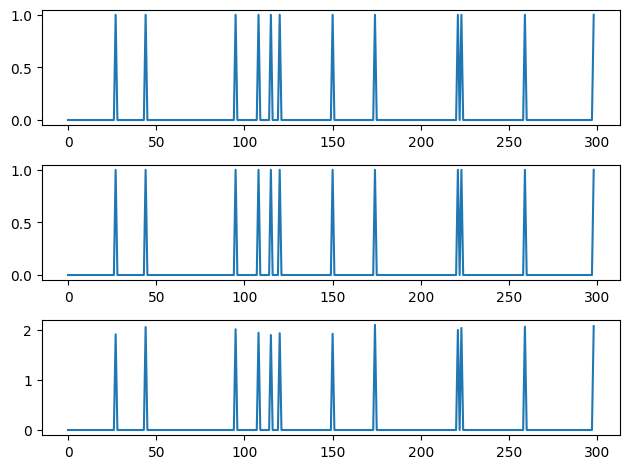

[I 2023-09-13 13:22:42,013] A new study created in memory with name: no-name-9454da47-08e3-4298-8f68-4166c7b4b243
[I 2023-09-13 13:22:42,024] Trial 0 finished with value: 0.7826086956521738 and parameters: {'model': 'logistic', 'C': 2.1310713006271773}. Best is trial 0 with value: 0.7826086956521738.
[I 2023-09-13 13:22:42,033] Trial 1 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 58.34447668649438}. Best is trial 1 with value: 0.7887323943661972.
[I 2023-09-13 13:22:42,041] Trial 2 finished with value: 0.6874999999999999 and parameters: {'model': 'logistic', 'C': 0.4650460277718688}. Best is trial 1 with value: 0.7887323943661972.
[I 2023-09-13 13:22:42,045] Trial 3 finished with value: 0.2608695652173913 and parameters: {'model': 'logistic', 'C': 0.018804328012344496}. Best is trial 1 with value: 0.7887323943661972.
[I 2023-09-13 13:22:42,073] Trial 4 finished with value: 0.821917808219178 and parameters: {'model': 'svm_linear', 'C': 2.04806398052

On y
running tuna study on metric


[I 2023-09-13 13:22:42,096] Trial 5 finished with value: 0.6666666666666666 and parameters: {'model': 'svm_linear', 'C': 0.017259242149471343}. Best is trial 4 with value: 0.821917808219178.
[I 2023-09-13 13:22:42,119] Trial 6 finished with value: 0.6956521739130435 and parameters: {'model': 'svm_linear', 'C': 0.045448637833627265}. Best is trial 4 with value: 0.821917808219178.
[I 2023-09-13 13:22:42,129] Trial 7 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 4.144771626383949}. Best is trial 4 with value: 0.821917808219178.
[I 2023-09-13 13:22:42,610] Trial 8 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 86.47057732305564}. Best is trial 4 with value: 0.821917808219178.
[I 2023-09-13 13:22:42,993] Trial 9 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 64.68991277307869}. Best is trial 4 with value: 0.821917808219178.
[I 2023-09-13 13:22:43,013] Trial 10 finished with value

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.1751734532632216}
Best Validation Set Accuracy: 0.8493150684931509
Test Set Accuracy: 0.7636363636363638


[I 2023-09-13 13:22:44,046] Trial 6 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 0.2684951265692234}. Best is trial 6 with value: 0.7894736842105262.
[I 2023-09-13 13:22:44,054] Trial 7 finished with value: 0.6984126984126985 and parameters: {'model': 'logistic', 'C': 0.23442569132795404}. Best is trial 6 with value: 0.7894736842105262.
[I 2023-09-13 13:22:44,059] Trial 8 finished with value: 0.6557377049180327 and parameters: {'model': 'logistic', 'C': 0.19872042069825147}. Best is trial 6 with value: 0.7894736842105262.
[I 2023-09-13 13:22:44,065] Trial 9 finished with value: 0.696969696969697 and parameters: {'model': 'logistic', 'C': 0.35825969950716197}. Best is trial 6 with value: 0.7894736842105262.
[I 2023-09-13 13:22:44,098] Trial 10 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 3.0242138953217483}. Best is trial 6 with value: 0.7894736842105262.
[I 2023-09-13 13:22:44,676] Trial 11 finished with va

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.2684951265692234}
Best Validation Set Accuracy: 0.7894736842105262
Test Set Accuracy: 0.8333333333333334


[I 2023-09-13 13:22:45,141] Trial 0 finished with value: 0.7631578947368423 and parameters: {'model': 'svm_linear', 'C': 17.31988518443485}. Best is trial 0 with value: 0.7631578947368423.
[I 2023-09-13 13:22:45,150] Trial 1 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 1.0160875585603892}. Best is trial 0 with value: 0.7631578947368423.
[I 2023-09-13 13:22:45,157] Trial 2 finished with value: 0.6666666666666667 and parameters: {'model': 'logistic', 'C': 0.26924247695352616}. Best is trial 0 with value: 0.7631578947368423.
[I 2023-09-13 13:22:45,174] Trial 3 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 0.4045042457677326}. Best is trial 3 with value: 0.7733333333333333.
[I 2023-09-13 13:22:45,183] Trial 4 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 7.142226811985766}. Best is trial 3 with value: 0.7733333333333333.
[I 2023-09-13 13:22:45,201] Trial 5 finished with value: 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.719066171620379}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8285714285714286


[I 2023-09-13 13:22:46,782] Trial 10 finished with value: 0.7777777777777777 and parameters: {'model': 'svm_linear', 'C': 93.14072077897977}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:46,968] Trial 11 finished with value: 0.7777777777777777 and parameters: {'model': 'svm_linear', 'C': 27.026089823131763}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:46,994] Trial 12 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 1.4777585464214003}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:47,161] Trial 13 finished with value: 0.7777777777777777 and parameters: {'model': 'svm_linear', 'C': 20.979534726891174}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:47,177] Trial 14 finished with value: 0.7605633802816901 and parameters: {'model': 'logistic', 'C': 5.336828675984541}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:22:47,525] Trial 15 finished wit

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 18.45976223190445}
Best Validation Set Accuracy: 0.7945205479452054
Test Set Accuracy: 0.64


[I 2023-09-13 13:22:48,205] Trial 5 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 85.6770877938283}. Best is trial 5 with value: 0.7837837837837837.
[I 2023-09-13 13:22:48,235] Trial 6 finished with value: 0.7792207792207791 and parameters: {'model': 'svm_linear', 'C': 4.2612732573578445}. Best is trial 5 with value: 0.7837837837837837.
[I 2023-09-13 13:22:48,245] Trial 7 finished with value: 0.7462686567164178 and parameters: {'model': 'logistic', 'C': 0.4766199754235326}. Best is trial 5 with value: 0.7837837837837837.
[I 2023-09-13 13:22:48,267] Trial 8 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 2.3979977901521754}. Best is trial 8 with value: 0.8157894736842106.
[I 2023-09-13 13:22:48,273] Trial 9 finished with value: 0.2978723404255319 and parameters: {'model': 'logistic', 'C': 0.0246779941340583}. Best is trial 8 with value: 0.8157894736842106.
[I 2023-09-13 13:22:48,295] Trial 10 finished with value

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.713540430762998}
Best Validation Set Accuracy: 0.8266666666666667
Test Set Accuracy: 0.7435897435897436


[I 2023-09-13 13:22:49,627] Trial 7 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 41.48784181064597}. Best is trial 7 with value: 0.7567567567567567.
[I 2023-09-13 13:22:49,652] Trial 8 finished with value: 0.6874999999999999 and parameters: {'model': 'svm_linear', 'C': 0.02232184665803228}. Best is trial 7 with value: 0.7567567567567567.
[I 2023-09-13 13:22:49,695] Trial 9 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 6.017432317593707}. Best is trial 9 with value: 0.7733333333333333.
[I 2023-09-13 13:22:49,736] Trial 10 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 5.263921718045296}. Best is trial 9 with value: 0.7733333333333333.
[I 2023-09-13 13:22:49,774] Trial 11 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 4.730125682239206}. Best is trial 9 with value: 0.7733333333333333.
[I 2023-09-13 13:22:49,855] Trial 12 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.8356373920822902}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.888888888888889


[I 2023-09-13 13:22:50,244] Trial 1 finished with value: 0.6774193548387099 and parameters: {'model': 'logistic', 'C': 0.22003847436515786}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:22:50,565] Trial 2 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 69.22171943819738}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:22:50,588] Trial 3 finished with value: 0.6956521739130435 and parameters: {'model': 'svm_linear', 'C': 0.035838231606597465}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:22:50,600] Trial 4 finished with value: 0.7605633802816901 and parameters: {'model': 'logistic', 'C': 73.56371921175901}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:22:50,736] Trial 5 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 20.754608441886862}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:22:50,744] Trial 6 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 3.1917183827016378}
Best Validation Set Accuracy: 0.7894736842105262
Test Set Accuracy: 0.8433734939759036


[I 2023-09-13 13:22:51,310] Trial 5 finished with value: 0.4313725490196079 and parameters: {'model': 'logistic', 'C': 0.0427294924300394}. Best is trial 2 with value: 0.8051948051948051.
[I 2023-09-13 13:22:51,328] Trial 6 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.11470171584328603}. Best is trial 2 with value: 0.8051948051948051.
[I 2023-09-13 13:22:51,337] Trial 7 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 4.549555052592679}. Best is trial 2 with value: 0.8051948051948051.
[I 2023-09-13 13:22:51,364] Trial 8 finished with value: 0.8051948051948051 and parameters: {'model': 'svm_linear', 'C': 1.696827465198161}. Best is trial 2 with value: 0.8051948051948051.
[I 2023-09-13 13:22:51,373] Trial 9 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 13.33744682334496}. Best is trial 2 with value: 0.8051948051948051.
[I 2023-09-13 13:22:51,858] Trial 10 finished with value: 0.799999999999

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 3.906047908706838}
Best Validation Set Accuracy: 0.8051948051948051
Test Set Accuracy: 0.7575757575757577


[I 2023-09-13 13:22:52,389] Trial 10 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 2.3277168047739347}. Best is trial 1 with value: 0.8051948051948051.
[I 2023-09-13 13:22:52,414] Trial 11 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 1.5105272134801677}. Best is trial 11 with value: 0.8157894736842106.
[I 2023-09-13 13:22:52,438] Trial 12 finished with value: 0.8051948051948051 and parameters: {'model': 'svm_linear', 'C': 1.2565586386884526}. Best is trial 11 with value: 0.8157894736842106.
[I 2023-09-13 13:22:52,478] Trial 13 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 4.809475360407119}. Best is trial 11 with value: 0.8157894736842106.
[I 2023-09-13 13:22:52,489] Trial 14 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 0.8622867043480508}. Best is trial 11 with value: 0.8157894736842106.
[I 2023-09-13 13:22:52,515] Trial 15 finished with value: 0.

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.5105272134801677}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.888888888888889


[I 2023-09-13 13:22:53,399] Trial 7 finished with value: 0.888888888888889 and parameters: {'model': 'svm_linear', 'C': 0.9301361129135521}. Best is trial 3 with value: 0.9142857142857143.
[I 2023-09-13 13:22:53,408] Trial 8 finished with value: 0.8387096774193549 and parameters: {'model': 'logistic', 'C': 3.580011813000533}. Best is trial 3 with value: 0.9142857142857143.
[I 2023-09-13 13:22:53,416] Trial 9 finished with value: 0.8387096774193549 and parameters: {'model': 'logistic', 'C': 0.9014715773196812}. Best is trial 3 with value: 0.9142857142857143.
[I 2023-09-13 13:22:53,713] Trial 10 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 39.641001779817294}. Best is trial 10 with value: 0.9411764705882353.
[I 2023-09-13 13:22:54,163] Trial 11 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 54.64073937485481}. Best is trial 10 with value: 0.9411764705882353.
[I 2023-09-13 13:22:54,614] Trial 12 finished with va

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 39.641001779817294}
Best Validation Set Accuracy: 0.9411764705882353
Test Set Accuracy: 0.7954545454545455


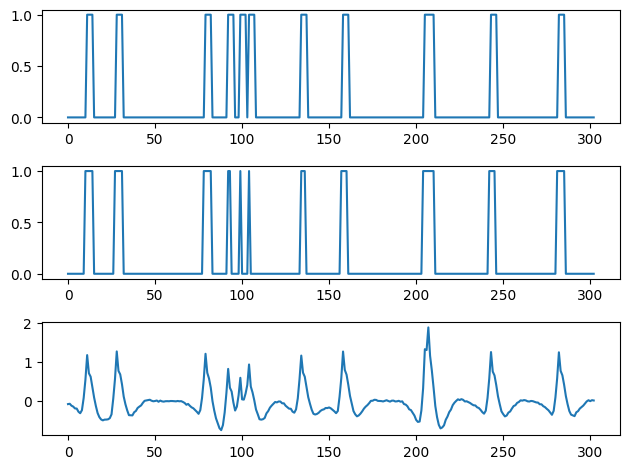

[I 2023-09-13 13:22:56,672] A new study created in memory with name: no-name-b42a312a-dc40-40b3-8c5c-9b4e563c0483
[I 2023-09-13 13:22:56,691] Trial 0 finished with value: 0.7352941176470589 and parameters: {'model': 'svm_linear', 'C': 0.11132269422902931}. Best is trial 0 with value: 0.7352941176470589.
[I 2023-09-13 13:22:56,699] Trial 1 finished with value: 0.7272727272727274 and parameters: {'model': 'logistic', 'C': 1.1877386038963567}. Best is trial 0 with value: 0.7352941176470589.
[I 2023-09-13 13:22:56,716] Trial 2 finished with value: 0.7428571428571429 and parameters: {'model': 'svm_linear', 'C': 0.3717998353170462}. Best is trial 2 with value: 0.7428571428571429.


On y_hat
running tuna study on metric


[I 2023-09-13 13:22:56,758] Trial 3 finished with value: 0.7887323943661972 and parameters: {'model': 'svm_linear', 'C': 10.335195750501441}. Best is trial 3 with value: 0.7887323943661972.
[I 2023-09-13 13:22:56,780] Trial 4 finished with value: 0.7714285714285714 and parameters: {'model': 'svm_linear', 'C': 3.387279339247015}. Best is trial 3 with value: 0.7887323943661972.
[I 2023-09-13 13:22:56,843] Trial 5 finished with value: 0.7777777777777777 and parameters: {'model': 'svm_linear', 'C': 15.491371809915384}. Best is trial 3 with value: 0.7887323943661972.
[I 2023-09-13 13:22:56,861] Trial 6 finished with value: 0.676923076923077 and parameters: {'model': 'svm_linear', 'C': 0.06532039734959467}. Best is trial 3 with value: 0.7887323943661972.
[I 2023-09-13 13:22:56,871] Trial 7 finished with value: 0.5964912280701754 and parameters: {'model': 'logistic', 'C': 0.13567540607765147}. Best is trial 3 with value: 0.7887323943661972.
[I 2023-09-13 13:22:56,899] Trial 8 finished with va

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 10.335195750501441}
Best Validation Set Accuracy: 0.7887323943661972
Test Set Accuracy: 0.7719298245614034


[I 2023-09-13 13:22:57,610] Trial 10 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 54.75083111318163}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:22:57,631] Trial 11 finished with value: 0.7397260273972603 and parameters: {'model': 'svm_linear', 'C': 0.23075266407157471}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:22:57,679] Trial 12 finished with value: 0.72 and parameters: {'model': 'svm_linear', 'C': 9.412568850749095}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:22:57,722] Trial 13 finished with value: 0.72 and parameters: {'model': 'svm_linear', 'C': 6.910539169856323}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:22:57,744] Trial 14 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.12724688392789532}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:22:57,763] Trial 15 finished with value: 0.7631578947368423 and paramet

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.10607830429845441}
Best Validation Set Accuracy: 0.7777777777777777
Test Set Accuracy: 0.8333333333333334


[I 2023-09-13 13:22:58,094] Trial 2 finished with value: 0.7297297297297296 and parameters: {'model': 'svm_linear', 'C': 62.23050225363939}. Best is trial 2 with value: 0.7297297297297296.
[I 2023-09-13 13:22:58,104] Trial 3 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 3.8740743912726634}. Best is trial 3 with value: 0.7323943661971831.
[I 2023-09-13 13:22:58,122] Trial 4 finished with value: 0.7536231884057972 and parameters: {'model': 'svm_linear', 'C': 0.07615036343271196}. Best is trial 4 with value: 0.7536231884057972.
[I 2023-09-13 13:22:58,335] Trial 5 finished with value: 0.7297297297297296 and parameters: {'model': 'svm_linear', 'C': 93.87446776347693}. Best is trial 4 with value: 0.7536231884057972.
[I 2023-09-13 13:22:58,346] Trial 6 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 1.6761266827360837}. Best is trial 4 with value: 0.7536231884057972.
[I 2023-09-13 13:22:58,356] Trial 7 finished with value

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.2535768840327652}
Best Validation Set Accuracy: 0.7733333333333333
Test Set Accuracy: 0.8285714285714286


[I 2023-09-13 13:22:58,833] Trial 7 finished with value: 0.7352941176470589 and parameters: {'model': 'svm_linear', 'C': 0.0989143056713708}. Best is trial 1 with value: 0.7536231884057972.
[I 2023-09-13 13:22:58,840] Trial 8 finished with value: 0.18181818181818182 and parameters: {'model': 'logistic', 'C': 0.022596791682919247}. Best is trial 1 with value: 0.7536231884057972.
[I 2023-09-13 13:22:58,845] Trial 9 finished with value: 0.09523809523809523 and parameters: {'model': 'logistic', 'C': 0.014836191554082428}. Best is trial 1 with value: 0.7536231884057972.
[I 2023-09-13 13:22:58,867] Trial 10 finished with value: 0.7826086956521738 and parameters: {'model': 'svm_linear', 'C': 1.688894636757517}. Best is trial 10 with value: 0.7826086956521738.
[I 2023-09-13 13:22:58,888] Trial 11 finished with value: 0.7777777777777777 and parameters: {'model': 'svm_linear', 'C': 2.533628370555213}. Best is trial 10 with value: 0.7826086956521738.
[I 2023-09-13 13:22:58,914] Trial 12 finished 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.688894636757517}
Best Validation Set Accuracy: 0.7826086956521738
Test Set Accuracy: 0.7058823529411765


[I 2023-09-13 13:23:00,019] Trial 11 finished with value: 0.7631578947368423 and parameters: {'model': 'svm_linear', 'C': 62.7067648069521}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:23:00,049] Trial 12 finished with value: 0.7631578947368423 and parameters: {'model': 'svm_linear', 'C': 7.505839225987514}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:23:00,070] Trial 13 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 0.35378337227225026}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:23:00,128] Trial 14 finished with value: 0.7368421052631577 and parameters: {'model': 'svm_linear', 'C': 10.9330592362121}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:23:00,148] Trial 15 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 2.4109552255732085}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:23:00,213] Trial 16 finished with value: 0.746

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.7826366626763395}
Best Validation Set Accuracy: 0.7837837837837837
Test Set Accuracy: 0.717948717948718


[I 2023-09-13 13:23:00,722] Trial 5 finished with value: 0.7142857142857143 and parameters: {'model': 'svm_linear', 'C': 73.10840047801854}. Best is trial 4 with value: 0.7246376811594203.
[I 2023-09-13 13:23:00,731] Trial 6 finished with value: 0.5185185185185185 and parameters: {'model': 'logistic', 'C': 0.0684828476555314}. Best is trial 4 with value: 0.7246376811594203.
[I 2023-09-13 13:23:00,739] Trial 7 finished with value: 0.13953488372093023 and parameters: {'model': 'logistic', 'C': 0.01930749657869978}. Best is trial 4 with value: 0.7246376811594203.
[I 2023-09-13 13:23:00,758] Trial 8 finished with value: 0.7246376811594203 and parameters: {'model': 'svm_linear', 'C': 0.0771582728347116}. Best is trial 4 with value: 0.7246376811594203.
[I 2023-09-13 13:23:00,802] Trial 9 finished with value: 0.7428571428571429 and parameters: {'model': 'svm_linear', 'C': 11.454748937741359}. Best is trial 9 with value: 0.7428571428571429.
[I 2023-09-13 13:23:00,835] Trial 10 finished with va

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 11.454748937741359}
Best Validation Set Accuracy: 0.7428571428571429
Test Set Accuracy: 0.7727272727272727


[I 2023-09-13 13:23:01,832] Trial 3 finished with value: 0.7123287671232875 and parameters: {'model': 'svm_linear', 'C': 74.36813274312628}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:23:01,850] Trial 4 finished with value: 0.7222222222222223 and parameters: {'model': 'svm_linear', 'C': 2.2233528738959407}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:23:01,870] Trial 5 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.21035917413365376}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:23:01,889] Trial 6 finished with value: 0.7323943661971831 and parameters: {'model': 'svm_linear', 'C': 0.0993524614427014}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:23:01,909] Trial 7 finished with value: 0.6874999999999999 and parameters: {'model': 'svm_linear', 'C': 0.04523471314112212}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:23:01,916] Trial 8 finished with

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.7159731334731105}
Best Validation Set Accuracy: 0.7733333333333333
Test Set Accuracy: 0.8571428571428572


[I 2023-09-13 13:23:02,429] Trial 6 finished with value: 0.7142857142857143 and parameters: {'model': 'svm_linear', 'C': 30.239854201265647}. Best is trial 3 with value: 0.7605633802816901.
[I 2023-09-13 13:23:02,448] Trial 7 finished with value: 0.6666666666666667 and parameters: {'model': 'svm_linear', 'C': 0.060294866108767664}. Best is trial 3 with value: 0.7605633802816901.
[I 2023-09-13 13:23:02,464] Trial 8 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.5665714567554109}. Best is trial 3 with value: 0.7605633802816901.
[I 2023-09-13 13:23:02,481] Trial 9 finished with value: 0.7428571428571429 and parameters: {'model': 'svm_linear', 'C': 0.988707074209339}. Best is trial 3 with value: 0.7605633802816901.
[I 2023-09-13 13:23:02,489] Trial 10 finished with value: 0.04878048780487806 and parameters: {'model': 'logistic', 'C': 0.012870202451313756}. Best is trial 3 with value: 0.7605633802816901.
[I 2023-09-13 13:23:02,508] Trial 11 finished w

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.49341131710833275}
Best Validation Set Accuracy: 0.7671232876712328
Test Set Accuracy: 0.7384615384615385


[I 2023-09-13 13:23:02,864] Trial 1 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 45.079500098613224}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:23:02,883] Trial 2 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 1.1731699451438373}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:23:02,896] Trial 3 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 3.3617145964903443}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:23:02,916] Trial 4 finished with value: 0.5714285714285715 and parameters: {'model': 'svm_linear', 'C': 0.015099182009293388}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:23:02,936] Trial 5 finished with value: 0.7164179104477612 and parameters: {'model': 'svm_linear', 'C': 0.07385663936082118}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:23:02,959] Trial 6 finished with value: 0.75 a

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 45.079500098613224}
Best Validation Set Accuracy: 0.7671232876712328
Test Set Accuracy: 0.8484848484848485


[I 2023-09-13 13:23:04,587] Trial 3 finished with value: 0.8823529411764706 and parameters: {'model': 'svm_linear', 'C': 8.528841604470527}. Best is trial 0 with value: 0.8823529411764706.
[I 2023-09-13 13:23:04,595] Trial 4 finished with value: 0.7407407407407406 and parameters: {'model': 'logistic', 'C': 0.21633816064345476}. Best is trial 0 with value: 0.8823529411764706.
[I 2023-09-13 13:23:04,616] Trial 5 finished with value: 0.4 and parameters: {'model': 'svm_linear', 'C': 0.013176289457646689}. Best is trial 0 with value: 0.8823529411764706.
[I 2023-09-13 13:23:04,635] Trial 6 finished with value: 0.8823529411764706 and parameters: {'model': 'svm_linear', 'C': 0.4213950304078163}. Best is trial 0 with value: 0.8823529411764706.
[I 2023-09-13 13:23:04,642] Trial 7 finished with value: 0.7857142857142857 and parameters: {'model': 'logistic', 'C': 0.27937420873998714}. Best is trial 0 with value: 0.8823529411764706.
[I 2023-09-13 13:23:04,663] Trial 8 finished with value: 0.8275862

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 92.85838875168946}
Best Validation Set Accuracy: 0.9090909090909091
Test Set Accuracy: 0.7906976744186046


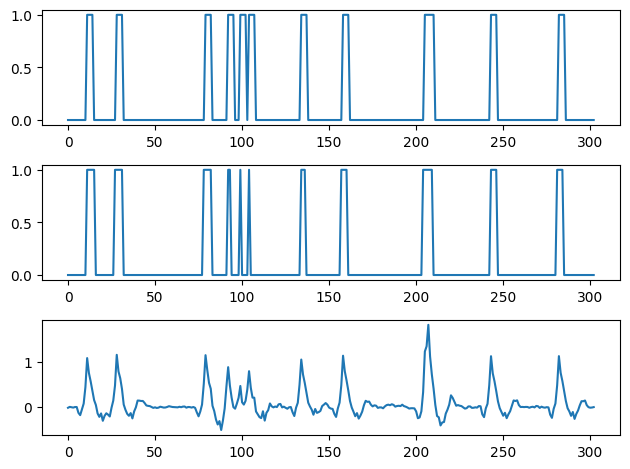

C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_14744\266028130.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
[I 2023-09-13 13:23:06,650] A new study created in memory with name: no-name-defe5a18-eacf-49c1-ad78-5aaaa6953da1
[I 2023-09-13 13:23:06,660] Trial 0 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.10048630926918961}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:06,670] Trial 1 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 4.287066694740008}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:06,674] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.49115117485176196}. Best is trial 0 with value: 1.0.
[I 2023-09-13

For SNR = 35
On x
running tuna study on metric
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.10048630926918961}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:23:06,831] A new study created in memory with name: no-name-ba971e14-f8c5-4d1d-9d0b-dd4cca2f51c2
[I 2023-09-13 13:23:06,837] Trial 0 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.025196398148068847}. Best is trial 0 with value: 0.0.
[I 2023-09-13 13:23:06,842] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 57.538976017307185}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:23:06,851] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 29.14839050864768}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:23:06,857] Trial 3 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.29462792237442104}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:23:06,864] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.4951437687095181}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:23:06,869] Trial 5 finished with value: 1.0 and parameters: {'model': 'lo

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 57.538976017307185}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.3259028198185263}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:23:07,166] Trial 3 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.24753565963511232}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,175] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 40.76875646928587}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,184] Trial 5 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 12.962130197989527}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,192] Trial 6 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 4.883900966216118}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,198] Trial 7 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.8270650363299117}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,206] Trial 8 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.8466522091289723}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,213] Trial 9 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.20121299087404984}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.18904373081529924}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:23:07,534] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.08528057465435553}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,539] Trial 3 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.4747824158419682}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,548] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 10.18103490096648}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,554] Trial 5 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 22.206594672446005}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,562] Trial 6 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.028990166487442525}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,570] Trial 7 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 9.504254757601885}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,576] Trial 8 finishe

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 13.359297672857057}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 16.789447546748463}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:23:07,870] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.6814698517302556}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,878] Trial 3 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 16.77498599273619}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,885] Trial 4 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.8790515569987395}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,894] Trial 5 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 27.66970838587666}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,904] Trial 6 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.0956189027003479}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,912] Trial 7 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 8.66464476805386}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:07,917] Trial 8 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.16272300888226648}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.02403112926337536}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:23:08,214] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 68.36169839301614}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:08,217] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 5.818058542832793}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:08,223] Trial 3 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.03492918579267546}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:08,227] Trial 4 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.4533246665382795}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:08,230] Trial 5 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.66732099775758}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:08,242] Trial 6 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.021072380123362155}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:08,250] Trial 7 finishe

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 13.690616671956482}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


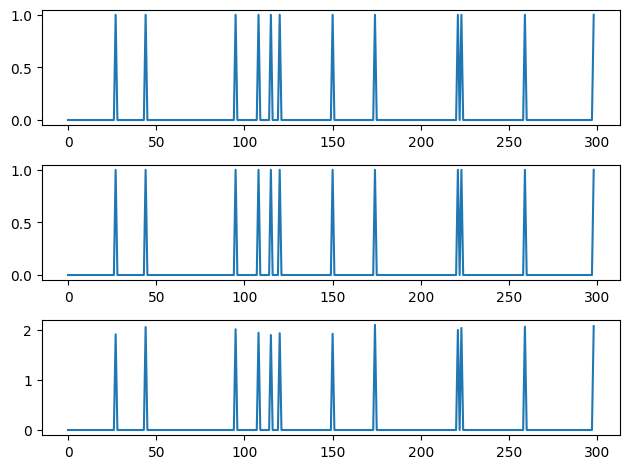

[I 2023-09-13 13:23:08,517] A new study created in memory with name: no-name-04348043-f6b0-406e-96f3-54a0cf40c15f


On y
running tuna study on metric


[I 2023-09-13 13:23:08,793] Trial 0 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 42.862377893789855}. Best is trial 0 with value: 0.8108108108108107.
[I 2023-09-13 13:23:08,800] Trial 1 finished with value: 0.5714285714285715 and parameters: {'model': 'logistic', 'C': 0.09003756907360702}. Best is trial 0 with value: 0.8108108108108107.
[I 2023-09-13 13:23:08,811] Trial 2 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 86.19388748176684}. Best is trial 0 with value: 0.8108108108108107.
[I 2023-09-13 13:23:08,987] Trial 3 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 30.01034371070611}. Best is trial 0 with value: 0.8108108108108107.
[I 2023-09-13 13:23:08,998] Trial 4 finished with value: 0.6874999999999999 and parameters: {'model': 'logistic', 'C': 0.32145320472789574}. Best is trial 0 with value: 0.8108108108108107.
[I 2023-09-13 13:23:09,008] Trial 5 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.5569107582493209}
Best Validation Set Accuracy: 0.821917808219178
Test Set Accuracy: 0.7636363636363638


[I 2023-09-13 13:23:10,170] Trial 7 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 17.73473631489104}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:23:10,180] Trial 8 finished with value: 0.4615384615384615 and parameters: {'model': 'logistic', 'C': 0.040876972705669264}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:23:10,465] Trial 9 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 30.035324984994688}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:23:10,476] Trial 10 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 1.1087020428461256}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:23:10,535] Trial 11 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 7.009454327674751}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:23:10,602] Trial 12 finished with value: 0.773333

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.7261498021607876}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8333333333333334


[I 2023-09-13 13:23:10,997] Trial 4 finished with value: 0.7631578947368423 and parameters: {'model': 'svm_linear', 'C': 15.751745431401707}. Best is trial 3 with value: 0.7733333333333333.
[I 2023-09-13 13:23:11,037] Trial 5 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 3.46628445062357}. Best is trial 3 with value: 0.7733333333333333.
[I 2023-09-13 13:23:11,264] Trial 6 finished with value: 0.7631578947368423 and parameters: {'model': 'svm_linear', 'C': 26.378614839364126}. Best is trial 3 with value: 0.7733333333333333.
[I 2023-09-13 13:23:11,288] Trial 7 finished with value: 0.6956521739130435 and parameters: {'model': 'svm_linear', 'C': 0.03689159504952885}. Best is trial 3 with value: 0.7733333333333333.
[I 2023-09-13 13:23:11,300] Trial 8 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 4.366873788021159}. Best is trial 3 with value: 0.7733333333333333.
[I 2023-09-13 13:23:11,308] Trial 9 finished with valu

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 6.379085709137255}
Best Validation Set Accuracy: 0.7837837837837837
Test Set Accuracy: 0.8059701492537314


[I 2023-09-13 13:23:12,373] Trial 2 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 55.2277475134694}. Best is trial 1 with value: 0.7945205479452054.
[I 2023-09-13 13:23:12,386] Trial 3 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 1.6908689065941602}. Best is trial 1 with value: 0.7945205479452054.
[I 2023-09-13 13:23:12,394] Trial 4 finished with value: 0.676923076923077 and parameters: {'model': 'logistic', 'C': 0.5406989951274941}. Best is trial 1 with value: 0.7945205479452054.
[I 2023-09-13 13:23:12,413] Trial 5 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.14736302095833542}. Best is trial 1 with value: 0.7945205479452054.
[I 2023-09-13 13:23:12,418] Trial 6 finished with value: 0.4905660377358491 and parameters: {'model': 'logistic', 'C': 0.054565194875272977}. Best is trial 1 with value: 0.7945205479452054.
[I 2023-09-13 13:23:12,438] Trial 7 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 15.249775165058448}
Best Validation Set Accuracy: 0.7945205479452054
Test Set Accuracy: 0.6923076923076924


[I 2023-09-13 13:23:14,576] Trial 2 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 57.14601703938987}. Best is trial 0 with value: 0.810126582278481.
[I 2023-09-13 13:23:14,586] Trial 3 finished with value: 0.7352941176470589 and parameters: {'model': 'logistic', 'C': 0.5296552294919467}. Best is trial 0 with value: 0.810126582278481.
[I 2023-09-13 13:23:14,594] Trial 4 finished with value: 0.7352941176470589 and parameters: {'model': 'logistic', 'C': 0.8374293709022916}. Best is trial 0 with value: 0.810126582278481.
[I 2023-09-13 13:23:14,605] Trial 5 finished with value: 0.7246376811594203 and parameters: {'model': 'logistic', 'C': 6.127383532863955}. Best is trial 0 with value: 0.810126582278481.
[I 2023-09-13 13:23:14,660] Trial 6 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 7.136708114494945}. Best is trial 0 with value: 0.810126582278481.
[I 2023-09-13 13:23:14,827] Trial 7 finished with value: 0.78378

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.3472370284924007}
Best Validation Set Accuracy: 0.825
Test Set Accuracy: 0.759493670886076


[I 2023-09-13 13:23:16,011] Trial 9 finished with value: 0.7397260273972603 and parameters: {'model': 'svm_linear', 'C': 17.134310459225514}. Best is trial 4 with value: 0.7837837837837837.
[I 2023-09-13 13:23:16,037] Trial 10 finished with value: 0.6885245901639345 and parameters: {'model': 'svm_linear', 'C': 0.01634478865450356}. Best is trial 4 with value: 0.7837837837837837.
[I 2023-09-13 13:23:16,106] Trial 11 finished with value: 0.7297297297297296 and parameters: {'model': 'svm_linear', 'C': 8.790586139956428}. Best is trial 4 with value: 0.7837837837837837.
[I 2023-09-13 13:23:16,128] Trial 12 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 0.6258366151570111}. Best is trial 4 with value: 0.7837837837837837.
[I 2023-09-13 13:23:16,151] Trial 13 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.4386394657165037}. Best is trial 4 with value: 0.7837837837837837.
[I 2023-09-13 13:23:16,172] Trial 14 finished 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.8925074423184607}
Best Validation Set Accuracy: 0.7837837837837837
Test Set Accuracy: 0.888888888888889


[I 2023-09-13 13:23:16,524] Trial 3 finished with value: 0.04878048780487806 and parameters: {'model': 'logistic', 'C': 0.012983943086408264}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:23:16,620] Trial 4 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 13.523948629316106}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:23:16,640] Trial 5 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.1278302858434557}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:23:16,802] Trial 6 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 34.63278111874457}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:23:16,809] Trial 7 finished with value: 0.2222222222222222 and parameters: {'model': 'logistic', 'C': 0.01980539889386569}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:23:16,818] Trial 8 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.8376973688399469}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8395061728395061


[I 2023-09-13 13:23:17,939] Trial 4 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 36.39030639831486}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:17,960] Trial 5 finished with value: 0.6885245901639345 and parameters: {'model': 'svm_linear', 'C': 0.01884471947436439}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:17,979] Trial 6 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 0.9159186140309317}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:18,001] Trial 7 finished with value: 0.6885245901639345 and parameters: {'model': 'svm_linear', 'C': 0.020348519979508643}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:18,024] Trial 8 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 1.6868063884523081}. Best is trial 8 with value: 0.8157894736842106.
[I 2023-09-13 13:23:18,043] Trial 9 finished wit

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.6868063884523081}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.746268656716418


[I 2023-09-13 13:23:19,501] Trial 6 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 71.19472001397473}. Best is trial 1 with value: 0.8157894736842106.
[I 2023-09-13 13:23:19,508] Trial 7 finished with value: 0.6440677966101694 and parameters: {'model': 'logistic', 'C': 0.09655121847030056}. Best is trial 1 with value: 0.8157894736842106.
[I 2023-09-13 13:23:19,518] Trial 8 finished with value: 0.7837837837837837 and parameters: {'model': 'logistic', 'C': 35.23094843549174}. Best is trial 1 with value: 0.8157894736842106.
[I 2023-09-13 13:23:19,538] Trial 9 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 0.24005063906947177}. Best is trial 1 with value: 0.8157894736842106.
[I 2023-09-13 13:23:19,563] Trial 10 finished with value: 0.4615384615384615 and parameters: {'model': 'svm_linear', 'C': 0.010191129974505738}. Best is trial 1 with value: 0.8157894736842106.
[I 2023-09-13 13:23:19,587] Trial 11 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.0910882470087395}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.9142857142857143


[I 2023-09-13 13:23:20,409] Trial 7 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 63.387454076384024}. Best is trial 7 with value: 0.9411764705882353.
[I 2023-09-13 13:23:20,430] Trial 8 finished with value: 0.8571428571428572 and parameters: {'model': 'svm_linear', 'C': 0.10320479771881175}. Best is trial 7 with value: 0.9411764705882353.
[I 2023-09-13 13:23:20,510] Trial 9 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 14.400640504432435}. Best is trial 7 with value: 0.9411764705882353.
[I 2023-09-13 13:23:20,908] Trial 10 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 59.52595073762103}. Best is trial 7 with value: 0.9411764705882353.
[I 2023-09-13 13:23:20,964] Trial 11 finished with value: 0.9142857142857143 and parameters: {'model': 'svm_linear', 'C': 4.71213637856565}. Best is trial 7 with value: 0.9411764705882353.
[I 2023-09-13 13:23:21,475] Trial 12 finished with

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 63.387454076384024}
Best Validation Set Accuracy: 0.9411764705882353
Test Set Accuracy: 0.7954545454545455


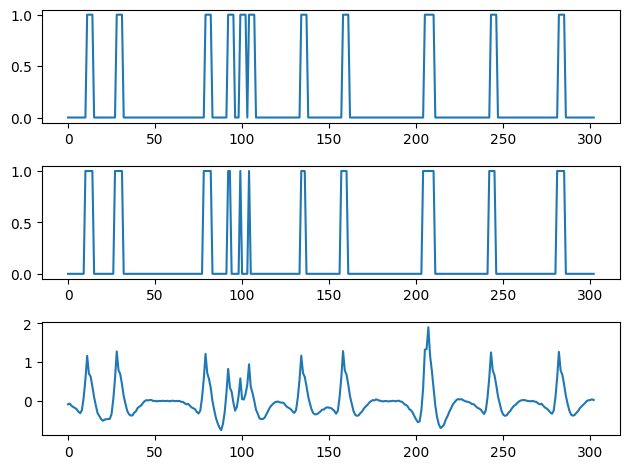

[I 2023-09-13 13:23:23,100] A new study created in memory with name: no-name-9cb8f961-44a1-4ef6-a39e-276b9775bddb
[I 2023-09-13 13:23:23,120] Trial 0 finished with value: 0.7428571428571429 and parameters: {'model': 'svm_linear', 'C': 1.4704831750212992}. Best is trial 0 with value: 0.7428571428571429.
[I 2023-09-13 13:23:23,139] Trial 1 finished with value: 0.7164179104477612 and parameters: {'model': 'svm_linear', 'C': 0.1986333049662717}. Best is trial 0 with value: 0.7428571428571429.
[I 2023-09-13 13:23:23,167] Trial 2 finished with value: 0.7246376811594203 and parameters: {'model': 'svm_linear', 'C': 5.652551166309703}. Best is trial 0 with value: 0.7428571428571429.


On y_hat
running tuna study on metric


[I 2023-09-13 13:23:23,177] Trial 3 finished with value: 0.7058823529411764 and parameters: {'model': 'logistic', 'C': 2.1889466795680574}. Best is trial 0 with value: 0.7428571428571429.
[I 2023-09-13 13:23:23,187] Trial 4 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 20.75952476674107}. Best is trial 0 with value: 0.7428571428571429.
[I 2023-09-13 13:23:23,197] Trial 5 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 45.68474192361139}. Best is trial 0 with value: 0.7428571428571429.
[I 2023-09-13 13:23:23,216] Trial 6 finished with value: 0.6885245901639345 and parameters: {'model': 'svm_linear', 'C': 0.04956947994912167}. Best is trial 0 with value: 0.7428571428571429.
[I 2023-09-13 13:23:23,236] Trial 7 finished with value: 0.676923076923077 and parameters: {'model': 'svm_linear', 'C': 0.0796218752983626}. Best is trial 0 with value: 0.7428571428571429.
[I 2023-09-13 13:23:23,242] Trial 8 finished with value: 0

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.6365783573885742}
Best Validation Set Accuracy: 0.7536231884057972
Test Set Accuracy: 0.8070175438596492


[I 2023-09-13 13:23:23,798] Trial 7 finished with value: 0.7027027027027027 and parameters: {'model': 'svm_linear', 'C': 49.77925724465413}. Best is trial 2 with value: 0.7142857142857143.
[I 2023-09-13 13:23:23,808] Trial 8 finished with value: 0.676056338028169 and parameters: {'model': 'logistic', 'C': 89.52172053776263}. Best is trial 2 with value: 0.7142857142857143.
[I 2023-09-13 13:23:23,859] Trial 9 finished with value: 0.7368421052631577 and parameters: {'model': 'svm_linear', 'C': 6.497315810825624}. Best is trial 9 with value: 0.7368421052631577.
[I 2023-09-13 13:23:23,894] Trial 10 finished with value: 0.7368421052631577 and parameters: {'model': 'svm_linear', 'C': 5.58179903673252}. Best is trial 9 with value: 0.7368421052631577.
[I 2023-09-13 13:23:23,930] Trial 11 finished with value: 0.7368421052631577 and parameters: {'model': 'svm_linear', 'C': 5.370208139512467}. Best is trial 9 with value: 0.7368421052631577.
[I 2023-09-13 13:23:23,973] Trial 12 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 6.497315810825624}
Best Validation Set Accuracy: 0.7368421052631577
Test Set Accuracy: 0.7692307692307692


[I 2023-09-13 13:23:24,681] Trial 10 finished with value: 0.6849315068493151 and parameters: {'model': 'svm_linear', 'C': 87.080326044859}. Best is trial 0 with value: 0.7142857142857143.
[I 2023-09-13 13:23:24,694] Trial 11 finished with value: 0.7142857142857143 and parameters: {'model': 'logistic', 'C': 35.95583839924657}. Best is trial 0 with value: 0.7142857142857143.
[I 2023-09-13 13:23:24,704] Trial 12 finished with value: 0.7142857142857143 and parameters: {'model': 'logistic', 'C': 10.184893112025822}. Best is trial 0 with value: 0.7142857142857143.
[I 2023-09-13 13:23:24,715] Trial 13 finished with value: 0.7142857142857143 and parameters: {'model': 'logistic', 'C': 11.087626681672111}. Best is trial 0 with value: 0.7142857142857143.
[I 2023-09-13 13:23:24,904] Trial 14 finished with value: 0.6849315068493151 and parameters: {'model': 'svm_linear', 'C': 71.61628573472812}. Best is trial 0 with value: 0.7142857142857143.
[I 2023-09-13 13:23:24,915] Trial 15 finished with value

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.6223339320717682}
Best Validation Set Accuracy: 0.7222222222222223
Test Set Accuracy: 0.7384615384615385


[I 2023-09-13 13:23:25,248] Trial 10 finished with value: 0.6666666666666667 and parameters: {'model': 'svm_linear', 'C': 58.11860529198374}. Best is trial 7 with value: 0.7142857142857143.
[I 2023-09-13 13:23:25,267] Trial 11 finished with value: 0.676923076923077 and parameters: {'model': 'svm_linear', 'C': 0.34506113493056667}. Best is trial 7 with value: 0.7142857142857143.
[I 2023-09-13 13:23:25,288] Trial 12 finished with value: 0.676923076923077 and parameters: {'model': 'svm_linear', 'C': 0.18297040929289232}. Best is trial 7 with value: 0.7142857142857143.
[I 2023-09-13 13:23:25,311] Trial 13 finished with value: 0.7142857142857143 and parameters: {'model': 'svm_linear', 'C': 2.2713125777022154}. Best is trial 7 with value: 0.7142857142857143.
[I 2023-09-13 13:23:25,337] Trial 14 finished with value: 0.676470588235294 and parameters: {'model': 'svm_linear', 'C': 6.616139502161093}. Best is trial 7 with value: 0.7142857142857143.
[I 2023-09-13 13:23:25,358] Trial 15 finished wi

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 8.92963085497037}
Best Validation Set Accuracy: 0.7142857142857143
Test Set Accuracy: 0.68


[I 2023-09-13 13:23:25,860] Trial 7 finished with value: 0.7222222222222223 and parameters: {'model': 'svm_linear', 'C': 7.558353988050937}. Best is trial 2 with value: 0.75.
[I 2023-09-13 13:23:25,880] Trial 8 finished with value: 0.6206896551724138 and parameters: {'model': 'svm_linear', 'C': 0.028022393926996216}. Best is trial 2 with value: 0.75.
[I 2023-09-13 13:23:25,899] Trial 9 finished with value: 0.6206896551724138 and parameters: {'model': 'svm_linear', 'C': 0.025955388021762494}. Best is trial 2 with value: 0.75.
[I 2023-09-13 13:23:25,912] Trial 10 finished with value: 0.7142857142857143 and parameters: {'model': 'logistic', 'C': 76.9350916202903}. Best is trial 2 with value: 0.75.
[I 2023-09-13 13:23:25,930] Trial 11 finished with value: 0.7605633802816901 and parameters: {'model': 'svm_linear', 'C': 0.7243315433258587}. Best is trial 11 with value: 0.7605633802816901.
[I 2023-09-13 13:23:25,949] Trial 12 finished with value: 0.7428571428571429 and parameters: {'model': '

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.7243315433258587}
Best Validation Set Accuracy: 0.7605633802816901
Test Set Accuracy: 0.717948717948718


[I 2023-09-13 13:23:26,321] Trial 5 finished with value: 0.696969696969697 and parameters: {'model': 'svm_linear', 'C': 0.404796964861089}. Best is trial 3 with value: 0.7428571428571429.
[I 2023-09-13 13:23:26,392] Trial 6 finished with value: 0.7058823529411764 and parameters: {'model': 'svm_linear', 'C': 17.080224194979007}. Best is trial 3 with value: 0.7428571428571429.
[I 2023-09-13 13:23:26,402] Trial 7 finished with value: 0.7058823529411764 and parameters: {'model': 'logistic', 'C': 3.1690576458059283}. Best is trial 3 with value: 0.7428571428571429.
[I 2023-09-13 13:23:26,412] Trial 8 finished with value: 0.6857142857142857 and parameters: {'model': 'logistic', 'C': 75.44178806271363}. Best is trial 3 with value: 0.7428571428571429.
[I 2023-09-13 13:23:26,418] Trial 9 finished with value: 0.5714285714285715 and parameters: {'model': 'logistic', 'C': 0.11169259765651862}. Best is trial 3 with value: 0.7428571428571429.
[I 2023-09-13 13:23:26,439] Trial 10 finished with value: 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.6662448281732944}
Best Validation Set Accuracy: 0.7428571428571429
Test Set Accuracy: 0.7906976744186046


[I 2023-09-13 13:23:27,056] Trial 2 finished with value: 0.7042253521126761 and parameters: {'model': 'svm_linear', 'C': 99.93245657294523}. Best is trial 2 with value: 0.7042253521126761.
[I 2023-09-13 13:23:27,084] Trial 3 finished with value: 0.6206896551724138 and parameters: {'model': 'svm_linear', 'C': 0.032752002968947556}. Best is trial 2 with value: 0.7042253521126761.
[I 2023-09-13 13:23:27,098] Trial 4 finished with value: 0.6956521739130435 and parameters: {'model': 'logistic', 'C': 52.84231466220236}. Best is trial 2 with value: 0.7042253521126761.
[I 2023-09-13 13:23:27,105] Trial 5 finished with value: 0.09523809523809523 and parameters: {'model': 'logistic', 'C': 0.018331671858874812}. Best is trial 2 with value: 0.7042253521126761.
[I 2023-09-13 13:23:27,116] Trial 6 finished with value: 0.6666666666666667 and parameters: {'model': 'logistic', 'C': 2.967324736374586}. Best is trial 2 with value: 0.7042253521126761.
[I 2023-09-13 13:23:27,138] Trial 7 finished with valu

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.40339810171413465}
Best Validation Set Accuracy: 0.7352941176470589
Test Set Accuracy: 0.7692307692307692


[I 2023-09-13 13:23:27,753] Trial 2 finished with value: 0.6857142857142857 and parameters: {'model': 'svm_linear', 'C': 23.111841071441702}. Best is trial 1 with value: 0.7058823529411764.
[I 2023-09-13 13:23:27,765] Trial 3 finished with value: 0.6857142857142857 and parameters: {'model': 'logistic', 'C': 25.82045615174799}. Best is trial 1 with value: 0.7058823529411764.
[I 2023-09-13 13:23:27,773] Trial 4 finished with value: 0.6562500000000001 and parameters: {'model': 'logistic', 'C': 0.7642581390475313}. Best is trial 1 with value: 0.7058823529411764.
[I 2023-09-13 13:23:27,793] Trial 5 finished with value: 0.6666666666666666 and parameters: {'model': 'svm_linear', 'C': 0.060371439224858506}. Best is trial 1 with value: 0.7058823529411764.
[I 2023-09-13 13:23:27,814] Trial 6 finished with value: 0.4905660377358491 and parameters: {'model': 'svm_linear', 'C': 0.019200396961983356}. Best is trial 1 with value: 0.7058823529411764.
[I 2023-09-13 13:23:27,893] Trial 7 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.21947641510116617}
Best Validation Set Accuracy: 0.7164179104477612
Test Set Accuracy: 0.7384615384615385


[I 2023-09-13 13:23:28,313] Trial 8 finished with value: 0.7142857142857143 and parameters: {'model': 'svm_linear', 'C': 9.24049925934611}. Best is trial 7 with value: 0.7352941176470589.
[I 2023-09-13 13:23:28,331] Trial 9 finished with value: 0.7058823529411764 and parameters: {'model': 'svm_linear', 'C': 0.7884503021441416}. Best is trial 7 with value: 0.7352941176470589.
[I 2023-09-13 13:23:28,426] Trial 10 finished with value: 0.7042253521126761 and parameters: {'model': 'svm_linear', 'C': 31.64753257565146}. Best is trial 7 with value: 0.7352941176470589.
[I 2023-09-13 13:23:28,456] Trial 11 finished with value: 0.7142857142857143 and parameters: {'model': 'svm_linear', 'C': 4.169445213916648}. Best is trial 7 with value: 0.7352941176470589.
[I 2023-09-13 13:23:28,834] Trial 12 finished with value: 0.7042253521126761 and parameters: {'model': 'svm_linear', 'C': 55.149562865221796}. Best is trial 7 with value: 0.7352941176470589.
[I 2023-09-13 13:23:29,112] Trial 13 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.3068700457739096}
Best Validation Set Accuracy: 0.7352941176470589
Test Set Accuracy: 0.8387096774193549


[I 2023-09-13 13:23:29,489] Trial 8 finished with value: 0.72 and parameters: {'model': 'svm_linear', 'C': 0.05176359577542465}. Best is trial 1 with value: 0.875.
[I 2023-09-13 13:23:29,498] Trial 9 finished with value: 0.7586206896551724 and parameters: {'model': 'logistic', 'C': 0.5680082205521079}. Best is trial 1 with value: 0.875.
[I 2023-09-13 13:23:29,866] Trial 10 finished with value: 0.823529411764706 and parameters: {'model': 'svm_linear', 'C': 99.94127577764054}. Best is trial 1 with value: 0.875.
[I 2023-09-13 13:23:29,936] Trial 11 finished with value: 0.875 and parameters: {'model': 'svm_linear', 'C': 17.01450890221621}. Best is trial 1 with value: 0.875.
[I 2023-09-13 13:23:30,015] Trial 12 finished with value: 0.875 and parameters: {'model': 'svm_linear', 'C': 17.91400728072961}. Best is trial 1 with value: 0.875.
[I 2023-09-13 13:23:30,235] Trial 13 finished with value: 0.875 and parameters: {'model': 'svm_linear', 'C': 63.41085504583137}. Best is trial 1 with value: 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 7.182886194031114}
Best Validation Set Accuracy: 0.875
Test Set Accuracy: 0.7294117647058824


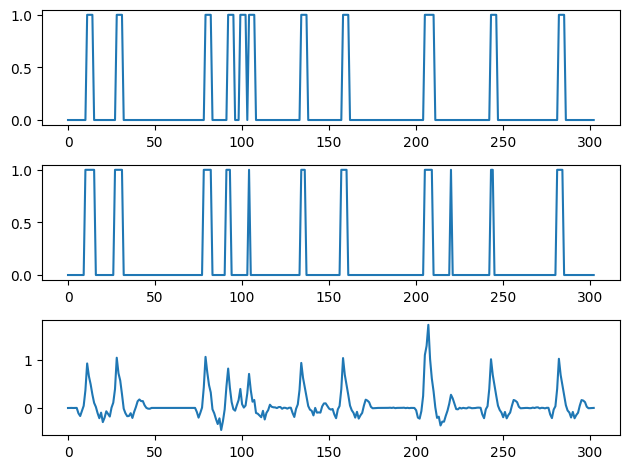

C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_14744\266028130.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
[I 2023-09-13 13:23:31,050] A new study created in memory with name: no-name-8c72dd81-7cc1-48c9-927b-c417ff8c9062
[I 2023-09-13 13:23:31,062] Trial 0 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 41.225578400888416}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,069] Trial 1 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.12152059437120648}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,076] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.42768871390457247}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13

For SNR = 40
On x
running tuna study on metric
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 41.225578400888416}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:23:31,234] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 28.16507092443088}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,241] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 6.13486652781952}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,247] Trial 3 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 95.62707400043217}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,256] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 36.61343228301449}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,261] Trial 5 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 10.616943186725617}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,266] Trial 6 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 66.7224355275671}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,273] Trial 7 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.06265550113746504}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 0.21888101066185442}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:23:31,574] Trial 1 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 10.283798725109104}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,583] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 8.902209412882526}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,590] Trial 3 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.17669902741351}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,595] Trial 4 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.014037727603651599}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,602] Trial 5 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 4.039505086914492}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,607] Trial 6 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.029275177050338778}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,615] Trial 7 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.20930213913480591}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 39.18395437595576}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:23:31,938] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 35.425928400207226}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,945] Trial 3 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 91.69509229887773}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,953] Trial 4 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.025423346237383765}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,959] Trial 5 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 79.60786554954657}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,971] Trial 6 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.011039445825639317}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,985] Trial 7 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.268270964517284}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:31,995] Trial 8 finis

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 31.92708813656286}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.5850661984704446}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:23:32,297] Trial 7 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.07966728478995715}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,305] Trial 8 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 5.3918632505964945}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,314] Trial 9 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 79.98051957483901}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,323] Trial 10 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 4.8819864376293705}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,332] Trial 11 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.523294860533882}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,341] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 15.51027110814156}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,351] Trial 13 finish

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 11.144452830922527}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 1.995207372627838}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:23:32,607] Trial 5 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 4.074147507735219}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,615] Trial 6 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 66.03061609587938}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,621] Trial 7 finished with value: 0.6666666666666666 and parameters: {'model': 'logistic', 'C': 0.04475393137439222}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,630] Trial 8 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.028074207682888062}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,639] Trial 9 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.02546955653965634}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,649] Trial 10 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.6325119737909197}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:23:32,661] 

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 9.567431661033101}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


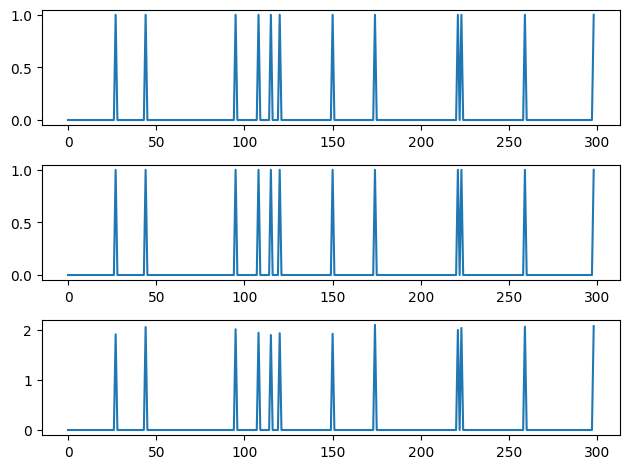

[I 2023-09-13 13:23:32,943] A new study created in memory with name: no-name-6b6eedf1-ab14-4378-b124-2ecd611e148e
[I 2023-09-13 13:23:33,002] Trial 0 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 9.465564756383449}. Best is trial 0 with value: 0.7894736842105262.
[I 2023-09-13 13:23:33,021] Trial 1 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 0.23746552066704518}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:23:33,027] Trial 2 finished with value: 0.13953488372093023 and parameters: {'model': 'logistic', 'C': 0.016343815870506397}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:23:33,046] Trial 3 finished with value: 0.8378378378378379 and parameters: {'model': 'svm_linear', 'C': 1.0772876055850242}. Best is trial 3 with value: 0.8378378378378379.
[I 2023-09-13 13:23:33,095] Trial 4 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 6.49

On y
running tuna study on metric


[I 2023-09-13 13:23:33,132] Trial 6 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 0.5170826412977215}. Best is trial 3 with value: 0.8378378378378379.
[I 2023-09-13 13:23:33,216] Trial 7 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 13.434367713978508}. Best is trial 3 with value: 0.8378378378378379.
[I 2023-09-13 13:23:33,222] Trial 8 finished with value: 0.13953488372093023 and parameters: {'model': 'logistic', 'C': 0.014108625219315185}. Best is trial 3 with value: 0.8378378378378379.
[I 2023-09-13 13:23:33,229] Trial 9 finished with value: 0.4615384615384615 and parameters: {'model': 'logistic', 'C': 0.04932107433347556}. Best is trial 3 with value: 0.8378378378378379.
[I 2023-09-13 13:23:33,239] Trial 10 finished with value: 0.7826086956521738 and parameters: {'model': 'logistic', 'C': 1.4414553971979847}. Best is trial 3 with value: 0.8378378378378379.
[I 2023-09-13 13:23:33,259] Trial 11 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.5428337470895037}
Best Validation Set Accuracy: 0.8493150684931509
Test Set Accuracy: 0.7857142857142857


[I 2023-09-13 13:23:34,203] Trial 0 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 39.78636782685346}. Best is trial 0 with value: 0.7567567567567567.
[I 2023-09-13 13:23:34,212] Trial 1 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 1.2774679323854872}. Best is trial 0 with value: 0.7567567567567567.
[I 2023-09-13 13:23:34,252] Trial 2 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 4.093180140500413}. Best is trial 2 with value: 0.7733333333333333.
[I 2023-09-13 13:23:34,259] Trial 3 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 2.3218554038875947}. Best is trial 2 with value: 0.7733333333333333.
[I 2023-09-13 13:23:34,284] Trial 4 finished with value: 0.6874999999999999 and parameters: {'model': 'svm_linear', 'C': 0.02121297948185715}. Best is trial 2 with value: 0.7733333333333333.
[I 2023-09-13 13:23:34,289] Trial 5 finished with value: 0.4 and para

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.5439095485938445}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8333333333333334


[I 2023-09-13 13:23:35,086] Trial 2 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 66.2296361627533}. Best is trial 0 with value: 0.7837837837837837.
[I 2023-09-13 13:23:35,137] Trial 3 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 5.745949586942398}. Best is trial 0 with value: 0.7837837837837837.
[I 2023-09-13 13:23:35,158] Trial 4 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 0.7590516654241783}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:35,164] Trial 5 finished with value: 0.36734693877551017 and parameters: {'model': 'logistic', 'C': 0.02642286960102907}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:35,303] Trial 6 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 15.34665214353544}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:35,314] Trial 7 finished with valu

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.7590516654241783}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8169014084507044


[I 2023-09-13 13:23:36,117] Trial 10 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 69.61100676327138}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:23:36,168] Trial 11 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 7.698491992801818}. Best is trial 2 with value: 0.7945205479452054.
[I 2023-09-13 13:23:36,277] Trial 12 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 28.466956447762758}. Best is trial 12 with value: 0.8108108108108107.
[I 2023-09-13 13:23:36,924] Trial 13 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 73.29339981437404}. Best is trial 12 with value: 0.8108108108108107.
[I 2023-09-13 13:23:36,995] Trial 14 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 15.50263576454437}. Best is trial 12 with value: 0.8108108108108107.
[I 2023-09-13 13:23:37,099] Trial 15 finished 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 28.466956447762758}
Best Validation Set Accuracy: 0.8108108108108107
Test Set Accuracy: 0.6923076923076924


[I 2023-09-13 13:23:38,546] Trial 2 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 83.3056599940235}. Best is trial 2 with value: 0.8157894736842106.
[I 2023-09-13 13:23:38,558] Trial 3 finished with value: 0.7246376811594203 and parameters: {'model': 'logistic', 'C': 2.2456480837400785}. Best is trial 2 with value: 0.8157894736842106.
[I 2023-09-13 13:23:38,568] Trial 4 finished with value: 0.7246376811594203 and parameters: {'model': 'logistic', 'C': 2.959924515610305}. Best is trial 2 with value: 0.8157894736842106.
[I 2023-09-13 13:23:38,576] Trial 5 finished with value: 0.7352941176470589 and parameters: {'model': 'logistic', 'C': 1.1236895276534657}. Best is trial 2 with value: 0.8157894736842106.
[I 2023-09-13 13:23:38,582] Trial 6 finished with value: 0.5714285714285715 and parameters: {'model': 'logistic', 'C': 0.10287679845437901}. Best is trial 2 with value: 0.8157894736842106.
[I 2023-09-13 13:23:38,589] Trial 7 finished with value: 0.7

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 27.70860761528508}
Best Validation Set Accuracy: 0.8311688311688312
Test Set Accuracy: 0.7654320987654323


[I 2023-09-13 13:23:40,565] Trial 5 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 34.290533343335376}. Best is trial 5 with value: 0.7733333333333333.
[I 2023-09-13 13:23:40,586] Trial 6 finished with value: 0.7297297297297296 and parameters: {'model': 'svm_linear', 'C': 0.09236069847964228}. Best is trial 5 with value: 0.7733333333333333.
[I 2023-09-13 13:23:40,611] Trial 7 finished with value: 0.6206896551724138 and parameters: {'model': 'svm_linear', 'C': 0.012527897516873507}. Best is trial 5 with value: 0.7733333333333333.
[I 2023-09-13 13:23:40,621] Trial 8 finished with value: 0.7142857142857143 and parameters: {'model': 'logistic', 'C': 1.978791093526641}. Best is trial 5 with value: 0.7733333333333333.
[I 2023-09-13 13:23:40,628] Trial 9 finished with value: 0.6333333333333334 and parameters: {'model': 'logistic', 'C': 0.11911010140377765}. Best is trial 5 with value: 0.7733333333333333.
[I 2023-09-13 13:23:41,060] Trial 10 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 34.290533343335376}
Best Validation Set Accuracy: 0.7733333333333333
Test Set Accuracy: 0.8695652173913043


[I 2023-09-13 13:23:43,238] Trial 7 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 27.37638781377404}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:23:43,261] Trial 8 finished with value: 0.6885245901639345 and parameters: {'model': 'svm_linear', 'C': 0.01770140159906827}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:23:43,272] Trial 9 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 52.64761164940518}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:23:43,312] Trial 10 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 5.025807307133109}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:23:43,370] Trial 11 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 7.043293961228931}. Best is trial 6 with value: 0.7999999999999999.
[I 2023-09-13 13:23:43,840] Trial 12 finished with value: 0.7671232876712328 and pa

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.7332336219895697}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8395061728395061


[I 2023-09-13 13:23:44,451] Trial 1 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 89.88569089843814}. Best is trial 0 with value: 0.8157894736842106.
[I 2023-09-13 13:23:44,457] Trial 2 finished with value: 0.04878048780487806 and parameters: {'model': 'logistic', 'C': 0.012044276631971803}. Best is trial 0 with value: 0.8157894736842106.
[I 2023-09-13 13:23:44,471] Trial 3 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 67.10632105919487}. Best is trial 0 with value: 0.8157894736842106.
[I 2023-09-13 13:23:44,489] Trial 4 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.3428963192541557}. Best is trial 0 with value: 0.8157894736842106.
[I 2023-09-13 13:23:44,515] Trial 5 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 2.802899870038398}. Best is trial 0 with value: 0.8157894736842106.
[I 2023-09-13 13:23:44,539] Trial 6 finished with valu

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 21.031159991134878}
Best Validation Set Accuracy: 0.8266666666666667
Test Set Accuracy: 0.7826086956521738


[I 2023-09-13 13:23:45,671] Trial 4 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 32.62354301234796}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:45,679] Trial 5 finished with value: 0.6557377049180327 and parameters: {'model': 'logistic', 'C': 0.155673136134717}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:45,702] Trial 6 finished with value: 0.7058823529411764 and parameters: {'model': 'svm_linear', 'C': 0.03138133261841768}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:45,711] Trial 7 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 11.833142090259992}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:45,718] Trial 8 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 0.9415318283814322}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:23:45,742] Trial 9 finished with value: 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 32.62354301234796}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.9411764705882353


[I 2023-09-13 13:23:49,860] Trial 10 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 78.99424015201213}. Best is trial 10 with value: 0.9411764705882353.
[I 2023-09-13 13:23:50,352] Trial 11 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 64.32622405975142}. Best is trial 10 with value: 0.9411764705882353.
[I 2023-09-13 13:23:50,840] Trial 12 finished with value: 0.9142857142857143 and parameters: {'model': 'svm_linear', 'C': 97.46346253537563}. Best is trial 10 with value: 0.9411764705882353.
[I 2023-09-13 13:23:51,496] Trial 13 finished with value: 0.9142857142857143 and parameters: {'model': 'svm_linear', 'C': 93.66466202101437}. Best is trial 10 with value: 0.9411764705882353.
[I 2023-09-13 13:23:51,648] Trial 14 finished with value: 0.9142857142857143 and parameters: {'model': 'svm_linear', 'C': 18.303713773613456}. Best is trial 10 with value: 0.9411764705882353.
[I 2023-09-13 13:23:51,863] Trial 15 finishe

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 78.99424015201213}
Best Validation Set Accuracy: 0.9411764705882353
Test Set Accuracy: 0.8089887640449438


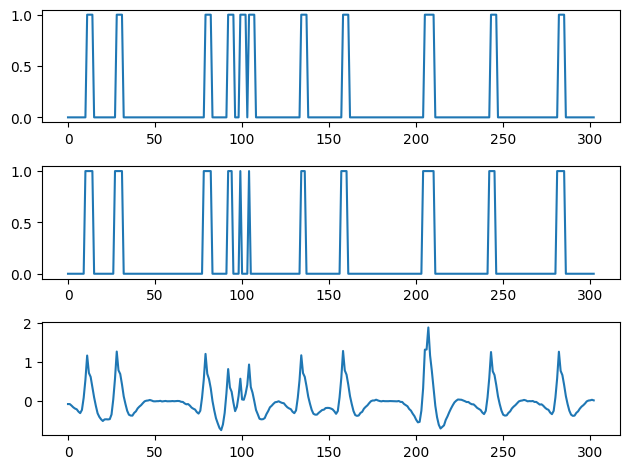

[I 2023-09-13 13:23:53,468] A new study created in memory with name: no-name-752ebf69-4a32-4319-ac85-b33b817c3422
[I 2023-09-13 13:23:53,481] Trial 0 finished with value: 0.821917808219178 and parameters: {'model': 'logistic', 'C': 9.015481563037401}. Best is trial 0 with value: 0.821917808219178.
[I 2023-09-13 13:23:53,490] Trial 1 finished with value: 0.7076923076923077 and parameters: {'model': 'logistic', 'C': 0.3583505472471338}. Best is trial 0 with value: 0.821917808219178.
[I 2023-09-13 13:23:53,498] Trial 2 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 2.0129628434499214}. Best is trial 0 with value: 0.821917808219178.
[I 2023-09-13 13:23:53,541] Trial 3 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 7.426449441494051}. Best is trial 0 with value: 0.821917808219178.


On y_hat
running tuna study on metric


[I 2023-09-13 13:23:53,554] Trial 4 finished with value: 0.821917808219178 and parameters: {'model': 'logistic', 'C': 26.517778108828423}. Best is trial 0 with value: 0.821917808219178.
[I 2023-09-13 13:23:53,582] Trial 5 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 5.509725162741076}. Best is trial 0 with value: 0.821917808219178.
[I 2023-09-13 13:23:53,643] Trial 6 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 9.768850230597172}. Best is trial 0 with value: 0.821917808219178.
[I 2023-09-13 13:23:53,805] Trial 7 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 30.25187192988237}. Best is trial 7 with value: 0.8266666666666667.
[I 2023-09-13 13:23:53,818] Trial 8 finished with value: 0.8055555555555555 and parameters: {'model': 'logistic', 'C': 7.855297432723215}. Best is trial 7 with value: 0.8266666666666667.
[I 2023-09-13 13:23:53,837] Trial 9 finished with value: 0.810

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 30.25187192988237}
Best Validation Set Accuracy: 0.8266666666666667
Test Set Accuracy: 0.7457627118644068


[I 2023-09-13 13:23:56,309] Trial 4 finished with value: 0.6557377049180327 and parameters: {'model': 'logistic', 'C': 0.16101671842374726}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:23:56,315] Trial 5 finished with value: 0.5454545454545454 and parameters: {'model': 'logistic', 'C': 0.07793160850904216}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:23:56,322] Trial 6 finished with value: 0.6774193548387099 and parameters: {'model': 'logistic', 'C': 0.1950742457047671}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:23:56,403] Trial 7 finished with value: 0.7297297297297296 and parameters: {'model': 'svm_linear', 'C': 12.571382879287594}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:23:56,443] Trial 8 finished with value: 0.6206896551724138 and parameters: {'model': 'svm_linear', 'C': 0.014700559938536742}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:23:56,464] Trial 9 finished with va

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 12.081511908187258}
Best Validation Set Accuracy: 0.7671232876712328
Test Set Accuracy: 0.8648648648648649


[I 2023-09-13 13:23:57,003] Trial 3 finished with value: 0.7631578947368423 and parameters: {'model': 'svm_linear', 'C': 39.954260330973945}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:23:57,014] Trial 4 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 2.0326583430866605}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:23:57,026] Trial 5 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 13.953346501551295}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:23:57,047] Trial 6 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 2.2069482381056567}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:23:57,086] Trial 7 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 5.663749807657313}. Best is trial 1 with value: 0.7671232876712328.
[I 2023-09-13 13:23:57,105] Trial 8 finished with value: 0.7567567567567567 and par

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 26.630132853236045}
Best Validation Set Accuracy: 0.7671232876712328
Test Set Accuracy: 0.823529411764706


[I 2023-09-13 13:23:57,486] Trial 3 finished with value: 0.7777777777777777 and parameters: {'model': 'logistic', 'C': 16.257323571257878}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:23:57,527] Trial 4 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 9.128985177059727}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:23:57,541] Trial 5 finished with value: 0.6774193548387099 and parameters: {'model': 'logistic', 'C': 0.2738360222555359}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:23:57,551] Trial 6 finished with value: 0.7352941176470589 and parameters: {'model': 'logistic', 'C': 2.911612054590056}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:23:57,756] Trial 7 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 48.94001231030954}. Best is trial 2 with value: 0.7999999999999999.
[I 2023-09-13 13:23:57,763] Trial 8 finished with value: 0.

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 3.409190004834413}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.7407407407407408


[I 2023-09-13 13:23:58,503] Trial 11 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 95.38831509008013}. Best is trial 2 with value: 0.7887323943661972.
[I 2023-09-13 13:23:58,514] Trial 12 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 28.538319297969117}. Best is trial 2 with value: 0.7887323943661972.
[I 2023-09-13 13:23:58,527] Trial 13 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 19.79978274997967}. Best is trial 2 with value: 0.7887323943661972.
[I 2023-09-13 13:23:58,535] Trial 14 finished with value: 0.7384615384615384 and parameters: {'model': 'logistic', 'C': 0.4611401096504958}. Best is trial 2 with value: 0.7887323943661972.
[I 2023-09-13 13:23:58,546] Trial 15 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 19.01982923986933}. Best is trial 2 with value: 0.7887323943661972.
[I 2023-09-13 13:23:58,555] Trial 16 finished with value: 

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 67.09324650586404}
Best Validation Set Accuracy: 0.7887323943661972
Test Set Accuracy: 0.7123287671232877


[I 2023-09-13 13:23:59,128] Trial 3 finished with value: 0.72 and parameters: {'model': 'svm_linear', 'C': 91.73567069786672}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:23:59,149] Trial 4 finished with value: 0.6885245901639345 and parameters: {'model': 'svm_linear', 'C': 0.02610862722201966}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:23:59,162] Trial 5 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 13.977688536267}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:23:59,181] Trial 6 finished with value: 0.7777777777777777 and parameters: {'model': 'svm_linear', 'C': 0.07455599392403454}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:23:59,192] Trial 7 finished with value: 0.7397260273972603 and parameters: {'model': 'logistic', 'C': 37.223833483671285}. Best is trial 1 with value: 0.7837837837837837.
[I 2023-09-13 13:23:59,511] Trial 8 finished with value: 0.72 and parameters: {'mode

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.573629776783128}
Best Validation Set Accuracy: 0.7894736842105262
Test Set Accuracy: 0.8181818181818182


[I 2023-09-13 13:24:00,016] Trial 5 finished with value: 0.7792207792207791 and parameters: {'model': 'svm_linear', 'C': 25.165174637950823}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:24:00,206] Trial 6 finished with value: 0.7792207792207791 and parameters: {'model': 'svm_linear', 'C': 30.663755570462644}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:24:00,213] Trial 7 finished with value: 0.09523809523809523 and parameters: {'model': 'logistic', 'C': 0.016019175046511906}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:24:00,305] Trial 8 finished with value: 0.7792207792207791 and parameters: {'model': 'svm_linear', 'C': 24.865024459054755}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:24:00,325] Trial 9 finished with value: 0.696969696969697 and parameters: {'model': 'svm_linear', 'C': 0.03317886018288968}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:24:00,335] Trial 10 finished wit

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.33201371366239374}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8333333333333334


[I 2023-09-13 13:24:01,352] Trial 5 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 57.73166404385883}. Best is trial 2 with value: 0.7733333333333333.
[I 2023-09-13 13:24:01,372] Trial 6 finished with value: 0.7352941176470589 and parameters: {'model': 'svm_linear', 'C': 0.04661467155828481}. Best is trial 2 with value: 0.7733333333333333.
[I 2023-09-13 13:24:01,388] Trial 7 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 0.5448127146275783}. Best is trial 7 with value: 0.7945205479452054.
[I 2023-09-13 13:24:01,422] Trial 8 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 8.553008137067927}. Best is trial 7 with value: 0.7945205479452054.
[I 2023-09-13 13:24:01,591] Trial 9 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 53.07229652997326}. Best is trial 7 with value: 0.7945205479452054.
[I 2023-09-13 13:24:01,603] Trial 10 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.33388710760368107}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.7096774193548387


[I 2023-09-13 13:24:02,289] Trial 9 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 50.253723261416425}. Best is trial 6 with value: 0.8108108108108107.
[I 2023-09-13 13:24:02,313] Trial 10 finished with value: 0.5185185185185185 and parameters: {'model': 'svm_linear', 'C': 0.011135893020348044}. Best is trial 6 with value: 0.8108108108108107.
[I 2023-09-13 13:24:02,328] Trial 11 finished with value: 0.7567567567567567 and parameters: {'model': 'logistic', 'C': 6.107156957410935}. Best is trial 6 with value: 0.8108108108108107.
[I 2023-09-13 13:24:02,341] Trial 12 finished with value: 0.7567567567567567 and parameters: {'model': 'logistic', 'C': 3.529033041287822}. Best is trial 6 with value: 0.8108108108108107.
[I 2023-09-13 13:24:02,362] Trial 13 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 0.17499511818975685}. Best is trial 6 with value: 0.8108108108108107.
[I 2023-09-13 13:24:02,384] Trial 14 finished with value: 0.810

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.24879155896949956}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.888888888888889


[I 2023-09-13 13:24:02,781] Trial 2 finished with value: 0.9142857142857143 and parameters: {'model': 'svm_linear', 'C': 48.92864827960136}. Best is trial 0 with value: 0.9142857142857143.
[I 2023-09-13 13:24:02,803] Trial 3 finished with value: 0.4 and parameters: {'model': 'svm_linear', 'C': 0.010555211444924845}. Best is trial 0 with value: 0.9142857142857143.
[I 2023-09-13 13:24:02,855] Trial 4 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 12.899870967876723}. Best is trial 4 with value: 0.9411764705882353.
[I 2023-09-13 13:24:02,867] Trial 5 finished with value: 0.875 and parameters: {'model': 'logistic', 'C': 1.1849316246931596}. Best is trial 4 with value: 0.9411764705882353.
[I 2023-09-13 13:24:02,874] Trial 6 finished with value: 0.6923076923076923 and parameters: {'model': 'logistic', 'C': 0.09795025342113876}. Best is trial 4 with value: 0.9411764705882353.
[I 2023-09-13 13:24:02,883] Trial 7 finished with value: 0.875 and parameters: {

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 12.899870967876723}
Best Validation Set Accuracy: 0.9411764705882353
Test Set Accuracy: 0.7906976744186046


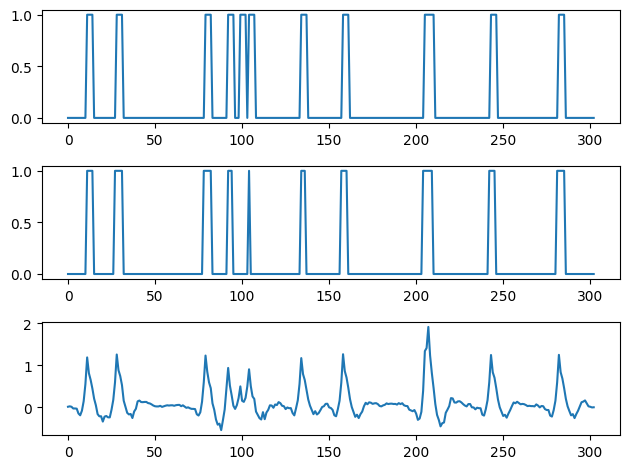

C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_14744\266028130.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
[I 2023-09-13 13:24:04,640] A new study created in memory with name: no-name-42acb165-3555-4266-9049-2e4cc0f8c08a
[I 2023-09-13 13:24:04,648] Trial 0 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.0236034922632147}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:04,656] Trial 1 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 10.405418716832363}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:04,661] Trial 2 finished with value: 0.7777777777777778 and parameters: {'model': 'logistic', 'C': 0.038897249962300505}. Best is trial 0 with value: 1.0.
[

For SNR = 45
On x
running tuna study on metric
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 1.0236034922632147}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:04,825] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 11.845103561016476}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:04,832] Trial 3 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.17876013886208078}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:04,840] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 36.67145507449259}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:04,845] Trial 5 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 9.392996673259654}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:04,850] Trial 6 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 5.63786248665879}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:04,858] Trial 7 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 21.082765419418077}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:04,866] Trial 8 finished with v

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 18.82140626812782}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 87.63598408649787}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:05,170] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 6.047866944199776}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,178] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.05972964781789686}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,186] Trial 3 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 5.098032148744739}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,198] Trial 4 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.01630166348522248}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,210] Trial 5 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.0162453746730405}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,218] Trial 6 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 2.8624876993098174}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,223] Trial 7 finished

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.3586684244768059}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:05,527] Trial 19 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.03461162897617345}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:05,538] A new study created in memory with name: no-name-fc19983f-739f-444f-9349-20cdff7ec623
[I 2023-09-13 13:24:05,547] Trial 0 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 78.02378331520737}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,553] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 5.2100430244090115}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,562] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.03051384926441467}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,569] Trial 3 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 22.2537646107733}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,578] Trial 4 finished with value: 1.0 and parameters: {'model': '

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.043049202943345216}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 78.02378331520737}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:05,733] Trial 3 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 50.43129047966339}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,741] Trial 4 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 15.324046531328387}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,749] Trial 5 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 28.48944861442781}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,754] Trial 6 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.9377409698883683}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,760] Trial 7 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.02013389082372644}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,767] Trial 8 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 7.843357614676855}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:05,772] Trial 9 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 68.07684736764529}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:06,045] A new study created in memory with name: no-name-818acdf5-6ebf-493e-aff7-8e0e671307ef
[I 2023-09-13 13:24:06,052] Trial 0 finished with value: 0.7777777777777778 and parameters: {'model': 'logistic', 'C': 0.03693408818513268}. Best is trial 0 with value: 0.7777777777777778.
[I 2023-09-13 13:24:06,056] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 38.619051839543516}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:06,060] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.23614729646911783}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:06,066] Trial 3 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.01813523777468838}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:06,077] Trial 4 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.0686743304486382}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:06,086] Trial 5 finished with value: 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 81.99574113749244}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0
Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 38.619051839543516}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:06,234] Trial 4 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.013659607421337002}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:06,242] Trial 5 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.8791087263370367}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:06,247] Trial 6 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.010233908326090144}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:06,250] Trial 7 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 6.529605694724403}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:06,254] Trial 8 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.0500990322012371}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:06,260] Trial 9 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.034998976800808775}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:06,270] Trial 10 fini

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 41.114252660538554}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


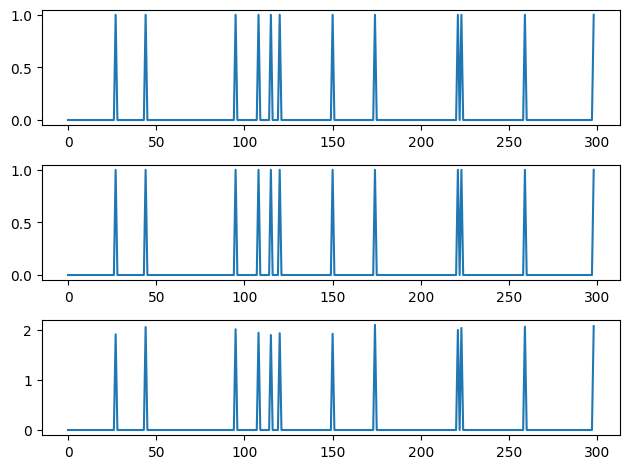

[I 2023-09-13 13:24:06,487] A new study created in memory with name: no-name-b5e53da3-06c4-4ef7-a158-e0ee1ff53af5


On y
running tuna study on metric


[I 2023-09-13 13:24:06,788] Trial 0 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 38.32131928339092}. Best is trial 0 with value: 0.7999999999999999.
[I 2023-09-13 13:24:06,815] Trial 1 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 2.3047717983996043}. Best is trial 0 with value: 0.7999999999999999.
[I 2023-09-13 13:24:06,826] Trial 2 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 3.445763670509865}. Best is trial 0 with value: 0.7999999999999999.
[I 2023-09-13 13:24:06,835] Trial 3 finished with value: 0.6874999999999999 and parameters: {'model': 'logistic', 'C': 0.3732110854215235}. Best is trial 0 with value: 0.7999999999999999.
[I 2023-09-13 13:24:06,854] Trial 4 finished with value: 0.8378378378378379 and parameters: {'model': 'svm_linear', 'C': 0.7640793547996475}. Best is trial 4 with value: 0.8378378378378379.
[I 2023-09-13 13:24:06,877] Trial 5 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.7640793547996475}
Best Validation Set Accuracy: 0.8378378378378379
Test Set Accuracy: 0.7636363636363638


[I 2023-09-13 13:24:08,652] Trial 10 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 53.38728525024847}. Best is trial 4 with value: 0.7837837837837837.
[I 2023-09-13 13:24:08,665] Trial 11 finished with value: 0.7837837837837837 and parameters: {'model': 'logistic', 'C': 15.178901259463014}. Best is trial 4 with value: 0.7837837837837837.
[I 2023-09-13 13:24:08,676] Trial 12 finished with value: 0.7837837837837837 and parameters: {'model': 'logistic', 'C': 14.769325903436759}. Best is trial 4 with value: 0.7837837837837837.
[I 2023-09-13 13:24:08,686] Trial 13 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 87.734761133489}. Best is trial 4 with value: 0.7837837837837837.
[I 2023-09-13 13:24:08,787] Trial 14 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 8.965483531321171}. Best is trial 4 with value: 0.7837837837837837.
[I 2023-09-13 13:24:08,798] Trial 15 finished with value

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 15.296871189037429}
Best Validation Set Accuracy: 0.7837837837837837
Test Set Accuracy: 0.7999999999999999


[I 2023-09-13 13:24:09,428] Trial 10 finished with value: 0.7466666666666666 and parameters: {'model': 'svm_linear', 'C': 69.66758558111168}. Best is trial 5 with value: 0.7999999999999999.
[I 2023-09-13 13:24:09,440] Trial 11 finished with value: 0.7999999999999999 and parameters: {'model': 'logistic', 'C': 82.34835613248988}. Best is trial 5 with value: 0.7999999999999999.
[I 2023-09-13 13:24:09,450] Trial 12 finished with value: 0.7837837837837837 and parameters: {'model': 'logistic', 'C': 23.521142481299933}. Best is trial 5 with value: 0.7999999999999999.
[I 2023-09-13 13:24:09,460] Trial 13 finished with value: 0.7837837837837837 and parameters: {'model': 'logistic', 'C': 15.16428469445704}. Best is trial 5 with value: 0.7999999999999999.
[I 2023-09-13 13:24:09,470] Trial 14 finished with value: 0.7999999999999999 and parameters: {'model': 'logistic', 'C': 94.61300800413365}. Best is trial 5 with value: 0.7999999999999999.
[I 2023-09-13 13:24:09,480] Trial 15 finished with value:

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 66.98564020935437}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.823529411764706


[I 2023-09-13 13:24:10,227] Trial 7 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 85.9271781519647}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:24:10,438] Trial 8 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 29.29636771661744}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:24:10,541] Trial 9 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 12.839079662533756}. Best is trial 9 with value: 0.8108108108108107.
[I 2023-09-13 13:24:10,577] Trial 10 finished with value: 0.821917808219178 and parameters: {'model': 'svm_linear', 'C': 3.652669918153007}. Best is trial 10 with value: 0.821917808219178.
[I 2023-09-13 13:24:10,624] Trial 11 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 4.387961564269654}. Best is trial 10 with value: 0.821917808219178.
[I 2023-09-13 13:24:10,656] Trial 12 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 3.652669918153007}
Best Validation Set Accuracy: 0.821917808219178
Test Set Accuracy: 0.7169811320754718


[I 2023-09-13 13:24:11,303] Trial 5 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 27.243260225415337}. Best is trial 2 with value: 0.8266666666666667.
[I 2023-09-13 13:24:11,495] Trial 6 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 41.62116456324153}. Best is trial 2 with value: 0.8266666666666667.
[I 2023-09-13 13:24:11,516] Trial 7 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 2.3500644870650906}. Best is trial 2 with value: 0.8266666666666667.
[I 2023-09-13 13:24:11,526] Trial 8 finished with value: 0.7246376811594203 and parameters: {'model': 'logistic', 'C': 23.07740492500592}. Best is trial 2 with value: 0.8266666666666667.
[I 2023-09-13 13:24:11,546] Trial 9 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 1.3286796346239047}. Best is trial 2 with value: 0.8266666666666667.
[I 2023-09-13 13:24:11,556] Trial 10 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 4.059830012185005}
Best Validation Set Accuracy: 0.8311688311688312
Test Set Accuracy: 0.759493670886076


[I 2023-09-13 13:24:12,755] Trial 2 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 63.525371729823036}. Best is trial 0 with value: 0.7567567567567567.
[I 2023-09-13 13:24:12,763] Trial 3 finished with value: 0.6562500000000001 and parameters: {'model': 'logistic', 'C': 0.2698669636109385}. Best is trial 0 with value: 0.7567567567567567.
[I 2023-09-13 13:24:12,783] Trial 4 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.1928349592465505}. Best is trial 4 with value: 0.7671232876712328.
[I 2023-09-13 13:24:12,789] Trial 5 finished with value: 0.4615384615384615 and parameters: {'model': 'logistic', 'C': 0.0456995031058679}. Best is trial 4 with value: 0.7671232876712328.
[I 2023-09-13 13:24:12,794] Trial 6 finished with value: 0.4905660377358491 and parameters: {'model': 'logistic', 'C': 0.04624719409956824}. Best is trial 4 with value: 0.7671232876712328.
[I 2023-09-13 13:24:12,801] Trial 7 finished with value

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.7658438020649823}
Best Validation Set Accuracy: 0.7837837837837837
Test Set Accuracy: 0.888888888888889


[I 2023-09-13 13:24:14,564] Trial 0 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 59.04099529824773}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:24:14,582] Trial 1 finished with value: 0.7397260273972603 and parameters: {'model': 'svm_linear', 'C': 0.3611309697932215}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:24:14,588] Trial 2 finished with value: 0.5185185185185185 and parameters: {'model': 'logistic', 'C': 0.06237822928368482}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:24:14,593] Trial 3 finished with value: 0.4905660377358491 and parameters: {'model': 'logistic', 'C': 0.05610857727719275}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:24:14,795] Trial 4 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 18.27227027426156}. Best is trial 0 with value: 0.7671232876712328.
[I 2023-09-13 13:24:14,812] Trial 5 finished with valu

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 59.04099529824773}
Best Validation Set Accuracy: 0.7671232876712328
Test Set Accuracy: 0.8536585365853658


[I 2023-09-13 13:24:21,001] Trial 8 finished with value: 0.6956521739130435 and parameters: {'model': 'svm_linear', 'C': 0.040662160196598546}. Best is trial 7 with value: 0.7671232876712328.
[I 2023-09-13 13:24:21,014] Trial 9 finished with value: 0.7567567567567567 and parameters: {'model': 'logistic', 'C': 83.76978074597866}. Best is trial 7 with value: 0.7671232876712328.
[I 2023-09-13 13:24:21,083] Trial 10 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 5.845130514545519}. Best is trial 10 with value: 0.8266666666666667.
[I 2023-09-13 13:24:21,150] Trial 11 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 5.6356834713150725}. Best is trial 10 with value: 0.8266666666666667.
[I 2023-09-13 13:24:21,228] Trial 12 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 6.503233924688957}. Best is trial 10 with value: 0.8266666666666667.
[I 2023-09-13 13:24:21,283] Trial 13 finished w

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 5.845130514545519}
Best Validation Set Accuracy: 0.8266666666666667
Test Set Accuracy: 0.7647058823529411


[I 2023-09-13 13:24:22,214] Trial 0 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 31.57640146348217}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:24:22,231] Trial 1 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 1.1478853121974604}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:24:22,278] Trial 2 finished with value: 0.6885245901639345 and parameters: {'model': 'svm_linear', 'C': 0.015067445679670834}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:24:22,315] Trial 3 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 0.10194827720796514}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:24:22,327] Trial 4 finished with value: 0.2222222222222222 and parameters: {'model': 'logistic', 'C': 0.01674717725611771}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:24:22,342] Trial 5 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.8237954828574795}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.888888888888889


[I 2023-09-13 13:24:25,167] Trial 3 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 26.435486953388494}. Best is trial 3 with value: 0.9411764705882353.
[I 2023-09-13 13:24:25,178] Trial 4 finished with value: 0.875 and parameters: {'model': 'logistic', 'C': 1.419898174691128}. Best is trial 3 with value: 0.9411764705882353.
[I 2023-09-13 13:24:25,218] Trial 5 finished with value: 0.888888888888889 and parameters: {'model': 'svm_linear', 'C': 0.633386326494269}. Best is trial 3 with value: 0.9411764705882353.
[I 2023-09-13 13:24:25,264] Trial 6 finished with value: 0.8275862068965517 and parameters: {'model': 'svm_linear', 'C': 0.025611149129530216}. Best is trial 3 with value: 0.9411764705882353.
[I 2023-09-13 13:24:25,279] Trial 7 finished with value: 0.875 and parameters: {'model': 'logistic', 'C': 9.17031003803752}. Best is trial 3 with value: 0.9411764705882353.
[I 2023-09-13 13:24:25,315] Trial 8 finished with value: 0.888888888888889 and para

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 26.435486953388494}
Best Validation Set Accuracy: 0.9411764705882353
Test Set Accuracy: 0.7954545454545455


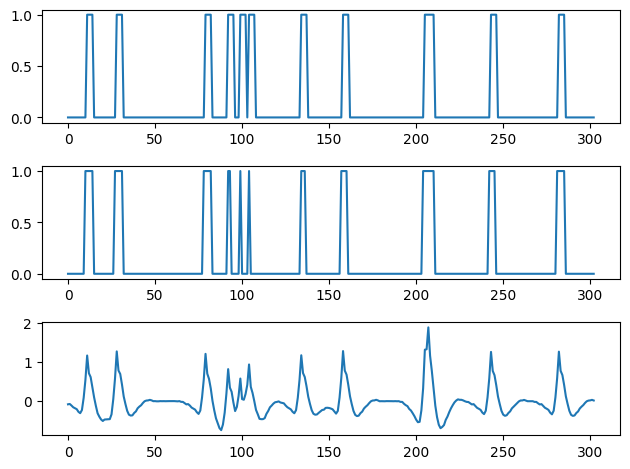

[I 2023-09-13 13:24:30,235] A new study created in memory with name: no-name-b56e64d7-c734-4f88-8ffb-bb877c4fb96c
[I 2023-09-13 13:24:30,252] Trial 0 finished with value: 0.8055555555555555 and parameters: {'model': 'logistic', 'C': 4.971144097765321}. Best is trial 0 with value: 0.8055555555555555.


On y_hat
running tuna study on metric


[I 2023-09-13 13:24:30,440] Trial 1 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 15.251818482750302}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:24:30,477] Trial 2 finished with value: 0.7605633802816901 and parameters: {'model': 'svm_linear', 'C': 0.10375959759805876}. Best is trial 1 with value: 0.8108108108108107.
[I 2023-09-13 13:24:30,496] Trial 3 finished with value: 0.821917808219178 and parameters: {'model': 'logistic', 'C': 16.03836541402736}. Best is trial 3 with value: 0.821917808219178.
[I 2023-09-13 13:24:30,514] Trial 4 finished with value: 0.8055555555555555 and parameters: {'model': 'logistic', 'C': 5.5251887264168085}. Best is trial 3 with value: 0.821917808219178.
[I 2023-09-13 13:24:30,765] Trial 5 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 19.835315091832566}. Best is trial 3 with value: 0.821917808219178.
[I 2023-09-13 13:24:30,780] Trial 6 finished with value: 0

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 16.03836541402736}
Best Validation Set Accuracy: 0.821917808219178
Test Set Accuracy: 0.7586206896551724


[I 2023-09-13 13:24:33,091] Trial 4 finished with value: 0.7397260273972603 and parameters: {'model': 'svm_linear', 'C': 95.65185967691453}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:24:33,110] Trial 5 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 34.415890148794524}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:24:33,125] Trial 6 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 1.8036934701866227}. Best is trial 3 with value: 0.7671232876712328.
[I 2023-09-13 13:24:33,162] Trial 7 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 1.56627372367503}. Best is trial 7 with value: 0.7733333333333333.
[I 2023-09-13 13:24:33,197] Trial 8 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 0.16701151896108427}. Best is trial 8 with value: 0.8157894736842106.
[I 2023-09-13 13:24:33,238] Trial 9 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.16701151896108427}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.8333333333333334


[I 2023-09-13 13:24:33,898] Trial 7 finished with value: 0.7466666666666666 and parameters: {'model': 'svm_linear', 'C': 4.987076160390776}. Best is trial 5 with value: 0.7671232876712328.
[I 2023-09-13 13:24:34,009] Trial 8 finished with value: 0.7532467532467533 and parameters: {'model': 'svm_linear', 'C': 15.898715246071797}. Best is trial 5 with value: 0.7671232876712328.
[I 2023-09-13 13:24:34,022] Trial 9 finished with value: 0.6206896551724138 and parameters: {'model': 'logistic', 'C': 0.0948055774703472}. Best is trial 5 with value: 0.7671232876712328.
[I 2023-09-13 13:24:34,043] Trial 10 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 92.8906194552797}. Best is trial 5 with value: 0.7671232876712328.
[I 2023-09-13 13:24:34,066] Trial 11 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 99.84450482690296}. Best is trial 5 with value: 0.7671232876712328.
[I 2023-09-13 13:24:34,088] Trial 12 finished with value: 

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 13.898970261553215}
Best Validation Set Accuracy: 0.7671232876712328
Test Set Accuracy: 0.8059701492537314


[I 2023-09-13 13:24:34,440] Trial 7 finished with value: 0.7945205479452054 and parameters: {'model': 'logistic', 'C': 16.763443352846547}. Best is trial 3 with value: 0.7945205479452054.
[I 2023-09-13 13:24:34,573] Trial 8 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 22.486114276630513}. Best is trial 3 with value: 0.7945205479452054.
[I 2023-09-13 13:24:34,590] Trial 9 finished with value: 0.6666666666666667 and parameters: {'model': 'logistic', 'C': 0.4099212887380752}. Best is trial 3 with value: 0.7945205479452054.
[I 2023-09-13 13:24:34,636] Trial 10 finished with value: 0.5964912280701754 and parameters: {'model': 'svm_linear', 'C': 0.013099592977958865}. Best is trial 3 with value: 0.7945205479452054.
[I 2023-09-13 13:24:34,658] Trial 11 finished with value: 0.7352941176470589 and parameters: {'model': 'logistic', 'C': 4.637922744081594}. Best is trial 3 with value: 0.7945205479452054.
[I 2023-09-13 13:24:34,716] Trial 12 finished with va

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.2515332501178708}
Best Validation Set Accuracy: 0.7945205479452054
Test Set Accuracy: 0.7058823529411765


[I 2023-09-13 13:24:35,913] Trial 3 finished with value: 0.7887323943661972 and parameters: {'model': 'logistic', 'C': 91.23939385157998}. Best is trial 0 with value: 0.7945205479452054.
[I 2023-09-13 13:24:36,104] Trial 4 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 35.60606370977266}. Best is trial 4 with value: 0.8108108108108107.
[I 2023-09-13 13:24:36,116] Trial 5 finished with value: 0.7246376811594203 and parameters: {'model': 'logistic', 'C': 1.7527132520568187}. Best is trial 4 with value: 0.8108108108108107.
[I 2023-09-13 13:24:36,378] Trial 6 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 43.034025795506395}. Best is trial 4 with value: 0.8108108108108107.
[I 2023-09-13 13:24:36,435] Trial 7 finished with value: 0.7605633802816901 and parameters: {'model': 'svm_linear', 'C': 4.9747622870120285}. Best is trial 4 with value: 0.8108108108108107.
[I 2023-09-13 13:24:36,471] Trial 8 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 35.60606370977266}
Best Validation Set Accuracy: 0.8108108108108107
Test Set Accuracy: 0.7297297297297297


[I 2023-09-13 13:24:38,042] Trial 2 finished with value: 0.6666666666666666 and parameters: {'model': 'svm_linear', 'C': 0.019568567242387206}. Best is trial 1 with value: 0.7567567567567567.
[I 2023-09-13 13:24:38,075] Trial 3 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 0.3635426786195172}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:24:38,124] Trial 4 finished with value: 0.7397260273972603 and parameters: {'model': 'svm_linear', 'C': 5.122009369506974}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:24:38,174] Trial 5 finished with value: 0.7397260273972603 and parameters: {'model': 'svm_linear', 'C': 4.161740735327907}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:24:38,213] Trial 6 finished with value: 0.7466666666666666 and parameters: {'model': 'svm_linear', 'C': 1.8666359158487722}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:24:38,226] Trial 7 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.1434983307336171}
Best Validation Set Accuracy: 0.7945205479452054
Test Set Accuracy: 0.8444444444444444


[I 2023-09-13 13:24:38,925] Trial 1 finished with value: 0.7631578947368423 and parameters: {'model': 'svm_linear', 'C': 23.143056113090633}. Best is trial 1 with value: 0.7631578947368423.
[I 2023-09-13 13:24:38,943] Trial 2 finished with value: 0.7567567567567567 and parameters: {'model': 'logistic', 'C': 6.1767661680152015}. Best is trial 1 with value: 0.7631578947368423.
[I 2023-09-13 13:24:38,958] Trial 3 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 1.321783940782294}. Best is trial 1 with value: 0.7631578947368423.
[I 2023-09-13 13:24:38,973] Trial 4 finished with value: 0.6774193548387099 and parameters: {'model': 'logistic', 'C': 0.18747583419261493}. Best is trial 1 with value: 0.7631578947368423.
[I 2023-09-13 13:24:38,991] Trial 5 finished with value: 0.7567567567567567 and parameters: {'model': 'logistic', 'C': 48.99302109579014}. Best is trial 1 with value: 0.7631578947368423.
[I 2023-09-13 13:24:39,005] Trial 6 finished with value: 0.71428571428571

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 6.795208222165108}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8705882352941177


[I 2023-09-13 13:24:41,945] Trial 3 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 14.105340049619198}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:24:41,958] Trial 4 finished with value: 0.4615384615384615 and parameters: {'model': 'logistic', 'C': 0.048740540790772294}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:24:42,125] Trial 5 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 20.686972208330882}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:24:42,159] Trial 6 finished with value: 0.7887323943661972 and parameters: {'model': 'svm_linear', 'C': 0.2041289964848434}. Best is trial 6 with value: 0.7887323943661972.
[I 2023-09-13 13:24:42,185] Trial 7 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.4349879669151601}. Best is trial 6 with value: 0.7887323943661972.
[I 2023-09-13 13:24:42,206] Trial 8 finished with 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.160883845615305}
Best Validation Set Accuracy: 0.8055555555555555
Test Set Accuracy: 0.6984126984126984


[I 2023-09-13 13:24:43,351] Trial 2 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 32.598729884451615}. Best is trial 2 with value: 0.75.
[I 2023-09-13 13:24:43,389] Trial 3 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 0.18061511619388695}. Best is trial 3 with value: 0.8108108108108107.
[I 2023-09-13 13:24:43,401] Trial 4 finished with value: 0.6206896551724138 and parameters: {'model': 'logistic', 'C': 0.09610575017571105}. Best is trial 3 with value: 0.8108108108108107.
[I 2023-09-13 13:24:43,582] Trial 5 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 22.77439243042672}. Best is trial 3 with value: 0.8108108108108107.
[I 2023-09-13 13:24:43,616] Trial 6 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 0.25310378676054934}. Best is trial 3 with value: 0.8108108108108107.
[I 2023-09-13 13:24:43,663] Trial 7 finished with value: 0.7428571428571429 and parameters: 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.18061511619388695}
Best Validation Set Accuracy: 0.8108108108108107
Test Set Accuracy: 0.888888888888889


[I 2023-09-13 13:24:44,440] Trial 1 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 38.545059394757516}. Best is trial 0 with value: 0.9411764705882353.
[I 2023-09-13 13:24:44,456] Trial 2 finished with value: 0.875 and parameters: {'model': 'logistic', 'C': 1.109764676974899}. Best is trial 0 with value: 0.9411764705882353.
[I 2023-09-13 13:24:44,468] Trial 3 finished with value: 0.4 and parameters: {'model': 'logistic', 'C': 0.04881581774929397}. Best is trial 0 with value: 0.9411764705882353.
[I 2023-09-13 13:24:44,501] Trial 4 finished with value: 0.9142857142857143 and parameters: {'model': 'svm_linear', 'C': 0.6010143868573664}. Best is trial 0 with value: 0.9411764705882353.
[I 2023-09-13 13:24:44,551] Trial 5 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 3.91248499153473}. Best is trial 0 with value: 0.9411764705882353.
[I 2023-09-13 13:24:44,623] Trial 6 finished with value: 0.9411764705882353 and para

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 6.521604306650143}
Best Validation Set Accuracy: 0.9411764705882353
Test Set Accuracy: 0.7816091954022988


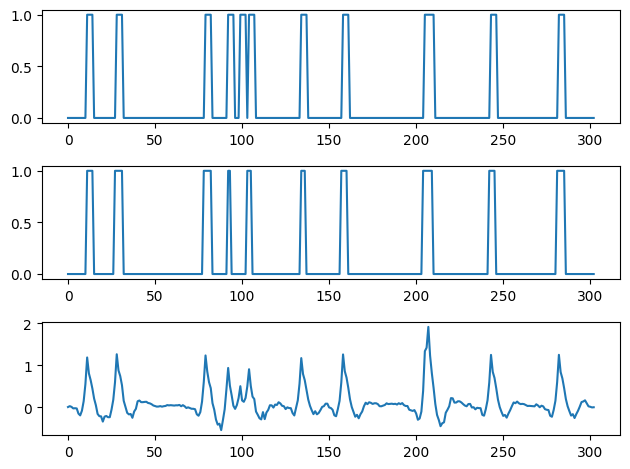

C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_14744\266028130.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
[I 2023-09-13 13:24:46,617] A new study created in memory with name: no-name-8e3987b8-bbc1-4e95-9efb-f62e9d373629
[I 2023-09-13 13:24:46,629] Trial 0 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 6.3510008718008075}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:46,640] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 5.003961663575968}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:46,664] Trial 2 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.01847597153247703}. Best is trial 0 with value: 1.0.
[I 2023-09-1

For SNR = 50
On x
running tuna study on metric


[I 2023-09-13 13:24:46,806] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.2853536673938204}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:46,821] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 17.853503035130903}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:46,833] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.4032939678507747}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:46,849] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 3.01134971122177}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:46,864] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 23.63374216531476}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:46,879] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.16768178806769993}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:46,895] Trial 19

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 6.3510008718008075}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:47,106] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 5.428987907973693}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,125] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 24.68795948805404}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,139] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 6.466304573772781}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,158] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 32.79431602380305}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,172] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.797215162005181}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,190] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 33.29562366356267}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,204] Trial 19 finished 

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 38.184076295768364}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:47,415] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 6.9683138145417445}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,433] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.097332090097587}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,452] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 28.792340094274593}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,471] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 6.428114489318015}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,485] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.32624538418733623}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,503] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.478860316127243}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,522] Trial 18

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.841119765145645}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:47,747] Trial 11 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 78.40939097554595}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,763] Trial 12 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.2665114879818116}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,781] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 62.855405658811975}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,802] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.5552895673004036}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,822] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 15.263465111282315}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,842] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.7633197317024403}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:47,858] Trial 17 finish

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.027639935294120576}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:48,117] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.08977695402552884}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,131] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 3.492744692355227}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,144] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.45954450497417343}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,156] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.4672219701434366}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,186] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.011222469495378778}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,200] Trial 18 finished with value: 0.7777777777777778 and parameters: {'model': 'logistic', 'C': 0.04314110816903765}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.121226464687957}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:48,421] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.8132127846550015}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,430] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 90.65049603637918}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,443] Trial 15 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.014438093463079706}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,462] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 23.690440821859152}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,477] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 10.543948589685463}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,493] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 5.131521278266158}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,509] Trial 19 f

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 3.9629611677631473}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:48,736] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.012333008824773662}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,753] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.5545364416823557}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,772] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.09981512995588473}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,790] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 1.085112942635376}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,804] Trial 18 finished with value: 0.8421052631578948 and parameters: {'model': 'logistic', 'C': 0.04410576923641381}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48,817] Trial 19 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.3577824354539215}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:48

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 25.683296946238794}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:49,015] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.974264594484557}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:49,033] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.7368316560521222}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:49,055] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.082171169335687}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:49,077] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.09211838489499607}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:49,095] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.6944304339881546}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:49,113] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 9.12576622866472}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:24:49,130] Trial 19 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.021140896094417015}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:49,358] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.010359560458056362}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,373] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.07139534838766129}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,385] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.3572735128165327}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,399] Trial 16 finished with value: 0.625 and parameters: {'model': 'logistic', 'C': 0.03383569892570837}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,410] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 85.52611735759831}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,428] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 10.041975415175093}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,439] Trial 1

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 16.083736700120458}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:24:49,631] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 13.925907926008245}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,648] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.4047360674534599}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,663] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.06615723037216498}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,679] Trial 17 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.016548533655028695}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,689] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.7496556225753286}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:24:49,705] Trial 19 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.19425569096029421}. Best is trial 0 with value: 1.0.


Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 19.026332125542712}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


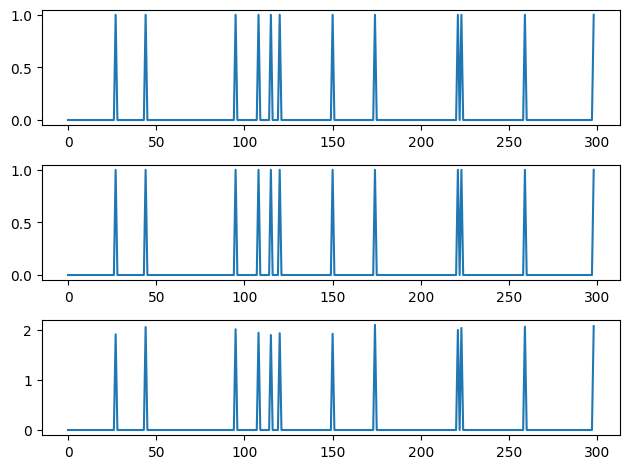

[I 2023-09-13 13:24:49,978] A new study created in memory with name: no-name-1c25840b-e48b-4936-915d-bf7108bb4841
[I 2023-09-13 13:24:49,993] Trial 0 finished with value: 0.7826086956521738 and parameters: {'model': 'logistic', 'C': 1.0389398315380791}. Best is trial 0 with value: 0.7826086956521738.
[I 2023-09-13 13:24:50,045] Trial 1 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 2.9430870796533526}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:24:50,092] Trial 2 finished with value: 0.7076923076923077 and parameters: {'model': 'svm_linear', 'C': 0.0263534797101079}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:24:50,104] Trial 3 finished with value: 0.6557377049180327 and parameters: {'model': 'logistic', 'C': 0.18063710289615872}. Best is trial 1 with value: 0.7999999999999999.


On y
running tuna study on metric


[I 2023-09-13 13:24:50,151] Trial 4 finished with value: 0.6774193548387099 and parameters: {'model': 'svm_linear', 'C': 0.022976686207667147}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:24:50,166] Trial 5 finished with value: 0.7462686567164178 and parameters: {'model': 'logistic', 'C': 0.7024400084921616}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:24:50,416] Trial 6 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 19.695551247693842}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:24:50,468] Trial 7 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 3.0553612853456604}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:24:50,556] Trial 8 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 6.589602849829666}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:24:50,593] Trial 9 finished with v

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.2209063533882543}
Best Validation Set Accuracy: 0.8493150684931509
Test Set Accuracy: 0.75


[I 2023-09-13 13:24:53,118] Trial 1 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 54.81240257702198}. Best is trial 0 with value: 0.7567567567567567.
[I 2023-09-13 13:24:53,139] Trial 2 finished with value: 0.7837837837837837 and parameters: {'model': 'logistic', 'C': 38.27501641795537}. Best is trial 2 with value: 0.7837837837837837.
[I 2023-09-13 13:24:53,176] Trial 3 finished with value: 0.7894736842105262 and parameters: {'model': 'svm_linear', 'C': 0.2992745882246548}. Best is trial 3 with value: 0.7894736842105262.
[I 2023-09-13 13:24:53,190] Trial 4 finished with value: 0.696969696969697 and parameters: {'model': 'logistic', 'C': 0.4361862828983451}. Best is trial 3 with value: 0.7894736842105262.
[I 2023-09-13 13:24:53,226] Trial 5 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 0.6960424305411582}. Best is trial 5 with value: 0.7999999999999999.
[I 2023-09-13 13:24:53,333] Trial 6 finished with value: 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.6960424305411582}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.8648648648648649


[I 2023-09-13 13:24:54,947] Trial 9 finished with value: 0.5454545454545454 and parameters: {'model': 'logistic', 'C': 0.06586534483013773}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:24:55,616] Trial 10 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 88.9236388673676}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:24:55,637] Trial 11 finished with value: 0.7999999999999999 and parameters: {'model': 'logistic', 'C': 40.29206127324572}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:24:55,652] Trial 12 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 7.642612591938842}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:24:55,668] Trial 13 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 7.01557584661999}. Best is trial 4 with value: 0.7999999999999999.
[I 2023-09-13 13:24:55,687] Trial 14 finished with value: 0

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 66.3526168828929}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.823529411764706


[I 2023-09-13 13:24:56,330] Trial 4 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 39.63771915975627}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:24:56,375] Trial 5 finished with value: 0.7945205479452054 and parameters: {'model': 'svm_linear', 'C': 2.405995690528484}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:24:56,410] Trial 6 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 0.22163406933430044}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:24:56,424] Trial 7 finished with value: 0.6333333333333334 and parameters: {'model': 'logistic', 'C': 0.1931890791637857}. Best is trial 4 with value: 0.7945205479452054.
[I 2023-09-13 13:24:56,486] Trial 8 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 3.1648904705420366}. Best is trial 8 with value: 0.8108108108108107.
[I 2023-09-13 13:24:56,499] Trial 9 finished with val

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 3.1648904705420366}
Best Validation Set Accuracy: 0.8108108108108107
Test Set Accuracy: 0.7169811320754718


[I 2023-09-13 13:24:57,520] Trial 4 finished with value: 0.8311688311688312 and parameters: {'model': 'svm_linear', 'C': 15.989054814778427}. Best is trial 4 with value: 0.8311688311688312.
[I 2023-09-13 13:24:57,528] Trial 5 finished with value: 0.6557377049180327 and parameters: {'model': 'logistic', 'C': 0.16816458624675584}. Best is trial 4 with value: 0.8311688311688312.
[I 2023-09-13 13:24:57,541] Trial 6 finished with value: 0.36734693877551017 and parameters: {'model': 'logistic', 'C': 0.03150782872194277}. Best is trial 4 with value: 0.8311688311688312.
[I 2023-09-13 13:24:57,557] Trial 7 finished with value: 0.7246376811594203 and parameters: {'model': 'logistic', 'C': 1.7127860298365631}. Best is trial 4 with value: 0.8311688311688312.
[I 2023-09-13 13:24:57,594] Trial 8 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 2.000516802639742}. Best is trial 4 with value: 0.8311688311688312.
[I 2023-09-13 13:24:57,635] Trial 9 finished with valu

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 15.989054814778427}
Best Validation Set Accuracy: 0.8311688311688312
Test Set Accuracy: 0.7654320987654323


[I 2023-09-13 13:25:00,906] Trial 2 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 38.30173967314172}. Best is trial 2 with value: 0.7567567567567567.
[I 2023-09-13 13:25:00,945] Trial 3 finished with value: 0.7397260273972603 and parameters: {'model': 'svm_linear', 'C': 0.09527067817059916}. Best is trial 2 with value: 0.7567567567567567.
[I 2023-09-13 13:25:00,982] Trial 4 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.4550257858409801}. Best is trial 4 with value: 0.7671232876712328.
[I 2023-09-13 13:25:00,998] Trial 5 finished with value: 0.7042253521126761 and parameters: {'model': 'logistic', 'C': 14.93961980680215}. Best is trial 4 with value: 0.7671232876712328.
[I 2023-09-13 13:25:01,012] Trial 6 finished with value: 0.7042253521126761 and parameters: {'model': 'logistic', 'C': 48.57139289772688}. Best is trial 4 with value: 0.7671232876712328.
[I 2023-09-13 13:25:01,025] Trial 7 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 21.23132029294535}
Best Validation Set Accuracy: 0.7733333333333333
Test Set Accuracy: 0.8695652173913043


[I 2023-09-13 13:25:04,646] Trial 6 finished with value: 0.7397260273972603 and parameters: {'model': 'svm_linear', 'C': 0.08022623024260453}. Best is trial 1 with value: 0.7733333333333333.
[I 2023-09-13 13:25:04,655] Trial 7 finished with value: 0.18181818181818182 and parameters: {'model': 'logistic', 'C': 0.018273982808787507}. Best is trial 1 with value: 0.7733333333333333.
[I 2023-09-13 13:25:04,661] Trial 8 finished with value: 0.5185185185185185 and parameters: {'model': 'logistic', 'C': 0.07076179278444249}. Best is trial 1 with value: 0.7733333333333333.
[I 2023-09-13 13:25:05,085] Trial 9 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 36.599070561241696}. Best is trial 1 with value: 0.7733333333333333.
[I 2023-09-13 13:25:05,132] Trial 10 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 1.6900242176498272}. Best is trial 10 with value: 0.7999999999999999.
[I 2023-09-13 13:25:05,178] Trial 11 finished w

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.7684827026229835}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.8292682926829269


[I 2023-09-13 13:25:05,936] Trial 9 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 0.670636775426421}. Best is trial 7 with value: 0.8051948051948051.
[I 2023-09-13 13:25:06,004] Trial 10 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 5.719985201390916}. Best is trial 10 with value: 0.8266666666666667.
[I 2023-09-13 13:25:06,071] Trial 11 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 4.566753012539734}. Best is trial 10 with value: 0.8266666666666667.
[I 2023-09-13 13:25:06,163] Trial 12 finished with value: 0.8157894736842106 and parameters: {'model': 'svm_linear', 'C': 8.695334151429364}. Best is trial 10 with value: 0.8266666666666667.
[I 2023-09-13 13:25:06,251] Trial 13 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 12.088810270040929}. Best is trial 10 with value: 0.8266666666666667.
[I 2023-09-13 13:25:06,383] Trial 14 finished 

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 5.719985201390916}
Best Validation Set Accuracy: 0.8266666666666667
Test Set Accuracy: 0.7647058823529411


[I 2023-09-13 13:25:07,477] Trial 3 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_linear', 'C': 5.354074927373974}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:25:07,488] Trial 4 finished with value: 0.6333333333333334 and parameters: {'model': 'logistic', 'C': 0.12164430593932873}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:25:07,501] Trial 5 finished with value: 0.7323943661971831 and parameters: {'model': 'logistic', 'C': 0.8240516505853124}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:25:07,542] Trial 6 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 0.07350085492807557}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:25:07,557] Trial 7 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 4.753608870041373}. Best is trial 1 with value: 0.7999999999999999.
[I 2023-09-13 13:25:07,605] Trial 8 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.5951923129315202}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.888888888888889


[I 2023-09-13 13:25:09,119] Trial 1 finished with value: 0.9142857142857143 and parameters: {'model': 'svm_linear', 'C': 18.253096910598856}. Best is trial 1 with value: 0.9142857142857143.
[I 2023-09-13 13:25:09,131] Trial 2 finished with value: 0.4 and parameters: {'model': 'logistic', 'C': 0.07008393407820651}. Best is trial 1 with value: 0.9142857142857143.
[I 2023-09-13 13:25:09,146] Trial 3 finished with value: 0.875 and parameters: {'model': 'logistic', 'C': 25.954656549241673}. Best is trial 1 with value: 0.9142857142857143.
[I 2023-09-13 13:25:09,184] Trial 4 finished with value: 0.888888888888889 and parameters: {'model': 'svm_linear', 'C': 0.8990752102998191}. Best is trial 1 with value: 0.9142857142857143.
[I 2023-09-13 13:25:09,642] Trial 5 finished with value: 0.9142857142857143 and parameters: {'model': 'svm_linear', 'C': 59.92250710015469}. Best is trial 1 with value: 0.9142857142857143.
[I 2023-09-13 13:25:09,653] Trial 6 finished with value: 0.47619047619047616 and pa

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 18.253096910598856}
Best Validation Set Accuracy: 0.9142857142857143
Test Set Accuracy: 0.7954545454545455


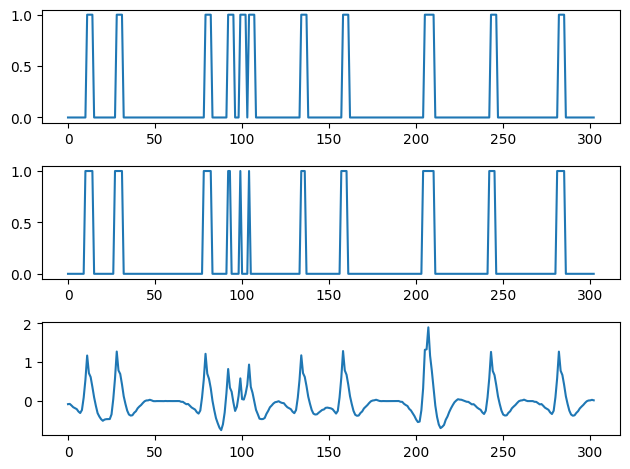

[I 2023-09-13 13:25:12,696] A new study created in memory with name: no-name-2e55a5d2-9361-4627-a98d-a351dcb5bc81
[I 2023-09-13 13:25:12,720] Trial 0 finished with value: 0.8055555555555555 and parameters: {'model': 'logistic', 'C': 6.7343785729025045}. Best is trial 0 with value: 0.8055555555555555.
[I 2023-09-13 13:25:12,740] Trial 1 finished with value: 0.8055555555555555 and parameters: {'model': 'logistic', 'C': 76.05628009559011}. Best is trial 0 with value: 0.8055555555555555.
[I 2023-09-13 13:25:12,754] Trial 2 finished with value: 0.7272727272727274 and parameters: {'model': 'logistic', 'C': 0.5736640392219644}. Best is trial 0 with value: 0.8055555555555555.
[I 2023-09-13 13:25:12,815] Trial 3 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 3.5153525508746526}. Best is trial 3 with value: 0.8108108108108107.
[I 2023-09-13 13:25:12,830] Trial 4 finished with value: 0.821917808219178 and parameters: {'model': 'logistic', 'C': 13.530298415631

On y_hat
running tuna study on metric


[I 2023-09-13 13:25:12,884] Trial 6 finished with value: 0.6206896551724138 and parameters: {'model': 'svm_linear', 'C': 0.014435987563696275}. Best is trial 4 with value: 0.821917808219178.
[I 2023-09-13 13:25:12,900] Trial 7 finished with value: 0.821917808219178 and parameters: {'model': 'logistic', 'C': 14.761208343186995}. Best is trial 4 with value: 0.821917808219178.
[I 2023-09-13 13:25:12,942] Trial 8 finished with value: 0.821917808219178 and parameters: {'model': 'svm_linear', 'C': 2.0135596736429298}. Best is trial 4 with value: 0.821917808219178.
[I 2023-09-13 13:25:12,963] Trial 9 finished with value: 0.8055555555555555 and parameters: {'model': 'logistic', 'C': 74.49420164492109}. Best is trial 4 with value: 0.821917808219178.
[I 2023-09-13 13:25:13,000] Trial 10 finished with value: 0.8266666666666667 and parameters: {'model': 'svm_linear', 'C': 0.2036822773872531}. Best is trial 10 with value: 0.8266666666666667.
[I 2023-09-13 13:25:13,042] Trial 11 finished with value:

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.2036822773872531}
Best Validation Set Accuracy: 0.8266666666666667
Test Set Accuracy: 0.7999999999999999


[I 2023-09-13 13:25:13,957] Trial 1 finished with value: 0.72 and parameters: {'model': 'svm_linear', 'C': 26.676793024405136}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:25:13,970] Trial 2 finished with value: 0.5454545454545454 and parameters: {'model': 'logistic', 'C': 0.0733912893112999}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:25:13,984] Trial 3 finished with value: 0.7428571428571429 and parameters: {'model': 'logistic', 'C': 0.7886549481878236}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:25:14,027] Trial 4 finished with value: 0.4313725490196079 and parameters: {'model': 'svm_linear', 'C': 0.010621896532211033}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:25:14,062] Trial 5 finished with value: 0.7733333333333333 and parameters: {'model': 'svm_linear', 'C': 0.785289871601067}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:25:14,530] Trial 6 finished with value: 0.72972972

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.956601500623064}
Best Validation Set Accuracy: 0.7733333333333333
Test Set Accuracy: 0.8648648648648649


[I 2023-09-13 13:25:15,403] Trial 3 finished with value: 0.7297297297297296 and parameters: {'model': 'svm_linear', 'C': 0.0770596939430861}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:25:15,423] Trial 4 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 79.02151257682473}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:25:15,456] Trial 5 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 1.596323364367252}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:25:15,510] Trial 6 finished with value: 0.7466666666666666 and parameters: {'model': 'svm_linear', 'C': 5.628191230223113}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:25:15,530] Trial 7 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 70.72954538441616}. Best is trial 0 with value: 0.7733333333333333.
[I 2023-09-13 13:25:15,887] Trial 8 finished with value: 0

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 9.029515936839877}
Best Validation Set Accuracy: 0.7733333333333333
Test Set Accuracy: 0.7941176470588236


[I 2023-09-13 13:25:16,674] Trial 6 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 13.318492382931199}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:25:16,708] Trial 7 finished with value: 0.7777777777777777 and parameters: {'model': 'svm_linear', 'C': 0.13703527952770558}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:25:16,743] Trial 8 finished with value: 0.676923076923077 and parameters: {'model': 'svm_linear', 'C': 0.032591315325748944}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:25:16,810] Trial 9 finished with value: 0.7837837837837837 and parameters: {'model': 'svm_linear', 'C': 10.256793226607401}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:25:16,834] Trial 10 finished with value: 0.7352941176470589 and parameters: {'model': 'logistic', 'C': 3.6787552270929624}. Best is trial 3 with value: 0.7837837837837837.
[I 2023-09-13 13:25:16,858] Trial 11 finished wit

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 26.904297554137383}
Best Validation Set Accuracy: 0.7945205479452054
Test Set Accuracy: 0.64


[I 2023-09-13 13:25:17,341] Trial 2 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 31.619646018692645}. Best is trial 2 with value: 0.8108108108108107.
[I 2023-09-13 13:25:17,377] Trial 3 finished with value: 0.7222222222222223 and parameters: {'model': 'svm_linear', 'C': 0.06672624756667951}. Best is trial 2 with value: 0.8108108108108107.
[I 2023-09-13 13:25:17,387] Trial 4 finished with value: 0.04878048780487806 and parameters: {'model': 'logistic', 'C': 0.011140101396116833}. Best is trial 2 with value: 0.8108108108108107.
[I 2023-09-13 13:25:17,643] Trial 5 finished with value: 0.8108108108108107 and parameters: {'model': 'svm_linear', 'C': 38.75146121375113}. Best is trial 2 with value: 0.8108108108108107.
[I 2023-09-13 13:25:17,677] Trial 6 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 0.3653457882949981}. Best is trial 2 with value: 0.8108108108108107.
[I 2023-09-13 13:25:17,717] Trial 7 finished with

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 31.619646018692645}
Best Validation Set Accuracy: 0.8108108108108107
Test Set Accuracy: 0.7297297297297297


[I 2023-09-13 13:25:20,391] Trial 2 finished with value: 0.7123287671232875 and parameters: {'model': 'svm_linear', 'C': 92.81425870446347}. Best is trial 1 with value: 0.7605633802816901.
[I 2023-09-13 13:25:20,411] Trial 3 finished with value: 0.7567567567567567 and parameters: {'model': 'logistic', 'C': 40.87459427599059}. Best is trial 1 with value: 0.7605633802816901.
[I 2023-09-13 13:25:20,450] Trial 4 finished with value: 0.7428571428571429 and parameters: {'model': 'svm_linear', 'C': 0.04744698077512211}. Best is trial 1 with value: 0.7605633802816901.
[I 2023-09-13 13:25:20,463] Trial 5 finished with value: 0.75 and parameters: {'model': 'logistic', 'C': 9.642894645414252}. Best is trial 1 with value: 0.7605633802816901.
[I 2023-09-13 13:25:20,496] Trial 6 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 0.22824134327079984}. Best is trial 6 with value: 0.7671232876712328.
[I 2023-09-13 13:25:20,508] Trial 7 finished with value: 0.2608695652

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.47056193142734054}
Best Validation Set Accuracy: 0.7894736842105262
Test Set Accuracy: 0.8181818181818182


[I 2023-09-13 13:25:21,344] Trial 4 finished with value: 0.7792207792207791 and parameters: {'model': 'svm_linear', 'C': 22.604828757277414}. Best is trial 2 with value: 0.7894736842105262.
[I 2023-09-13 13:25:21,351] Trial 5 finished with value: 0.09523809523809523 and parameters: {'model': 'logistic', 'C': 0.015892936139542256}. Best is trial 2 with value: 0.7894736842105262.
[I 2023-09-13 13:25:21,365] Trial 6 finished with value: 0.6440677966101694 and parameters: {'model': 'logistic', 'C': 0.14031285311856234}. Best is trial 2 with value: 0.7894736842105262.
[I 2023-09-13 13:25:21,384] Trial 7 finished with value: 0.7567567567567567 and parameters: {'model': 'logistic', 'C': 18.212858470272582}. Best is trial 2 with value: 0.7894736842105262.
[I 2023-09-13 13:25:21,396] Trial 8 finished with value: 0.5454545454545454 and parameters: {'model': 'logistic', 'C': 0.0751940244214713}. Best is trial 2 with value: 0.7894736842105262.
[I 2023-09-13 13:25:21,409] Trial 9 finished with valu

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.25373024006055683}
Best Validation Set Accuracy: 0.8157894736842106
Test Set Accuracy: 0.8333333333333334


[I 2023-09-13 13:25:23,142] Trial 6 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 3.0242253432016892}. Best is trial 5 with value: 0.7945205479452054.
[I 2023-09-13 13:25:23,161] Trial 7 finished with value: 0.7605633802816901 and parameters: {'model': 'logistic', 'C': 9.884017111031568}. Best is trial 5 with value: 0.7945205479452054.
[I 2023-09-13 13:25:23,234] Trial 8 finished with value: 0.7567567567567567 and parameters: {'model': 'svm_linear', 'C': 6.71489439427465}. Best is trial 5 with value: 0.7945205479452054.
[I 2023-09-13 13:25:23,267] Trial 9 finished with value: 0.7887323943661972 and parameters: {'model': 'svm_linear', 'C': 0.17303021923917572}. Best is trial 5 with value: 0.7945205479452054.
[I 2023-09-13 13:25:23,297] Trial 10 finished with value: 0.7671232876712328 and parameters: {'model': 'logistic', 'C': 69.42398123038089}. Best is trial 5 with value: 0.7945205479452054.
[I 2023-09-13 13:25:23,334] Trial 11 finished with value

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.6084639678834391}
Best Validation Set Accuracy: 0.7945205479452054
Test Set Accuracy: 0.7384615384615385


[I 2023-09-13 13:25:24,298] Trial 0 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 63.82995626436449}. Best is trial 0 with value: 0.75.
[I 2023-09-13 13:25:24,312] Trial 1 finished with value: 0.5714285714285715 and parameters: {'model': 'logistic', 'C': 0.07735456820069132}. Best is trial 0 with value: 0.75.
[I 2023-09-13 13:25:24,402] Trial 2 finished with value: 0.7671232876712328 and parameters: {'model': 'svm_linear', 'C': 14.49035071069239}. Best is trial 2 with value: 0.7671232876712328.
[I 2023-09-13 13:25:24,410] Trial 3 finished with value: 0.2978723404255319 and parameters: {'model': 'logistic', 'C': 0.022321797949913697}. Best is trial 2 with value: 0.7671232876712328.
[I 2023-09-13 13:25:25,108] Trial 4 finished with value: 0.75 and parameters: {'model': 'svm_linear', 'C': 69.61158125823054}. Best is trial 2 with value: 0.7671232876712328.
[I 2023-09-13 13:25:25,144] Trial 5 finished with value: 0.7999999999999999 and parameters: {'model': 'svm_lin

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.1706389258452432}
Best Validation Set Accuracy: 0.7999999999999999
Test Set Accuracy: 0.9142857142857143


[I 2023-09-13 13:25:26,499] Trial 3 finished with value: 0.9411764705882353 and parameters: {'model': 'svm_linear', 'C': 18.015968232855066}. Best is trial 1 with value: 0.9411764705882353.
[I 2023-09-13 13:25:26,513] Trial 4 finished with value: 0.4 and parameters: {'model': 'logistic', 'C': 0.03207224246885505}. Best is trial 1 with value: 0.9411764705882353.
[I 2023-09-13 13:25:26,531] Trial 5 finished with value: 0.9411764705882353 and parameters: {'model': 'logistic', 'C': 44.65268187527491}. Best is trial 1 with value: 0.9411764705882353.
[I 2023-09-13 13:25:26,545] Trial 6 finished with value: 0.7999999999999999 and parameters: {'model': 'logistic', 'C': 0.23417248020610107}. Best is trial 1 with value: 0.9411764705882353.
[I 2023-09-13 13:25:26,564] Trial 7 finished with value: 0.9411764705882353 and parameters: {'model': 'logistic', 'C': 48.19864159521652}. Best is trial 1 with value: 0.9411764705882353.
[I 2023-09-13 13:25:26,577] Trial 8 finished with value: 0.83870967741935

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 51.261303395314556}
Best Validation Set Accuracy: 0.9411764705882353
Test Set Accuracy: 0.7954545454545455


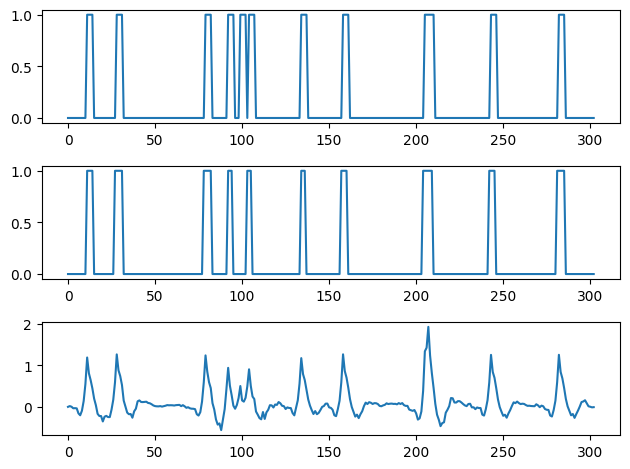

C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_14744\266028130.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
[I 2023-09-13 13:25:28,815] A new study created in memory with name: no-name-4e263697-ca8e-4d14-bee0-37ba865d6877
[I 2023-09-13 13:25:28,828] Trial 0 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.4877355620630834}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:28,839] Trial 1 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 3.2310514990101944}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:28,856] Trial 2 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 70.89389565629882}. Best is trial 0 with value: 1.0.
[I 2023-09-13 1

For SNR = -10
On x
running tuna study on metric


[I 2023-09-13 13:25:29,002] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 10.996775120296846}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,018] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.7397704084837242}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,033] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.7484508808159833}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,049] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 11.617059341299628}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,064] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.9797942428429547}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,080] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.15500455560955356}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,095] Trial 1

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 2.4877355620630834}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:25:29,295] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 16.238165575461945}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,315] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 83.68573428775521}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,328] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.31022841674475793}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,344] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 11.200474919565687}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,358] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 32.059329808143154}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,377] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 6.7359127533519905}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,394] Trial 18 fin

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 31.217305479924015}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:25:29,614] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 62.4608378073447}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,637] Trial 13 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 16.30633739202236}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,655] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 99.79501961876045}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,675] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 15.108115547480518}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,693] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.1661236463237222}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,711] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 4.381452890667972}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,733] Trial 18 fi

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 1.3332262298666595}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:25:29,977] Trial 12 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.08651043493187237}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:29,995] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.9511033091864111}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,010] Trial 14 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.013160143145952524}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,031] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.06004689300339788}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,048] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.4407747923993794}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,069] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 2.2297129024791005}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,087] Trial 18

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.04294382389203528}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:25:30,350] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.1519276375520374}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,362] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 1.3925031849529506}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,380] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.028527876310589666}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,398] Trial 18 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.17638213582197274}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,418] Trial 19 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 0.037874417369962575}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,428] A new study created in memory with name: no-name-e13fbcd7-71bf-40f6-8856-3e9f050f50ae
[I 2023-09-13 13:25:30,441] Trial 0 finished with value: 1.0 and parameters: {

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 0.8134296045028538}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:25:30,621] Trial 12 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 9.627019761490756}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,638] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.9990758189099462}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,654] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 99.63559924208934}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,673] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 5.1200614827428215}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,689] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.28970004221732815}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,706] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 3.8337686282882593}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:30,721] Trial 18 finished w

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 1.298964073602711}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:25:31,054] Trial 10 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 95.36724653068717}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,068] Trial 11 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.0952351837655993}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,084] Trial 12 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 0.010856057114442591}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,098] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.08657600075527701}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,111] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 70.48969969344472}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,129] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 2.059129807375635}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,141] Trial 16 finishe

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 60.54303772610011}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:25:31,412] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 4.88517163241176}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,429] Trial 14 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 94.505623534902}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,448] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 18.19409523388477}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,466] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 2.492457447330104}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,483] Trial 17 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 33.04670447978568}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,501] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 7.712033499449848}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,519] Trial 19 finished wit

Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 99.99947158723438}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:25:31,716] Trial 12 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 2.8655203574295527}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,735] Trial 13 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 82.2055874238141}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,751] Trial 14 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 2.1946003134204335}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,767] Trial 15 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.3723475723494677}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,782] Trial 16 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 4.485004361409389}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,796] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 29.520259160587425}. Best is trial 0 with value: 1.0.
[I 2023-09-13 13:25:31,813] Trial 18 finished wit

Best Hyperparameters from Optuna: {'model': 'logistic', 'C': 23.85060282477088}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


[I 2023-09-13 13:25:32,042] Trial 15 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 12.728168715654723}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:25:32,053] Trial 16 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 99.75057230715335}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:25:32,069] Trial 17 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 0.30612561287299056}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:25:32,080] Trial 18 finished with value: 1.0 and parameters: {'model': 'svm_linear', 'C': 30.78461588874206}. Best is trial 1 with value: 1.0.
[I 2023-09-13 13:25:32,099] Trial 19 finished with value: 1.0 and parameters: {'model': 'logistic', 'C': 5.831822610590911}. Best is trial 1 with value: 1.0.


Best Hyperparameters from Optuna: {'model': 'svm_linear', 'C': 21.125817319324604}
Best Validation Set Accuracy: 1.0
Test Set Accuracy: 1.0


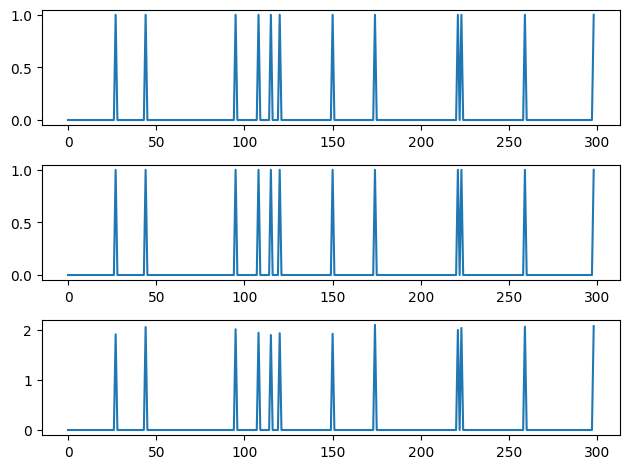

[I 2023-09-13 13:25:32,365] A new study created in memory with name: no-name-e7efa4a7-1bcf-4bd4-bc30-0287ea48dfbf
[I 2023-09-13 13:25:32,375] Trial 0 finished with value: 0.0 and parameters: {'model': 'logistic', 'C': 6.469467971589455}. Best is trial 0 with value: 0.0.
[I 2023-09-13 13:25:32,439] Trial 1 finished with value: 0.0 and parameters: {'model': 'svm_linear', 'C': 0.08194007473002571}. Best is trial 0 with value: 0.0.
[I 2023-09-13 13:25:32,510] Trial 2 finished with value: 0.0 and parameters: {'model': 'svm_linear', 'C': 0.09059324416134026}. Best is trial 0 with value: 0.0.


On y
running tuna study on metric


[I 2023-09-13 13:25:32,553] Trial 3 finished with value: 0.0 and parameters: {'model': 'svm_linear', 'C': 0.018985955484973515}. Best is trial 0 with value: 0.0.


In [ ]:
for itr in range(20):
  print(f"%%%%%%%%%%%%%%{itr}%%%%%%%%%%%%%%%%%")
  for cur_snr, cur_lam in snr_list:
    net_hyp = {"T": 200,                 # number of encoder unfolding
            "L": 10,                  # 1/L is the step size in the encoder
            "C": 2,                 # number of filters
            "K": 18,                  # legnth of the filters
            "lam": cur_lam,
            "device": device
            }
    data_hyp ={"J": J, "N": N, "K": K, "C": C, "s": s, "x_mean": x_mean,
            "x_std": x_std, "SNR": cur_snr, "device": device}
    dataset = Simulate_Dataset.SimulatedDataset1D(data_hyp,x_const,one_kernel = True)
    net = Model.CRsAE1D(net_hyp)
    net.load_state_dict(torch.load(f'pretrained_on_simulated_data\snr_{snr_list[0][0]}.pth'))
    with torch.no_grad():
      y,x,_,_ = dataset[:]
      x_const = x
      x = torch.sum(x, dim=1, keepdim=True)
      y_hat, x_hat = net(y)
      #utils.vis_data_est(y[1,0], y_hat[1,0])
      x_hat = torch.sum(x_hat, dim=1, keepdim=True)
      y = y.squeeze(dim = 1)
      b = x[0,0] > 0
      x = x.squeeze(dim = 1)
      y_hat = y_hat.squeeze(dim = 1)
      x_hat = x_hat.squeeze(dim = 1)
      padding_begining = 15
      padding_end = 19
      # Perform the padding
      padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
      modified_tensor = torch.zeros_like(padded_tensor).to(device)
      indices_of_ones = torch.nonzero(padded_tensor).squeeze()

      for index in indices_of_ones:
        modified_tensor[index-1:index+3] = 1



    x_accuracy = []
    y_accuracy = []
    y_hat_accuracy = []
    print(f"For SNR = {cur_snr}")
    print("On x")
    x_accuracy.append(check_naive_classifiers(x, b))
    print("On y")
    y_accuracy.append(check_naive_classifiers(y, modified_tensor))
    print("On y_hat")
    y_hat_accuracy.append(check_naive_classifiers(y_hat, modified_tensor))

    cur_snr_list.append(cur_snr)
    x_f1_score.append(max(x_accuracy))
    y_f1_score.append(max(y_accuracy))
    y_hat_f1_score.append(max(y_hat_accuracy))

  # reset x for new study
  x_const = None

In [ ]:
yi,xi,h,_ = dataset[0:3]
yi_hat, xi_hat = net(yi)

utils.vis_data_est(yi[0,0][0:500], modified_tensor[0:500])
utils.vis_data_est(yi[0,0][0:500], yi_hat[0,0][0:500])


print(len(padded_tensor))
print(len(yi[0,0]))
utils.vis_data(padded_tensor[0:500])
#utils.vis_data(b)
utils.vis_filters(h)

In [ ]:
plt.scatter(cur_snr_list,x_f1_score, marker='o')
plt.xlabel('SNR')
plt.ylabel('x F1 score')
plt.title('')
plt.grid(True)
plt.show()

In [ ]:
plt.scatter(cur_snr_list,y_f1_score, marker='o')
plt.xlabel('SNR')
plt.ylabel('y F1 score')
plt.title('')
plt.grid(True)
plt.show()

In [ ]:
plt.scatter(cur_snr_list, y_hat_f1_score, marker='o')
plt.scatter(cur_snr_list,y_f1_score, marker='*')
plt.xlabel('SNR')
plt.ylabel('F1 score')
plt.legend(['y_hat','y'])
plt.title('F1 score before and after denoising')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
data = {'SNR': cur_snr_list, 'F1 score y_hat': y_hat_f1_score, 'F1 score y': y_f1_score}
df = pd.DataFrame(data)

# Specify the file name
csv_filename = 'simulated_behave_data_comperison.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_filename, index=False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.pandas.read_csv('results\simulated_behave_data_comperison_dialated_new_kernel.csv')

# Group the data by SNR and calculate mean and variance
grouped = df.groupby('SNR').agg({'F1 score y_hat': ['mean', 'std','count']})

# Extract the mean and variance values
means = grouped['F1 score y_hat']['mean']
std = grouped['F1 score y_hat']['std']
standard_error = std/grouped['F1 score y_hat']['count']

# Create a bar plot with error bars
plt.errorbar(means.index, means, yerr=standard_error, fmt='o', capsize=4)
# Group the data by SNR and calculate mean and variance
grouped = df.groupby('SNR').agg({'F1 score y': ['mean', 'std','count']})

# Extract the mean and variance values
means = grouped['F1 score y']['mean']
std = grouped['F1 score y']['std']
standard_error = std/grouped['F1 score y']['count']

# Create a bar plot with error bars
plt.errorbar(means.index, means, yerr=standard_error, fmt='o', capsize=4)

# Add labels and title
plt.xlabel('SNR')
plt.ylabel('Mean Values')
plt.title('Mean Values with standard Error Bars')
plt.legend(['y_hat','y'])

# Show the plot
plt.show()